In [1]:
# Imports
import gpflow
from gpflow.utilities import print_summary, set_trainable
from gpflow.ci_utils import ci_niter
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import callbacks
import time

In [2]:
# This ensures that all the data isn't loaded into the GPU memory at once.
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

In [4]:
def load_dataset(value):
    """This function loads the preprocessed dataset and the class mapping for the preprocessed dataset.

    :param value: Integer specifying the number of objects per class.
    :return dataset: The preprocessed dataset.
    :return class_map: The class mapping for the preprocessed dataset."""

    dataset = pd.read_csv("./preprocessed_datasets/preprocessed_dataset_{}.csv".format(value))
    print('Dataset Shape:', dataset.shape)
    
    class_names = pd.read_csv("./preprocessed_datasets/class_mapping_{}.csv".format(value), header=None)
    class_map = dict(class_names.values[:, ::-1])
    
    return dataset, class_map

In [5]:
def get_data(dataset):
    """This function creates the test and train datasets.

    :param dataset: The dataset from which we want to create the test and train datasets.
    :return x_train: The train dataset.
    :return y_train: The train dataset labels.
    :return x_test: The test dataset.
    :return y_test: The test dataset labels."""

    x = np.array(dataset.iloc[:, 1:-1])
    y = np.array(dataset.iloc[:, -1]).reshape(-1,)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    scaler = StandardScaler()
    
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    print('X_train: ', x_train.shape, ', y_train: ', y_train.shape, ', X_test: ', x_test.shape, ', y_test: ',
          y_test.shape)

    return x_train, y_train, x_test, y_test

In [6]:
def gp_model(x_train, y_train, x_test, num_classes):
    """This function instantiates the gp model and gets the predictions from the model.

    :param x_train: The training dataset.
    :param y_train: The training dataset labels.
    :param x_test: The test dataset.
    :param num_classes: The number of classes in the dataset.
    :return: predictions, the predictions from the gp model.
    :return time_taken: The time taken to train the model."""

    data = (x_train, y_train)
    kernel = gpflow.kernels.SquaredExponential() + gpflow.kernels.Matern12() + gpflow.kernels.Exponential()

    invlink = gpflow.likelihoods.RobustMax(num_classes)
    likelihood = gpflow.likelihoods.MultiClass(num_classes, invlink=invlink)
    z = x_train[::5].copy()

    model = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood, inducing_variable=z, num_latent_gps=num_classes,
                               whiten=True, q_diag=True)

    set_trainable(model.inducing_variable, False)
    
    print('\nInitial parameters:')
    print_summary(model, fmt="notebook")
    
    start = time.time()
    
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss_closure(data), model.trainable_variables, options=dict(maxiter=ci_niter(1000)))
    
    print('\nParameters after optimization:')
    print_summary(model, fmt="notebook")
    
    end = time.time()
    time_taken = round(end - start, 2)
    
    print('Optimization took {:.2f} seconds'.format(time_taken))

    predictions = model.predict_y(x_test)[0]

    return predictions, time_taken

In [7]:
def dl_model_1(x_train, y_train, x_test, y_test, num_classes):
    """This function instantiates the dl model and gets the predictions from the model.

    :param x_train: The training dataset.
    :param y_train: The training dataset labels.
    :param x_test: The test dataset.
    :param y_test: The test dataset labels.
    :param num_classes: The number of classes in the dataset.
    :return: predictions, the predictions from the gp model.
    :return time_taken: The time taken to train the model."""

    y_train_cate = to_categorical(y_train, num_classes)
    y_test_cate = to_categorical(y_test, num_classes)
    
    model = Sequential()
    model.add(Dense(512, input_dim=x_train.shape[1], kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(128, activity_regularizer=regularizers.l2(0.01)))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    optimizer = Adam()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
    class_weights = {}

    for i in range(num_classes):
        class_weights[i] = weights[i]

    print('\nModel summary:')
    print(model.summary())
    start = time.time()   
    
    model.fit(x_train, y_train_cate, epochs=500, batch_size=32, verbose=1, validation_data=(x_test, y_test_cate),
              shuffle=True, class_weight=class_weights)
    
    end = time.time()
    time_taken = round((end - start), 2)
    
    print('Optimization took {:.2f} seconds'.format(time_taken))
    
    predictions = model.predict(x_test)
    
    return predictions, time_taken

In [8]:
def dl_model_2(x_train, y_train, x_test, y_test, num_classes):
    """This function instantiates the dl model and gets the predictions from the model.

    :param x_train: The training dataset.
    :param y_train: The training dataset labels.
    :param x_test: The test dataset.
    :param y_test: The test dataset labels.
    :param num_classes: The number of classes in the dataset.
    :return: predictions, the predictions from the gp model.
    :return time_taken: The time taken to train the model."""

    y_train_cate = to_categorical(y_train, num_classes)
    y_test_cate = to_categorical(y_test, num_classes)
    
    model = Sequential()
    model.add(Dense(256, input_dim=x_train.shape[1]))
    model.add(Dense(64))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    optimizer = Adam()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
    class_weights = {}
    for i in range(num_classes):
        class_weights[i] = weights[i]

    print('\nModel summary:')
    print(model.summary())
    start = time.time()   
    
    model.fit(x_train, y_train_cate, epochs=500, batch_size=32, verbose=1, validation_data=(x_test, y_test_cate),
              shuffle=True, class_weight=class_weights)
    
    end = time.time()
    time_taken = round((end - start), 2)
    
    print('Optimization took {:.2f} seconds'.format(time_taken))
    
    predictions = model.predict(x_test)
    
    return predictions, time_taken

In [9]:
def evaluate(predictions, y_test, num_classes, class_map):
    """This function calculates the precision, recall, f-score and accuracy for the model's predictions.
    :param predictions: The predictions from the model.
    :param y_test: The true labels for the test dataset.
    :param num_classes: The number of classes in the test dataset.
    :param class_map: The class mapping for the dataset."""

    y_pred = np.argmax(predictions, axis=1)
    
    precision = round(precision_score(y_test, y_pred, average='weighted'), 2)
    recall = round(recall_score(y_test, y_pred, average='weighted'), 2)
    f_score = round(f1_score(y_test, y_pred, average='weighted'), 2)
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1-Score: ", f_score)
    print("Accuracy: ", accuracy)
    
    print('\nPer Class Results:')
    print(classification_report(y_test, y_pred))
    
    confusion__matrix(y_pred, y_test, num_classes, class_map)
    
    return precision, recall, f_score, accuracy

In [10]:
def confusion__matrix(y_pred, y_test, num_classes, class_map):
    """This function plots the confusion matrix.

    :param y_pred: The predictions from the model.
    :param y_test: The actual labels for the test dataset.
    :param num_classes: The number of classes in the dataset.
    :param class_map: The class mapping dictionary for the dataset."""

    confusion_mtx = confusion_matrix(y_test, y_pred, normalize='true')
    classes = [i for i in range(num_classes)]
    class_names = [str(class_map[i]) for i in classes]
    plt.figure(figsize=(12, 12))
    plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
    plt.xticks(classes, class_names)
    plt.yticks(classes, class_names)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    for i in classes:
        for j in classes:
            plt.text(i, j, format(confusion_mtx[j][i], '.2f'), horizontalalignment="center",
                     color="white" if confusion_mtx[j, i] > 0.8 else "black")
    plt.show()

In [11]:
def run_models(dl_model, value):
    """This function trains the deep learning and gaussian process models increasing the number of classes each time and
    stores their performance metrics.

    :param dl_model: The deep learning model.
    :param value: The number of data objects per class.
    :return gp_accuracies: The list of accuracy values we get from the gp model.
    :return gp_time_track: The different values for the time taken by the gp model.
    :return gp_precisions: The different precision values for the gp model.
    :return gp_recalls: The different recall values for the gp model.
    :return gp_fscores: The different fscore values for the gp model
    :return dl_accuracies: The list of accuracy values we get from the dl model.
    :return dl_time_track: The different values for the time taken by the dl model.
    :return dl_precisions: The different precision values for the dl model.
    :return dl_recalls: The different recall values for the dl model.
    :return dl_fscores: The different fscore values for the dl model."""

    dataset, class_map = load_dataset(value)

    total_classes = dataset['target'].unique().shape[0]
    
    gp_accuracies = []
    gp_time_track = []
    gp_precisions = []
    gp_recalls = []
    gp_fscores = []

    dl_accuracies = []
    dl_time_track = []
    dl_precisions = []
    dl_recalls = []
    dl_fscores = []

    for i in range(3, total_classes+1):
        print('\nFor number of classes: {}\n'.format(i))
        x_train, y_train, x_test, y_test = get_data(dataset[dataset['target'].isin([c for c in range(i)])])
        num_classes = np.unique(y_train).shape[0]

        print('\nGP evaluation:')
        gp_pred, gp_time = gp_model(x_train, y_train, x_test, num_classes)
        print('\nEvaluation GP Model results:')
        gp_precision, gp_recall, gp_f_score, gp_accuracy = evaluate(gp_pred, y_test, num_classes, class_map)

        gp_accuracies.append(gp_accuracy)
        gp_time_track.append(gp_time)
        gp_precisions.append(gp_precision)
        gp_recalls.append(gp_recall)
        gp_fscores.append(gp_f_score)

        print('\nDL evaluation:')
        dl_pred, dl_time = dl_model(x_train, y_train, x_test, y_test, num_classes)
        print('\nEvaluation DL Model results:')
        dl_precision, dl_recall, dl_f_score, dl_accuracy = evaluate(dl_pred, y_test, num_classes, class_map)

        dl_accuracies.append(dl_accuracy)
        dl_time_track.append(dl_time)
        dl_precisions.append(dl_precision)
        dl_recalls.append(dl_recall)
        dl_fscores.append(dl_f_score)
    
    plot_results(total_classes, gp_accuracies, gp_time_track, gp_precisions, gp_recalls, gp_fscores,
                dl_accuracies, dl_time_track, dl_precisions, dl_recalls, dl_fscores)
    
    return gp_accuracies, gp_time_track, gp_precisions, gp_recalls, gp_fscores, dl_accuracies, dl_time_track,\
           dl_precisions, dl_recalls, dl_fscores

In [12]:
def plot_results(total_classes, gp_accuracies, gp_time_track, gp_precisions, gp_recalls, gp_fscores,
            dl_accuracies, dl_time_track, dl_precisions, dl_recalls, dl_fscores):
    """This function plots the different graphs comparing the performance metrics of the gp and dl models.

    :param total_classes: The total number of classes in the dataset.
    :param gp_accuracies: The list of accuracy values we get from the gp model.
    :param gp_time_track: The different values for the time taken by the gp model.
    :param gp_precisions: The different precision values for the gp model.
    :param gp_recalls: The different recall values for the gp model.
    :param gp_fscores: The different fscore values for the gp model
    :param dl_accuracies: The list of accuracy values we get from the dl model.
    :param dl_time_track: The different values for the time taken by the dl model.
    :param dl_precisions: The different precision values for the dl model.
    :param dl_recalls: The different recall values for the dl model.
    :param dl_fscores: The different fscore values for the dl model."""

    ticks = [index for index in range(3, total_classes + 1)]    
    fig, axs = plt.subplots(5, 1, figsize=(15, 30))

    axs[0].grid()
    axs[0].plot(ticks, gp_accuracies)
    axs[0].plot(ticks, dl_accuracies)  
    axs[0].set_xticks(ticks)
    axs[0].legend(['GP', 'DL'], ncol=2)
    axs[0].set_title('Accuracy')
    axs[0].set_xlabel('Number of classes')
    axs[0].set_ylabel('Accuracy Values')

    axs[1].grid()
    axs[1].plot(ticks, gp_precisions)
    axs[1].plot(ticks, dl_precisions)  
    axs[1].set_xticks(ticks)
    axs[1].legend(['GP', 'DL'], ncol=2)
    axs[1].set_title('Precision')
    axs[1].set_xlabel('Number of classes')
    axs[1].set_ylabel('Precision Values')

    axs[2].grid()
    axs[2].plot(ticks, gp_recalls)
    axs[2].plot(ticks, dl_recalls)  
    axs[2].set_xticks(ticks)
    axs[2].legend(['GP', 'DL'], ncol=2)
    axs[2].set_title('Recall')
    axs[2].set_xlabel('Number of classes')
    axs[2].set_ylabel('Recall Values')

    axs[3].grid()
    axs[3].plot(ticks, gp_fscores)
    axs[3].plot(ticks, dl_fscores)  
    axs[3].set_xticks(ticks)
    axs[3].legend(['GP', 'DL'], ncol=2)
    axs[3].set_title('F1-Score')
    axs[3].set_xlabel('Number of classes')
    axs[3].set_ylabel('F1-Score Values')

    axs[4].grid()
    axs[4].plot(ticks, gp_time_track)
    axs[4].plot(ticks, dl_time_track)  
    axs[4].set_xticks(ticks)
    axs[4].legend(['GP', 'DL'], ncol=2)
    axs[4].set_title('Time Taken')
    axs[4].set_xlabel('Number of classes')
    axs[4].set_ylabel('Time')

# Using 500 object per class Dataset

Dataset Shape: (6500, 107)

For number of classes: 3

X_train:  (1200, 105) , y_train:  (1200,) , X_test:  (300, 105) , y_test:  (300,)

GP evaluation:

Initial parameters:


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

Parameters after optimization:


Optimization took 10.07 seconds

Evaluation GP Model results:
Precision:  0.98
Recall:  0.98
F1-Score:  0.98
Accuracy:  0.98

Per Class Results:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        91
           1       1.00      0.98      0.99       115
           2       0.97      0.99      0.98        94

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



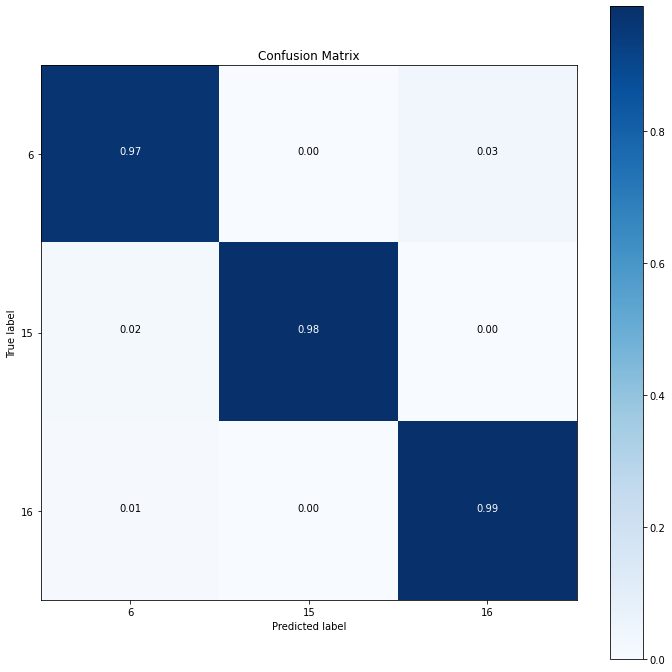


DL evaluation:

Model summary:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               54272     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation (Activation)      (None, 3)                 0         
Total params: 120,323
Trainable params: 120,323
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 0 0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


38/38 [==============================] - 0s 3ms/step - loss: 2.2235 - accuracy: 0.9200 - val_loss: 8.2560 - val_accuracy: 0.9500
Epoch 2/500
38/38 [==============================] - 0s 1ms/step - loss: 1.5587 - accuracy: 0.9700 - val_loss: 7.3618 - val_accuracy: 0.9567
Epoch 3/500
38/38 [==============================] - 0s 1ms/step - loss: 1.3831 - accuracy: 0.9675 - val_loss: 3.9700 - val_accuracy: 0.9700
Epoch 4/500
38/38 [==============================] - 0s 1ms/step - loss: 1.0767 - accuracy: 0.9750 - val_loss: 3.7568 - val_accuracy: 0.9633
Epoch 5/500
38/38 [==============================] - 0s 1ms/step - loss: 0.9159 - accuracy: 0.9758 - val_loss: 2.4456 - val_accuracy: 0.9767
Epoch 6/500
38/38 [==============================] - 0s 1ms/step - loss: 0.7257 - accuracy: 0.9783 - val_loss: 1.9559 - val_accuracy: 0.9733
Epoch 7/500
38/38 [==============================] - 0s 1ms/step - loss: 0.6493 - accuracy: 0.9808 - val_loss: 1.6600 - val_accuracy: 0.9767
Epoch 8/500
38/38 [======

Epoch 116/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0848 - accuracy: 0.9917 - val_loss: 0.3485 - val_accuracy: 0.9933
Epoch 117/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0805 - accuracy: 0.9900 - val_loss: 0.3747 - val_accuracy: 0.9933
Epoch 118/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0754 - accuracy: 0.9933 - val_loss: 0.4046 - val_accuracy: 0.9900
Epoch 119/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0746 - accuracy: 0.9942 - val_loss: 0.4101 - val_accuracy: 0.9900
Epoch 120/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0723 - accuracy: 0.9942 - val_loss: 0.4243 - val_accuracy: 0.9933
Epoch 121/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0712 - accuracy: 0.9958 - val_loss: 0.4483 - val_accuracy: 0.9867
Epoch 122/500
38/38 [==============================] - 0s 2ms/step - loss: 0.0682 - accuracy: 0.9950 - val_loss: 0.4383 - val_accuracy: 0.9933

38/38 [==============================] - 0s 1ms/step - loss: 0.0868 - accuracy: 0.9983 - val_loss: 1.2778 - val_accuracy: 0.9900
Epoch 231/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0829 - accuracy: 0.9992 - val_loss: 1.0846 - val_accuracy: 0.9833
Epoch 232/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0806 - accuracy: 0.9967 - val_loss: 1.0840 - val_accuracy: 0.9900
Epoch 233/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0804 - accuracy: 0.9975 - val_loss: 1.0818 - val_accuracy: 0.9867
Epoch 234/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0800 - accuracy: 0.9967 - val_loss: 1.2179 - val_accuracy: 0.9867
Epoch 235/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0759 - accuracy: 0.9967 - val_loss: 1.2691 - val_accuracy: 0.9867
Epoch 236/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0752 - accuracy: 0.9958 - val_loss: 1.2049 - val_accuracy: 0.9867
Epoch 237/500

38/38 [==============================] - 0s 1ms/step - loss: 0.0358 - accuracy: 0.9967 - val_loss: 1.5157 - val_accuracy: 0.9933
Epoch 345/500
38/38 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.9983 - val_loss: 1.5298 - val_accuracy: 0.9933
Epoch 346/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0348 - accuracy: 0.9983 - val_loss: 1.5811 - val_accuracy: 0.9900
Epoch 347/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0335 - accuracy: 1.0000 - val_loss: 1.6388 - val_accuracy: 0.9933
Epoch 348/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0351 - accuracy: 0.9967 - val_loss: 1.7011 - val_accuracy: 0.9933
Epoch 349/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0342 - accuracy: 0.9992 - val_loss: 1.7420 - val_accuracy: 0.9933
Epoch 350/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0369 - accuracy: 0.9983 - val_loss: 1.8439 - val_accuracy: 0.9933
Epoch 351/500

38/38 [==============================] - 0s 1ms/step - loss: 0.0379 - accuracy: 0.9975 - val_loss: 0.7117 - val_accuracy: 0.9867
Epoch 459/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0365 - accuracy: 0.9992 - val_loss: 0.7492 - val_accuracy: 0.9900
Epoch 460/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0350 - accuracy: 0.9983 - val_loss: 0.7644 - val_accuracy: 0.9867
Epoch 461/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0357 - accuracy: 0.9975 - val_loss: 0.7850 - val_accuracy: 0.9900
Epoch 462/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0382 - accuracy: 0.9975 - val_loss: 0.7717 - val_accuracy: 0.9900
Epoch 463/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0358 - accuracy: 0.9967 - val_loss: 0.7790 - val_accuracy: 0.9867
Epoch 464/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0361 - accuracy: 0.9992 - val_loss: 0.7950 - val_accuracy: 0.9900
Epoch 465/500

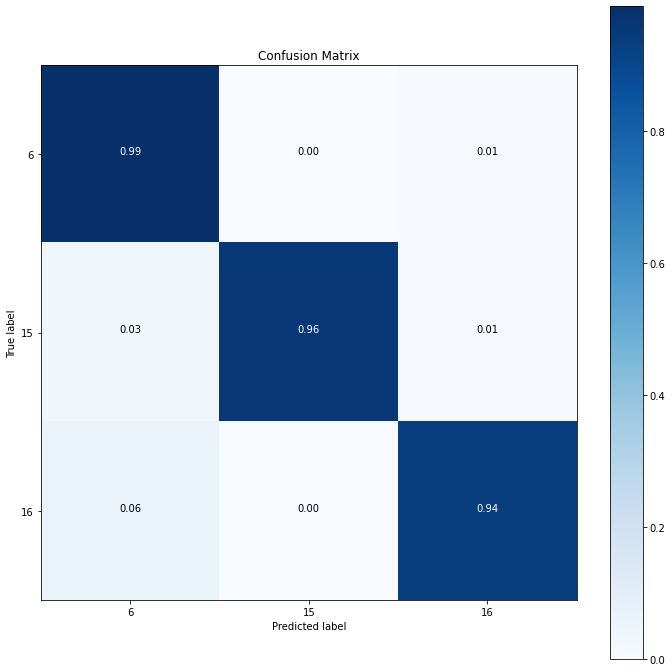


For number of classes: 4

X_train:  (1600, 105) , y_train:  (1600,) , X_test:  (400, 105) , y_test:  (400,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 18.49 seconds

Evaluation GP Model results:
Precision:  0.99
Recall:  0.99
F1-Score:  0.99
Accuracy:  0.99

Per Class Results:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       105
           1       1.00      0.99      1.00       105
           2       0.98      1.00      0.99        92
           3       0.99      1.00      0.99        98

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



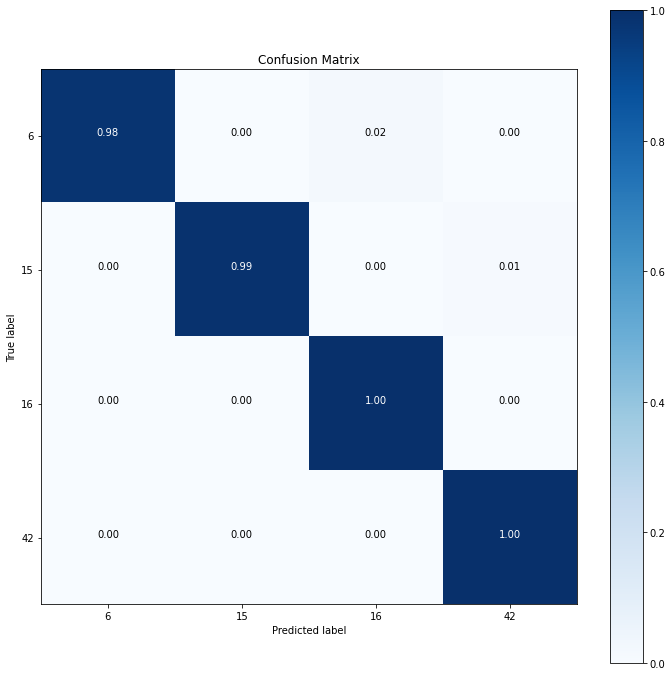


DL evaluation:

Model summary:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               54272     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 516       
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 120,452
Trainable params: 120,452
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3], y=[0 3 2 ... 2 3 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


50/50 [==============================] - 0s 2ms/step - loss: 2.0826 - accuracy: 0.9162 - val_loss: 1.6071 - val_accuracy: 0.9775
Epoch 2/500
50/50 [==============================] - 0s 991us/step - loss: 1.5046 - accuracy: 0.9694 - val_loss: 1.3519 - val_accuracy: 0.9575
Epoch 3/500
50/50 [==============================] - 0s 1ms/step - loss: 1.1717 - accuracy: 0.9663 - val_loss: 1.0452 - val_accuracy: 0.9850
Epoch 4/500
50/50 [==============================] - 0s 1ms/step - loss: 0.9548 - accuracy: 0.9706 - val_loss: 0.9535 - val_accuracy: 0.9675
Epoch 5/500
50/50 [==============================] - 0s 993us/step - loss: 0.9238 - accuracy: 0.9706 - val_loss: 0.7073 - val_accuracy: 0.9850
Epoch 6/500
50/50 [==============================] - 0s 993us/step - loss: 0.7481 - accuracy: 0.9700 - val_loss: 0.6458 - val_accuracy: 0.9850
Epoch 7/500
50/50 [==============================] - 0s 1ms/step - loss: 0.7241 - accuracy: 0.9744 - val_loss: 0.7073 - val_accuracy: 0.9850
Epoch 8/500
50/50 [

50/50 [==============================] - 0s 1ms/step - loss: 0.0988 - accuracy: 0.9906 - val_loss: 0.1643 - val_accuracy: 0.9850
Epoch 116/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0958 - accuracy: 0.9881 - val_loss: 0.1644 - val_accuracy: 0.9850
Epoch 117/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0950 - accuracy: 0.9869 - val_loss: 0.1871 - val_accuracy: 0.9825
Epoch 118/500
50/50 [==============================] - 0s 992us/step - loss: 0.0956 - accuracy: 0.9875 - val_loss: 0.1480 - val_accuracy: 0.9875
Epoch 119/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9875 - val_loss: 0.1402 - val_accuracy: 0.9900
Epoch 120/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0940 - accuracy: 0.9887 - val_loss: 0.1409 - val_accuracy: 0.9850
Epoch 121/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0923 - accuracy: 0.9881 - val_loss: 0.1433 - val_accuracy: 0.9875
Epoch 122/5

50/50 [==============================] - 0s 1ms/step - loss: 0.2018 - accuracy: 0.9837 - val_loss: 0.1765 - val_accuracy: 0.9925
Epoch 230/500
50/50 [==============================] - 0s 993us/step - loss: 0.1629 - accuracy: 0.9900 - val_loss: 0.1843 - val_accuracy: 0.9900
Epoch 231/500
50/50 [==============================] - 0s 1ms/step - loss: 0.1376 - accuracy: 0.9875 - val_loss: 0.1750 - val_accuracy: 0.9875
Epoch 232/500
50/50 [==============================] - 0s 989us/step - loss: 0.1969 - accuracy: 0.9862 - val_loss: 0.2890 - val_accuracy: 0.9925
Epoch 233/500
50/50 [==============================] - 0s 1ms/step - loss: 0.4375 - accuracy: 0.9800 - val_loss: 0.3765 - val_accuracy: 0.9825
Epoch 234/500
50/50 [==============================] - 0s 1ms/step - loss: 0.2773 - accuracy: 0.9881 - val_loss: 0.1603 - val_accuracy: 0.9925
Epoch 235/500
50/50 [==============================] - 0s 1ms/step - loss: 0.1548 - accuracy: 0.9887 - val_loss: 0.1602 - val_accuracy: 0.9875
Epoch 236

50/50 [==============================] - 0s 1ms/step - loss: 0.0840 - accuracy: 0.9900 - val_loss: 0.2838 - val_accuracy: 0.9875
Epoch 344/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0877 - accuracy: 0.9862 - val_loss: 0.2463 - val_accuracy: 0.9900
Epoch 345/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0786 - accuracy: 0.9919 - val_loss: 0.2392 - val_accuracy: 0.9850
Epoch 346/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0739 - accuracy: 0.9919 - val_loss: 0.1982 - val_accuracy: 0.9875
Epoch 347/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0717 - accuracy: 0.9919 - val_loss: 0.2030 - val_accuracy: 0.9825
Epoch 348/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0749 - accuracy: 0.9912 - val_loss: 0.1862 - val_accuracy: 0.9850
Epoch 349/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0769 - accuracy: 0.9919 - val_loss: 0.1662 - val_accuracy: 0.9925
Epoch 350/500

50/50 [==============================] - 0s 1ms/step - loss: 0.0766 - accuracy: 0.9906 - val_loss: 0.1878 - val_accuracy: 0.9875
Epoch 458/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0812 - accuracy: 0.9919 - val_loss: 0.1705 - val_accuracy: 0.9925
Epoch 459/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0756 - accuracy: 0.9919 - val_loss: 0.2054 - val_accuracy: 0.9900
Epoch 460/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0703 - accuracy: 0.9919 - val_loss: 0.1523 - val_accuracy: 0.9875
Epoch 461/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0715 - accuracy: 0.9944 - val_loss: 0.1594 - val_accuracy: 0.9900
Epoch 462/500
50/50 [==============================] - 0s 989us/step - loss: 0.1719 - accuracy: 0.9737 - val_loss: 0.2607 - val_accuracy: 0.9825
Epoch 463/500
50/50 [==============================] - 0s 1ms/step - loss: 1.3919 - accuracy: 0.9494 - val_loss: 1.8004 - val_accuracy: 0.9700
Epoch 464/5

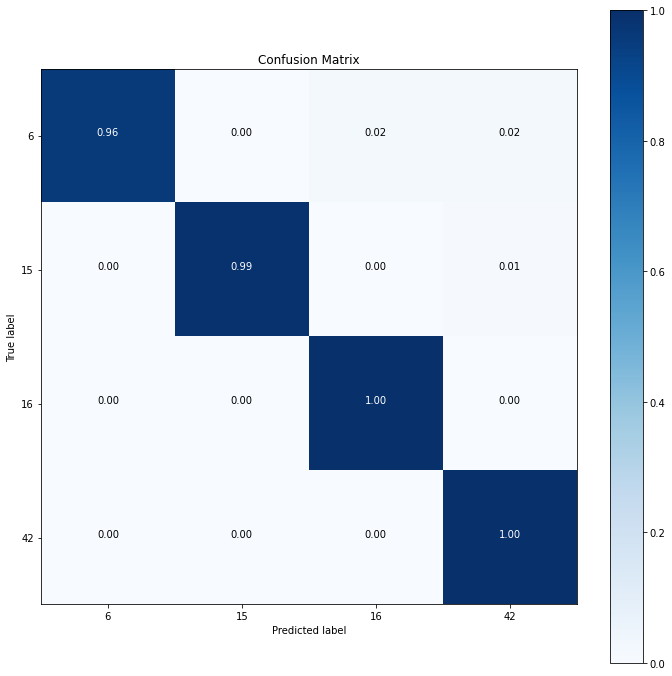


For number of classes: 5

X_train:  (2000, 105) , y_train:  (2000,) , X_test:  (500, 105) , y_test:  (500,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 29.21 seconds

Evaluation GP Model results:
Precision:  0.95
Recall:  0.94
F1-Score:  0.94
Accuracy:  0.94

Per Class Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       111
           1       1.00      0.96      0.98        97
           2       1.00      1.00      1.00        97
           3       0.90      0.84      0.87       112
           4       0.81      0.93      0.87        83

    accuracy                           0.94       500
   macro avg       0.94      0.95      0.94       500
weighted avg       0.95      0.94      0.94       500



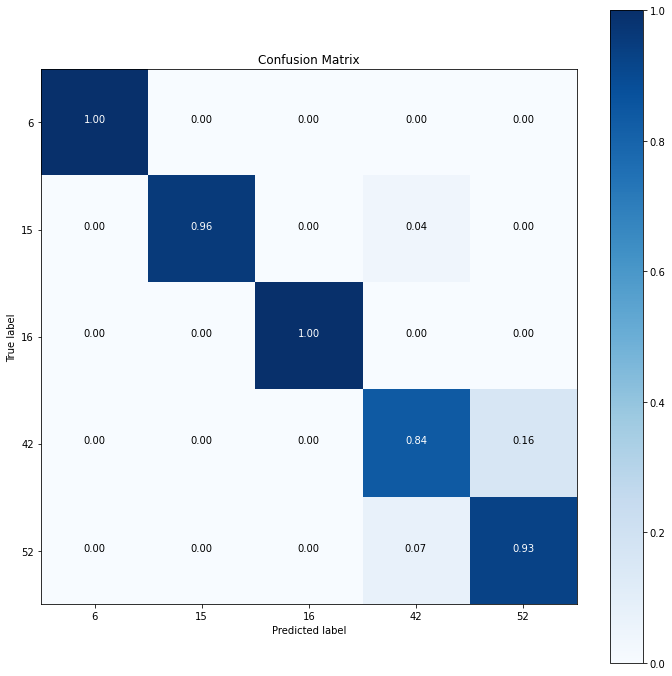


DL evaluation:

Model summary:
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               54272     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 645       
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0         
Total params: 120,581
Trainable params: 120,581
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4], y=[3 4 0 ... 2 3 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


63/63 [==============================] - 0s 2ms/step - loss: 2.2618 - accuracy: 0.8575 - val_loss: 1.9436 - val_accuracy: 0.8940
Epoch 2/500
63/63 [==============================] - 0s 1ms/step - loss: 1.6593 - accuracy: 0.8985 - val_loss: 1.5454 - val_accuracy: 0.9180
Epoch 3/500
63/63 [==============================] - 0s 1ms/step - loss: 1.2466 - accuracy: 0.9100 - val_loss: 1.2100 - val_accuracy: 0.9160
Epoch 4/500
63/63 [==============================] - 0s 1ms/step - loss: 1.0981 - accuracy: 0.9100 - val_loss: 0.9586 - val_accuracy: 0.9160
Epoch 5/500
63/63 [==============================] - 0s 1ms/step - loss: 0.9208 - accuracy: 0.9050 - val_loss: 0.9328 - val_accuracy: 0.9080
Epoch 6/500
63/63 [==============================] - 0s 1ms/step - loss: 0.8304 - accuracy: 0.9155 - val_loss: 0.7961 - val_accuracy: 0.9200
Epoch 7/500
63/63 [==============================] - 0s 1ms/step - loss: 0.7732 - accuracy: 0.9125 - val_loss: 0.7146 - val_accuracy: 0.9240
Epoch 8/500
63/63 [======

Epoch 59/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2999 - accuracy: 0.9270 - val_loss: 0.3441 - val_accuracy: 0.9320
Epoch 60/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3061 - accuracy: 0.9300 - val_loss: 0.3489 - val_accuracy: 0.9280
Epoch 61/500
63/63 [==============================] - 0s 1ms/step - loss: 0.3525 - accuracy: 0.9190 - val_loss: 0.7090 - val_accuracy: 0.9180
Epoch 62/500
63/63 [==============================] - 0s 1ms/step - loss: 0.6591 - accuracy: 0.9145 - val_loss: 0.3846 - val_accuracy: 0.9260
Epoch 63/500
63/63 [==============================] - 0s 1ms/step - loss: 0.4497 - accuracy: 0.9215 - val_loss: 0.6112 - val_accuracy: 0.9300
Epoch 64/500
63/63 [==============================] - 0s 1ms/step - loss: 0.3967 - accuracy: 0.9200 - val_loss: 0.9891 - val_accuracy: 0.9020
Epoch 65/500
63/63 [==============================] - 0s 1ms/step - loss: 0.4795 - accuracy: 0.9170 - val_loss: 0.4342 - val_accuracy: 0.9320
Epoch 

63/63 [==============================] - 0s 1ms/step - loss: 0.2365 - accuracy: 0.9355 - val_loss: 0.4726 - val_accuracy: 0.9380
Epoch 174/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2747 - accuracy: 0.9285 - val_loss: 0.4233 - val_accuracy: 0.9040
Epoch 175/500
63/63 [==============================] - 0s 1ms/step - loss: 0.3367 - accuracy: 0.9245 - val_loss: 0.4097 - val_accuracy: 0.9320
Epoch 176/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2677 - accuracy: 0.9295 - val_loss: 0.3330 - val_accuracy: 0.9420
Epoch 177/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2377 - accuracy: 0.9395 - val_loss: 0.3159 - val_accuracy: 0.9380
Epoch 178/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2738 - accuracy: 0.9300 - val_loss: 0.4211 - val_accuracy: 0.9280
Epoch 179/500
63/63 [==============================] - 0s 1ms/step - loss: 0.3790 - accuracy: 0.9360 - val_loss: 0.4403 - val_accuracy: 0.9420
Epoch 180/500

63/63 [==============================] - 0s 1ms/step - loss: 0.2020 - accuracy: 0.9400 - val_loss: 0.4269 - val_accuracy: 0.9400
Epoch 288/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2014 - accuracy: 0.9400 - val_loss: 0.3352 - val_accuracy: 0.9400
Epoch 289/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2099 - accuracy: 0.9380 - val_loss: 0.3530 - val_accuracy: 0.9320
Epoch 290/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2031 - accuracy: 0.9380 - val_loss: 0.3555 - val_accuracy: 0.9400
Epoch 291/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2015 - accuracy: 0.9395 - val_loss: 0.3417 - val_accuracy: 0.9420
Epoch 292/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2054 - accuracy: 0.9370 - val_loss: 0.3840 - val_accuracy: 0.9400
Epoch 293/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2437 - accuracy: 0.9350 - val_loss: 0.3301 - val_accuracy: 0.9380
Epoch 294/500

63/63 [==============================] - 0s 1ms/step - loss: 0.2507 - accuracy: 0.9455 - val_loss: 0.2629 - val_accuracy: 0.9400
Epoch 402/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2322 - accuracy: 0.9425 - val_loss: 0.2946 - val_accuracy: 0.9320
Epoch 403/500
63/63 [==============================] - 0s 1ms/step - loss: 0.3036 - accuracy: 0.9350 - val_loss: 0.4034 - val_accuracy: 0.9260
Epoch 404/500
63/63 [==============================] - 0s 1ms/step - loss: 0.3313 - accuracy: 0.9285 - val_loss: 0.4893 - val_accuracy: 0.9420
Epoch 405/500
63/63 [==============================] - 0s 1ms/step - loss: 0.3997 - accuracy: 0.9255 - val_loss: 0.2982 - val_accuracy: 0.9300
Epoch 406/500
63/63 [==============================] - 0s 1ms/step - loss: 0.4020 - accuracy: 0.9365 - val_loss: 0.3385 - val_accuracy: 0.9360
Epoch 407/500
63/63 [==============================] - 0s 1ms/step - loss: 0.4047 - accuracy: 0.9255 - val_loss: 1.5360 - val_accuracy: 0.9400
Epoch 408/500

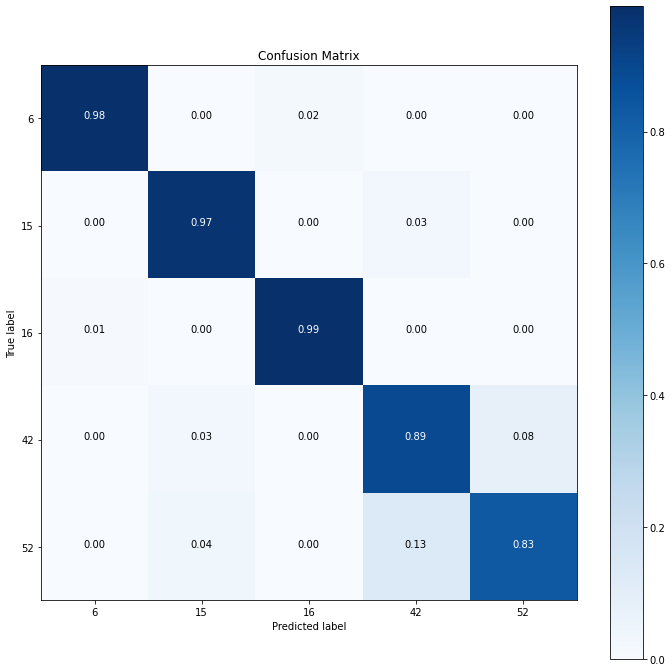


For number of classes: 6

X_train:  (2400, 105) , y_train:  (2400,) , X_test:  (600, 105) , y_test:  (600,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 39.49 seconds

Evaluation GP Model results:
Precision:  0.92
Recall:  0.92
F1-Score:  0.92
Accuracy:  0.92

Per Class Results:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       100
           1       0.95      0.96      0.95        96
           2       0.99      0.97      0.98        99
           3       0.84      0.83      0.84        95
           4       0.84      0.85      0.84       115
           5       0.98      0.96      0.97        95

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600



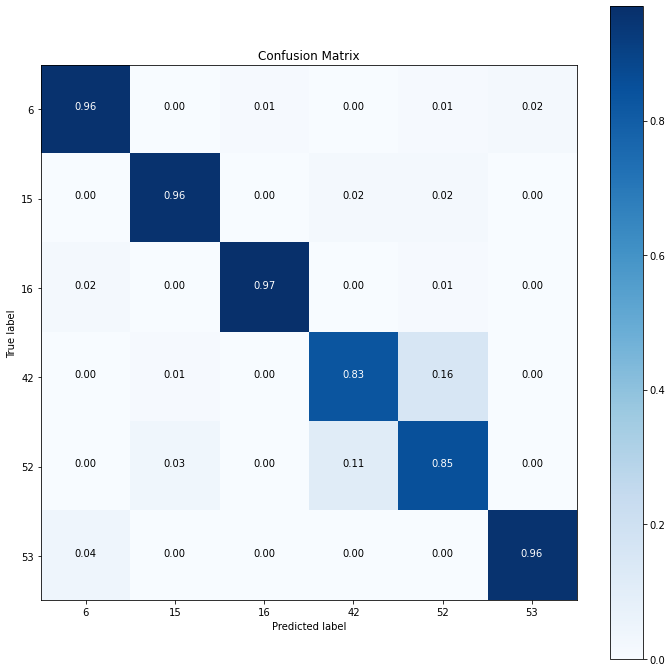


DL evaluation:

Model summary:
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               54272     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 774       
_________________________________________________________________
activation_3 (Activation)    (None, 6)                 0         
Total params: 120,710
Trainable params: 120,710
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4 5], y=[3 2 3 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


75/75 [==============================] - 0s 2ms/step - loss: 2.3462 - accuracy: 0.8662 - val_loss: 1.7232 - val_accuracy: 0.8767
Epoch 2/500
75/75 [==============================] - 0s 952us/step - loss: 1.5347 - accuracy: 0.9079 - val_loss: 1.3515 - val_accuracy: 0.8667
Epoch 3/500
75/75 [==============================] - 0s 948us/step - loss: 1.2007 - accuracy: 0.9133 - val_loss: 1.0537 - val_accuracy: 0.8867
Epoch 4/500
75/75 [==============================] - 0s 940us/step - loss: 1.0476 - accuracy: 0.9058 - val_loss: 0.8587 - val_accuracy: 0.9100
Epoch 5/500
75/75 [==============================] - 0s 932us/step - loss: 0.7824 - accuracy: 0.9179 - val_loss: 0.7595 - val_accuracy: 0.8800
Epoch 6/500
75/75 [==============================] - 0s 1ms/step - loss: 0.7326 - accuracy: 0.9162 - val_loss: 0.6485 - val_accuracy: 0.8950
Epoch 7/500
75/75 [==============================] - 0s 937us/step - loss: 0.6312 - accuracy: 0.9212 - val_loss: 0.5956 - val_accuracy: 0.8983
Epoch 8/500
75/

75/75 [==============================] - 0s 963us/step - loss: 0.2826 - accuracy: 0.9433 - val_loss: 0.3201 - val_accuracy: 0.9150
Epoch 116/500
75/75 [==============================] - 0s 1ms/step - loss: 0.2781 - accuracy: 0.9413 - val_loss: 0.3026 - val_accuracy: 0.9167
Epoch 117/500
75/75 [==============================] - 0s 971us/step - loss: 0.3169 - accuracy: 0.9417 - val_loss: 0.3889 - val_accuracy: 0.8850
Epoch 118/500
75/75 [==============================] - 0s 924us/step - loss: 0.3220 - accuracy: 0.9325 - val_loss: 0.3307 - val_accuracy: 0.9133
Epoch 119/500
75/75 [==============================] - 0s 984us/step - loss: 0.2672 - accuracy: 0.9463 - val_loss: 0.3035 - val_accuracy: 0.9133
Epoch 120/500
75/75 [==============================] - 0s 972us/step - loss: 0.2372 - accuracy: 0.9454 - val_loss: 0.3223 - val_accuracy: 0.9083
Epoch 121/500
75/75 [==============================] - 0s 977us/step - loss: 0.2288 - accuracy: 0.9417 - val_loss: 0.2974 - val_accuracy: 0.9133
E

Epoch 172/500
75/75 [==============================] - 0s 1ms/step - loss: 0.2085 - accuracy: 0.9442 - val_loss: 0.2590 - val_accuracy: 0.9150
Epoch 173/500
75/75 [==============================] - 0s 970us/step - loss: 0.2063 - accuracy: 0.9400 - val_loss: 0.2585 - val_accuracy: 0.9167
Epoch 174/500
75/75 [==============================] - 0s 1ms/step - loss: 0.2069 - accuracy: 0.9429 - val_loss: 0.2760 - val_accuracy: 0.9117
Epoch 175/500
75/75 [==============================] - 0s 937us/step - loss: 0.2089 - accuracy: 0.9413 - val_loss: 0.2594 - val_accuracy: 0.9067
Epoch 176/500
75/75 [==============================] - 0s 946us/step - loss: 0.1984 - accuracy: 0.9492 - val_loss: 0.2614 - val_accuracy: 0.9050
Epoch 177/500
75/75 [==============================] - 0s 1ms/step - loss: 0.1973 - accuracy: 0.9425 - val_loss: 0.2794 - val_accuracy: 0.8983
Epoch 178/500
75/75 [==============================] - 0s 943us/step - loss: 0.2020 - accuracy: 0.9429 - val_loss: 0.2548 - val_accuracy

Epoch 229/500
75/75 [==============================] - 0s 1ms/step - loss: 0.1864 - accuracy: 0.9492 - val_loss: 0.2488 - val_accuracy: 0.9100
Epoch 230/500
75/75 [==============================] - 0s 927us/step - loss: 0.1964 - accuracy: 0.9408 - val_loss: 0.2587 - val_accuracy: 0.9117
Epoch 231/500
75/75 [==============================] - 0s 938us/step - loss: 0.1903 - accuracy: 0.9479 - val_loss: 0.2502 - val_accuracy: 0.9183
Epoch 232/500
75/75 [==============================] - 0s 1ms/step - loss: 0.1962 - accuracy: 0.9467 - val_loss: 0.2461 - val_accuracy: 0.9133
Epoch 233/500
75/75 [==============================] - 0s 984us/step - loss: 0.1882 - accuracy: 0.9467 - val_loss: 0.2372 - val_accuracy: 0.9250
Epoch 234/500
75/75 [==============================] - 0s 1ms/step - loss: 0.1911 - accuracy: 0.9438 - val_loss: 0.2407 - val_accuracy: 0.9150
Epoch 235/500
75/75 [==============================] - 0s 990us/step - loss: 0.1858 - accuracy: 0.9521 - val_loss: 0.2445 - val_accuracy

Epoch 286/500
75/75 [==============================] - 0s 977us/step - loss: 0.1860 - accuracy: 0.9471 - val_loss: 0.2550 - val_accuracy: 0.9150
Epoch 287/500
75/75 [==============================] - 0s 946us/step - loss: 0.1828 - accuracy: 0.9504 - val_loss: 0.2537 - val_accuracy: 0.9133
Epoch 288/500
75/75 [==============================] - 0s 884us/step - loss: 0.1814 - accuracy: 0.9483 - val_loss: 0.2543 - val_accuracy: 0.9167
Epoch 289/500
75/75 [==============================] - 0s 943us/step - loss: 0.1840 - accuracy: 0.9467 - val_loss: 0.2509 - val_accuracy: 0.9150
Epoch 290/500
75/75 [==============================] - 0s 1ms/step - loss: 0.1861 - accuracy: 0.9446 - val_loss: 0.2461 - val_accuracy: 0.9133
Epoch 291/500
75/75 [==============================] - 0s 960us/step - loss: 0.1837 - accuracy: 0.9488 - val_loss: 0.2492 - val_accuracy: 0.9150
Epoch 292/500
75/75 [==============================] - 0s 1ms/step - loss: 0.1832 - accuracy: 0.9471 - val_loss: 0.2544 - val_accura

Epoch 343/500
75/75 [==============================] - 0s 994us/step - loss: 0.5582 - accuracy: 0.9200 - val_loss: 0.3939 - val_accuracy: 0.9017
Epoch 344/500
75/75 [==============================] - 0s 987us/step - loss: 0.3990 - accuracy: 0.9271 - val_loss: 0.3115 - val_accuracy: 0.9167
Epoch 345/500
75/75 [==============================] - 0s 967us/step - loss: 0.2933 - accuracy: 0.9362 - val_loss: 0.3113 - val_accuracy: 0.9100
Epoch 346/500
75/75 [==============================] - 0s 989us/step - loss: 0.2510 - accuracy: 0.9392 - val_loss: 0.2886 - val_accuracy: 0.9083
Epoch 347/500
75/75 [==============================] - 0s 1ms/step - loss: 0.2239 - accuracy: 0.9442 - val_loss: 0.2616 - val_accuracy: 0.9117
Epoch 348/500
75/75 [==============================] - 0s 931us/step - loss: 0.2123 - accuracy: 0.9429 - val_loss: 0.2611 - val_accuracy: 0.9133
Epoch 349/500
75/75 [==============================] - 0s 928us/step - loss: 0.2061 - accuracy: 0.9438 - val_loss: 0.2674 - val_accu

Epoch 400/500
75/75 [==============================] - 0s 966us/step - loss: 0.1861 - accuracy: 0.9479 - val_loss: 0.2675 - val_accuracy: 0.9083
Epoch 401/500
75/75 [==============================] - 0s 929us/step - loss: 0.1935 - accuracy: 0.9454 - val_loss: 0.2761 - val_accuracy: 0.9150
Epoch 402/500
75/75 [==============================] - 0s 1ms/step - loss: 0.1885 - accuracy: 0.9458 - val_loss: 0.2807 - val_accuracy: 0.9133
Epoch 403/500
75/75 [==============================] - 0s 1ms/step - loss: 0.1878 - accuracy: 0.9525 - val_loss: 0.2694 - val_accuracy: 0.9117
Epoch 404/500
75/75 [==============================] - 0s 999us/step - loss: 0.1853 - accuracy: 0.9492 - val_loss: 0.2574 - val_accuracy: 0.9167
Epoch 405/500
75/75 [==============================] - 0s 978us/step - loss: 0.1861 - accuracy: 0.9488 - val_loss: 0.2542 - val_accuracy: 0.9133
Epoch 406/500
75/75 [==============================] - 0s 1ms/step - loss: 0.2023 - accuracy: 0.9408 - val_loss: 0.2475 - val_accuracy

Epoch 457/500
75/75 [==============================] - 0s 1ms/step - loss: 0.1807 - accuracy: 0.9483 - val_loss: 0.2620 - val_accuracy: 0.9150
Epoch 458/500
75/75 [==============================] - 0s 1ms/step - loss: 0.1796 - accuracy: 0.9525 - val_loss: 0.2682 - val_accuracy: 0.9150
Epoch 459/500
75/75 [==============================] - 0s 1ms/step - loss: 0.1800 - accuracy: 0.9458 - val_loss: 0.2563 - val_accuracy: 0.9217
Epoch 460/500
75/75 [==============================] - 0s 933us/step - loss: 0.1781 - accuracy: 0.9500 - val_loss: 0.2682 - val_accuracy: 0.9100
Epoch 461/500
75/75 [==============================] - 0s 1ms/step - loss: 0.1765 - accuracy: 0.9513 - val_loss: 0.2622 - val_accuracy: 0.9133
Epoch 462/500
75/75 [==============================] - 0s 935us/step - loss: 0.1927 - accuracy: 0.9492 - val_loss: 0.2542 - val_accuracy: 0.9167
Epoch 463/500
75/75 [==============================] - 0s 1ms/step - loss: 0.1853 - accuracy: 0.9471 - val_loss: 0.2495 - val_accuracy: 0.

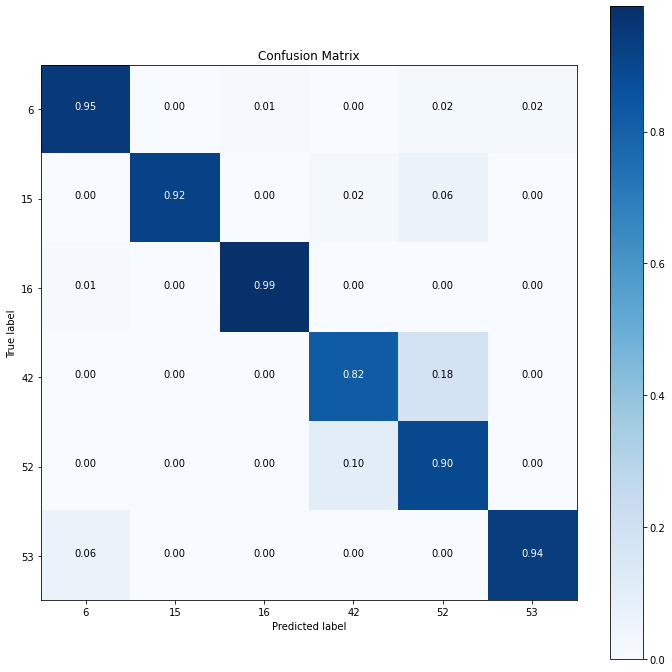


For number of classes: 7

X_train:  (2800, 105) , y_train:  (2800,) , X_test:  (700, 105) , y_test:  (700,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 57.71 seconds

Evaluation GP Model results:
Precision:  0.9
Recall:  0.9
F1-Score:  0.9
Accuracy:  0.9

Per Class Results:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       112
           1       1.00      0.98      0.99        90
           2       0.99      0.97      0.98        95
           3       0.85      0.83      0.84       104
           4       0.85      0.78      0.81        92
           5       0.95      0.96      0.96       110
           6       0.72      0.81      0.76        97

    accuracy                           0.90       700
   macro avg       0.90      0.90      0.90       700
weighted avg       0.90      0.90      0.90       700



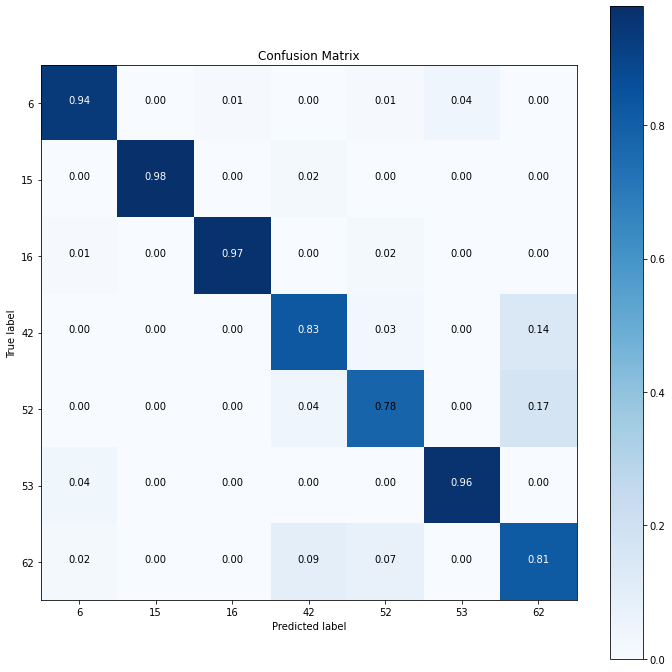


DL evaluation:

Model summary:
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               54272     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_14 (Dense)             (None, 7)                 903       
_________________________________________________________________
activation_4 (Activation)    (None, 7)                 0         
Total params: 120,839
Trainable params: 120,839
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4 5 6], y=[5 1 3 ... 0 4 5] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


88/88 [==============================] - 0s 2ms/step - loss: 2.2557 - accuracy: 0.8014 - val_loss: 1.6972 - val_accuracy: 0.8629
Epoch 2/500
88/88 [==============================] - 0s 1ms/step - loss: 1.5093 - accuracy: 0.8421 - val_loss: 1.2466 - val_accuracy: 0.8571
Epoch 3/500
88/88 [==============================] - 0s 1ms/step - loss: 1.2033 - accuracy: 0.8586 - val_loss: 1.0073 - val_accuracy: 0.8686
Epoch 4/500
88/88 [==============================] - 0s 1ms/step - loss: 0.9656 - accuracy: 0.8621 - val_loss: 0.9534 - val_accuracy: 0.8500
Epoch 5/500
88/88 [==============================] - 0s 1ms/step - loss: 0.8416 - accuracy: 0.8614 - val_loss: 0.7483 - val_accuracy: 0.8586
Epoch 6/500
88/88 [==============================] - 0s 1ms/step - loss: 0.7572 - accuracy: 0.8614 - val_loss: 0.7089 - val_accuracy: 0.8643
Epoch 7/500
88/88 [==============================] - 0s 1ms/step - loss: 0.6874 - accuracy: 0.8639 - val_loss: 0.6462 - val_accuracy: 0.8557
Epoch 8/500
88/88 [======

Epoch 59/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3850 - accuracy: 0.8854 - val_loss: 0.4011 - val_accuracy: 0.8843
Epoch 60/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3829 - accuracy: 0.8818 - val_loss: 0.3868 - val_accuracy: 0.8829
Epoch 61/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3926 - accuracy: 0.8818 - val_loss: 0.4105 - val_accuracy: 0.8771
Epoch 62/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3941 - accuracy: 0.8811 - val_loss: 0.3951 - val_accuracy: 0.8829
Epoch 63/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3862 - accuracy: 0.8782 - val_loss: 0.3927 - val_accuracy: 0.8786
Epoch 64/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3810 - accuracy: 0.8861 - val_loss: 0.3857 - val_accuracy: 0.8757
Epoch 65/500
88/88 [==============================] - 0s 2ms/step - loss: 0.3746 - accuracy: 0.8800 - val_loss: 0.3780 - val_accuracy: 0.8843
Epoch 

88/88 [==============================] - 0s 1ms/step - loss: 0.3507 - accuracy: 0.8893 - val_loss: 0.3708 - val_accuracy: 0.8857
Epoch 174/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3553 - accuracy: 0.8864 - val_loss: 0.3868 - val_accuracy: 0.8814
Epoch 175/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3556 - accuracy: 0.8843 - val_loss: 0.3611 - val_accuracy: 0.8843
Epoch 176/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3453 - accuracy: 0.8921 - val_loss: 0.3556 - val_accuracy: 0.8829
Epoch 177/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3459 - accuracy: 0.8871 - val_loss: 0.3621 - val_accuracy: 0.8814
Epoch 178/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3431 - accuracy: 0.8850 - val_loss: 0.3582 - val_accuracy: 0.8857
Epoch 179/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3417 - accuracy: 0.8896 - val_loss: 0.3568 - val_accuracy: 0.8857
Epoch 180/500

88/88 [==============================] - 0s 1ms/step - loss: 0.3299 - accuracy: 0.8871 - val_loss: 0.3704 - val_accuracy: 0.8786
Epoch 288/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3274 - accuracy: 0.8914 - val_loss: 0.3402 - val_accuracy: 0.8829
Epoch 289/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3295 - accuracy: 0.8904 - val_loss: 0.3857 - val_accuracy: 0.8771
Epoch 290/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3361 - accuracy: 0.8896 - val_loss: 0.3683 - val_accuracy: 0.8886
Epoch 291/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3361 - accuracy: 0.8886 - val_loss: 0.3742 - val_accuracy: 0.8714
Epoch 292/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3375 - accuracy: 0.8807 - val_loss: 0.3585 - val_accuracy: 0.8857
Epoch 293/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3328 - accuracy: 0.8904 - val_loss: 0.3545 - val_accuracy: 0.8871
Epoch 294/500

88/88 [==============================] - 0s 1ms/step - loss: 0.3777 - accuracy: 0.8882 - val_loss: 0.3854 - val_accuracy: 0.8929
Epoch 402/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3536 - accuracy: 0.8886 - val_loss: 0.3700 - val_accuracy: 0.8886
Epoch 403/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3463 - accuracy: 0.8896 - val_loss: 0.3502 - val_accuracy: 0.8886
Epoch 404/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3398 - accuracy: 0.8921 - val_loss: 0.3557 - val_accuracy: 0.8871
Epoch 405/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3596 - accuracy: 0.8871 - val_loss: 0.3657 - val_accuracy: 0.8843
Epoch 406/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3418 - accuracy: 0.8875 - val_loss: 0.3528 - val_accuracy: 0.8814
Epoch 407/500
88/88 [==============================] - 0s 1ms/step - loss: 0.3352 - accuracy: 0.8900 - val_loss: 0.3609 - val_accuracy: 0.8829
Epoch 408/500

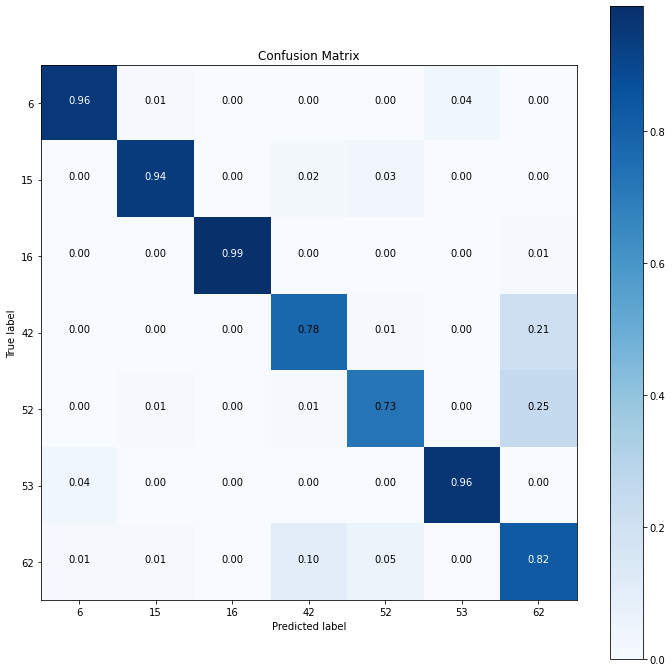


For number of classes: 8

X_train:  (3200, 105) , y_train:  (3200,) , X_test:  (800, 105) , y_test:  (800,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 82.74 seconds

Evaluation GP Model results:
Precision:  0.9
Recall:  0.89
F1-Score:  0.89
Accuracy:  0.89

Per Class Results:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        95
           1       1.00      0.95      0.97        95
           2       0.99      0.98      0.98        92
           3       0.80      0.76      0.78       108
           4       0.83      0.72      0.77       109
           5       0.98      0.98      0.98        89
           6       0.67      0.83      0.74        98
           7       0.97      0.96      0.97       114

    accuracy                           0.89       800
   macro avg       0.90      0.89      0.89       800
weighted avg       0.90      0.89      0.89       800



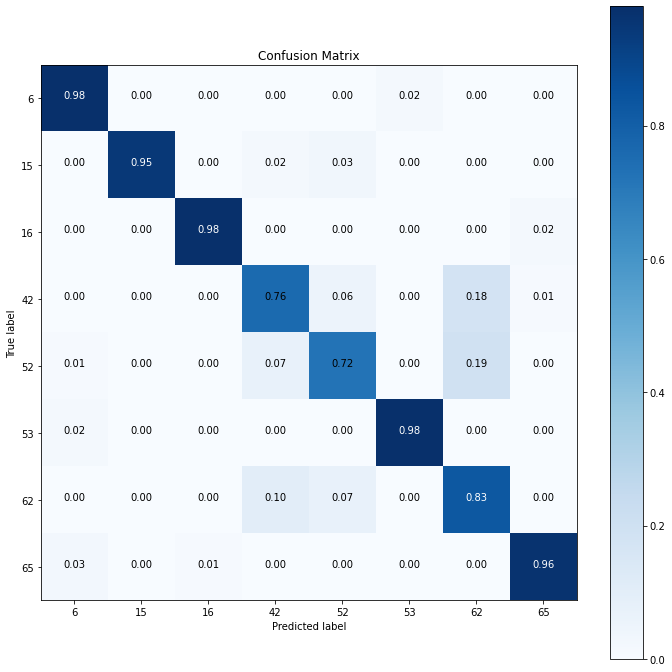


DL evaluation:

Model summary:
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               54272     
_________________________________________________________________
dense_16 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 1032      
_________________________________________________________________
activation_5 (Activation)    (None, 8)                 0         
Total params: 120,968
Trainable params: 120,968
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7], y=[1 4 6 ... 0 1 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


100/100 [==============================] - 0s 3ms/step - loss: 2.4283 - accuracy: 0.7897 - val_loss: 1.8294 - val_accuracy: 0.8388
Epoch 2/500
100/100 [==============================] - 0s 1ms/step - loss: 1.5742 - accuracy: 0.8431 - val_loss: 1.5476 - val_accuracy: 0.8438
Epoch 3/500
100/100 [==============================] - 0s 968us/step - loss: 1.4173 - accuracy: 0.8422 - val_loss: 1.2137 - val_accuracy: 0.8313
Epoch 4/500
100/100 [==============================] - 0s 1ms/step - loss: 1.1465 - accuracy: 0.8447 - val_loss: 1.0306 - val_accuracy: 0.8450
Epoch 5/500
100/100 [==============================] - 0s 1ms/step - loss: 0.9591 - accuracy: 0.8503 - val_loss: 0.8604 - val_accuracy: 0.8525
Epoch 6/500
100/100 [==============================] - 0s 884us/step - loss: 0.8754 - accuracy: 0.8466 - val_loss: 0.8063 - val_accuracy: 0.8475
Epoch 7/500
100/100 [==============================] - 0s 985us/step - loss: 0.8026 - accuracy: 0.8406 - val_loss: 0.7561 - val_accuracy: 0.8525
Epoch

100/100 [==============================] - 0s 937us/step - loss: 1.0862 - accuracy: 0.8344 - val_loss: 1.6910 - val_accuracy: 0.8275
Epoch 114/500
100/100 [==============================] - 0s 870us/step - loss: 0.8446 - accuracy: 0.8622 - val_loss: 0.5786 - val_accuracy: 0.8537
Epoch 115/500
100/100 [==============================] - 0s 896us/step - loss: 0.7889 - accuracy: 0.8653 - val_loss: 1.0030 - val_accuracy: 0.8250
Epoch 116/500
100/100 [==============================] - 0s 887us/step - loss: 1.7035 - accuracy: 0.8288 - val_loss: 0.8085 - val_accuracy: 0.8550
Epoch 117/500
100/100 [==============================] - 0s 869us/step - loss: 0.6266 - accuracy: 0.8612 - val_loss: 0.5415 - val_accuracy: 0.8712
Epoch 118/500
100/100 [==============================] - 0s 906us/step - loss: 0.8162 - accuracy: 0.8637 - val_loss: 0.5368 - val_accuracy: 0.8662
Epoch 119/500
100/100 [==============================] - 0s 898us/step - loss: 0.4968 - accuracy: 0.8750 - val_loss: 0.8295 - val_ac

Epoch 169/500
100/100 [==============================] - 0s 960us/step - loss: 0.4145 - accuracy: 0.8850 - val_loss: 0.4199 - val_accuracy: 0.8737
Epoch 170/500
100/100 [==============================] - 0s 974us/step - loss: 0.4013 - accuracy: 0.8881 - val_loss: 0.4089 - val_accuracy: 0.8750
Epoch 171/500
100/100 [==============================] - 0s 923us/step - loss: 0.3893 - accuracy: 0.8859 - val_loss: 0.3976 - val_accuracy: 0.8662
Epoch 172/500
100/100 [==============================] - 0s 1ms/step - loss: 0.4360 - accuracy: 0.8916 - val_loss: 0.6053 - val_accuracy: 0.8725
Epoch 173/500
100/100 [==============================] - 0s 952us/step - loss: 0.4699 - accuracy: 0.8822 - val_loss: 0.4055 - val_accuracy: 0.8687
Epoch 174/500
100/100 [==============================] - 0s 948us/step - loss: 0.3901 - accuracy: 0.8872 - val_loss: 0.3888 - val_accuracy: 0.8700
Epoch 175/500
100/100 [==============================] - 0s 984us/step - loss: 0.3913 - accuracy: 0.8850 - val_loss: 0.3

Epoch 280/500
100/100 [==============================] - 0s 951us/step - loss: 0.3583 - accuracy: 0.8869 - val_loss: 0.3676 - val_accuracy: 0.8763
Epoch 281/500
100/100 [==============================] - 0s 987us/step - loss: 0.3577 - accuracy: 0.8872 - val_loss: 0.3662 - val_accuracy: 0.8687
Epoch 282/500
100/100 [==============================] - 0s 1ms/step - loss: 0.3704 - accuracy: 0.8894 - val_loss: 0.3760 - val_accuracy: 0.8700
Epoch 283/500
100/100 [==============================] - 0s 947us/step - loss: 0.3613 - accuracy: 0.8894 - val_loss: 0.3940 - val_accuracy: 0.8775
Epoch 284/500
100/100 [==============================] - 0s 978us/step - loss: 0.3656 - accuracy: 0.8856 - val_loss: 0.3732 - val_accuracy: 0.8712
Epoch 285/500
100/100 [==============================] - 0s 1ms/step - loss: 0.7508 - accuracy: 0.8544 - val_loss: 0.9962 - val_accuracy: 0.8075
Epoch 286/500
100/100 [==============================] - 0s 992us/step - loss: 2.4369 - accuracy: 0.8031 - val_loss: 1.296

100/100 [==============================] - 0s 953us/step - loss: 0.3717 - accuracy: 0.8838 - val_loss: 0.3655 - val_accuracy: 0.8800
Epoch 337/500
100/100 [==============================] - 0s 917us/step - loss: 0.3616 - accuracy: 0.8916 - val_loss: 0.3496 - val_accuracy: 0.8750
Epoch 338/500
100/100 [==============================] - 0s 1ms/step - loss: 0.3551 - accuracy: 0.8922 - val_loss: 0.3577 - val_accuracy: 0.8775
Epoch 339/500
100/100 [==============================] - 0s 943us/step - loss: 0.3476 - accuracy: 0.8928 - val_loss: 0.3646 - val_accuracy: 0.8763
Epoch 340/500
100/100 [==============================] - 0s 987us/step - loss: 0.3496 - accuracy: 0.8903 - val_loss: 0.3617 - val_accuracy: 0.8737
Epoch 341/500
100/100 [==============================] - 0s 963us/step - loss: 0.3444 - accuracy: 0.8922 - val_loss: 0.3689 - val_accuracy: 0.8712
Epoch 342/500
100/100 [==============================] - 0s 940us/step - loss: 0.3495 - accuracy: 0.8925 - val_loss: 0.3813 - val_accu

100/100 [==============================] - 0s 891us/step - loss: 0.3430 - accuracy: 0.8931 - val_loss: 0.3681 - val_accuracy: 0.8775
Epoch 393/500
100/100 [==============================] - 0s 886us/step - loss: 0.3407 - accuracy: 0.8944 - val_loss: 0.3615 - val_accuracy: 0.8725
Epoch 394/500
100/100 [==============================] - 0s 949us/step - loss: 0.4144 - accuracy: 0.8888 - val_loss: 0.5409 - val_accuracy: 0.8425
Epoch 395/500
100/100 [==============================] - 0s 923us/step - loss: 0.6716 - accuracy: 0.8597 - val_loss: 0.5292 - val_accuracy: 0.8700
Epoch 396/500
100/100 [==============================] - 0s 930us/step - loss: 2.8169 - accuracy: 0.8147 - val_loss: 3.7511 - val_accuracy: 0.7550
Epoch 397/500
100/100 [==============================] - 0s 925us/step - loss: 2.8985 - accuracy: 0.8325 - val_loss: 4.0007 - val_accuracy: 0.8475
Epoch 398/500
100/100 [==============================] - 0s 911us/step - loss: 1.2667 - accuracy: 0.8569 - val_loss: 2.4561 - val_ac

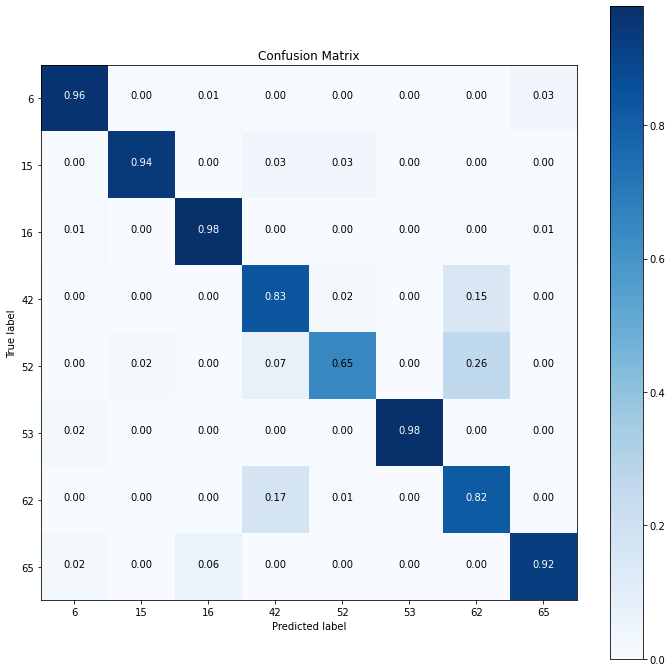


For number of classes: 9

X_train:  (3600, 105) , y_train:  (3600,) , X_test:  (900, 105) , y_test:  (900,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 105.53 seconds

Evaluation GP Model results:
Precision:  0.84
Recall:  0.82
F1-Score:  0.82
Accuracy:  0.82

Per Class Results:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       111
           1       0.87      0.93      0.90        83
           2       0.96      0.97      0.96       112
           3       0.79      0.68      0.73        97
           4       0.76      0.55      0.64       103
           5       0.96      0.94      0.95       102
           6       0.53      0.80      0.64        97
           7       0.95      0.93      0.94       104
           8       0.82      0.66      0.73        91

    accuracy                           0.82       900
   macro avg       0.83      0.82      0.82       900
weighted avg       0.84      0.82      0.82       900



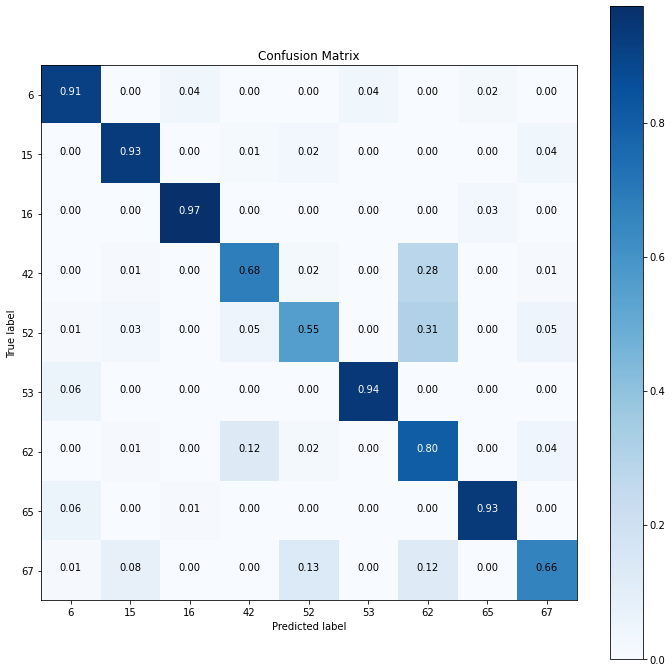


DL evaluation:

Model summary:
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 512)               54272     
_________________________________________________________________
dense_19 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_20 (Dense)             (None, 9)                 1161      
_________________________________________________________________
activation_6 (Activation)    (None, 9)                 0         
Total params: 121,097
Trainable params: 121,097
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7 8], y=[6 5 4 ... 7 2 6] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


113/113 [==============================] - 0s 2ms/step - loss: 2.5573 - accuracy: 0.7439 - val_loss: 1.9559 - val_accuracy: 0.7722
Epoch 2/500
113/113 [==============================] - 0s 1ms/step - loss: 1.6913 - accuracy: 0.8006 - val_loss: 1.5226 - val_accuracy: 0.7511
Epoch 3/500
113/113 [==============================] - 0s 1ms/step - loss: 1.3734 - accuracy: 0.8036 - val_loss: 1.2479 - val_accuracy: 0.7833
Epoch 4/500
113/113 [==============================] - 0s 1ms/step - loss: 1.0966 - accuracy: 0.8119 - val_loss: 1.0427 - val_accuracy: 0.7722
Epoch 5/500
113/113 [==============================] - 0s 1ms/step - loss: 0.9297 - accuracy: 0.8142 - val_loss: 0.9346 - val_accuracy: 0.7844
Epoch 6/500
113/113 [==============================] - 0s 1ms/step - loss: 0.8327 - accuracy: 0.8150 - val_loss: 0.8793 - val_accuracy: 0.7844
Epoch 7/500
113/113 [==============================] - 0s 1ms/step - loss: 0.8653 - accuracy: 0.8150 - val_loss: 0.8544 - val_accuracy: 0.7767
Epoch 8/500

113/113 [==============================] - 0s 1ms/step - loss: 0.5095 - accuracy: 0.8375 - val_loss: 0.5734 - val_accuracy: 0.7956
Epoch 59/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4969 - accuracy: 0.8419 - val_loss: 0.5714 - val_accuracy: 0.8144
Epoch 60/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4930 - accuracy: 0.8425 - val_loss: 0.5580 - val_accuracy: 0.8078
Epoch 61/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4897 - accuracy: 0.8444 - val_loss: 0.5620 - val_accuracy: 0.8011
Epoch 62/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4808 - accuracy: 0.8419 - val_loss: 0.5555 - val_accuracy: 0.8056
Epoch 63/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4840 - accuracy: 0.8372 - val_loss: 0.5666 - val_accuracy: 0.8100
Epoch 64/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4947 - accuracy: 0.8367 - val_loss: 0.5535 - val_accuracy: 0.8200
Epoch

Epoch 115/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4977 - accuracy: 0.8472 - val_loss: 0.5569 - val_accuracy: 0.8133
Epoch 116/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4721 - accuracy: 0.8442 - val_loss: 0.5522 - val_accuracy: 0.8156
Epoch 117/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4641 - accuracy: 0.8489 - val_loss: 0.5343 - val_accuracy: 0.8078
Epoch 118/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4601 - accuracy: 0.8497 - val_loss: 0.5295 - val_accuracy: 0.8233
Epoch 119/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4581 - accuracy: 0.8481 - val_loss: 0.5310 - val_accuracy: 0.8122
Epoch 120/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4579 - accuracy: 0.8447 - val_loss: 0.5427 - val_accuracy: 0.8100
Epoch 121/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4604 - accuracy: 0.8458 - val_loss: 0.5474 - val_ac

113/113 [==============================] - 0s 1ms/step - loss: 0.4481 - accuracy: 0.8511 - val_loss: 0.5315 - val_accuracy: 0.8133
Epoch 228/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4503 - accuracy: 0.8553 - val_loss: 0.5210 - val_accuracy: 0.8278
Epoch 229/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4483 - accuracy: 0.8539 - val_loss: 0.5257 - val_accuracy: 0.8167
Epoch 230/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4413 - accuracy: 0.8531 - val_loss: 0.5228 - val_accuracy: 0.8178
Epoch 231/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4421 - accuracy: 0.8578 - val_loss: 0.5495 - val_accuracy: 0.8178
Epoch 232/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4458 - accuracy: 0.8528 - val_loss: 0.5378 - val_accuracy: 0.8178
Epoch 233/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4489 - accuracy: 0.8514 - val_loss: 0.5149 - val_accuracy: 0.8233

113/113 [==============================] - 0s 1ms/step - loss: 0.4409 - accuracy: 0.8511 - val_loss: 0.5335 - val_accuracy: 0.8178
Epoch 340/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4494 - accuracy: 0.8519 - val_loss: 0.5665 - val_accuracy: 0.8133
Epoch 341/500
113/113 [==============================] - 0s 1ms/step - loss: 0.6439 - accuracy: 0.8333 - val_loss: 0.6796 - val_accuracy: 0.8167
Epoch 342/500
113/113 [==============================] - 0s 1ms/step - loss: 1.2692 - accuracy: 0.8114 - val_loss: 0.9024 - val_accuracy: 0.7878
Epoch 343/500
113/113 [==============================] - 0s 1ms/step - loss: 0.9357 - accuracy: 0.8211 - val_loss: 1.2410 - val_accuracy: 0.7544
Epoch 344/500
113/113 [==============================] - 0s 1ms/step - loss: 1.3535 - accuracy: 0.8125 - val_loss: 1.3326 - val_accuracy: 0.7856
Epoch 345/500
113/113 [==============================] - 0s 1ms/step - loss: 1.0801 - accuracy: 0.8192 - val_loss: 0.7396 - val_accuracy: 0.8111

113/113 [==============================] - 0s 1ms/step - loss: 0.4302 - accuracy: 0.8603 - val_loss: 0.5209 - val_accuracy: 0.8222
Epoch 452/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4307 - accuracy: 0.8578 - val_loss: 0.5220 - val_accuracy: 0.8178
Epoch 453/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4367 - accuracy: 0.8556 - val_loss: 0.5140 - val_accuracy: 0.8244
Epoch 454/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4249 - accuracy: 0.8581 - val_loss: 0.4986 - val_accuracy: 0.8167
Epoch 455/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4273 - accuracy: 0.8581 - val_loss: 0.5114 - val_accuracy: 0.8278
Epoch 456/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4758 - accuracy: 0.8481 - val_loss: 0.5556 - val_accuracy: 0.8067
Epoch 457/500
113/113 [==============================] - 0s 1ms/step - loss: 0.4479 - accuracy: 0.8556 - val_loss: 0.5192 - val_accuracy: 0.8233

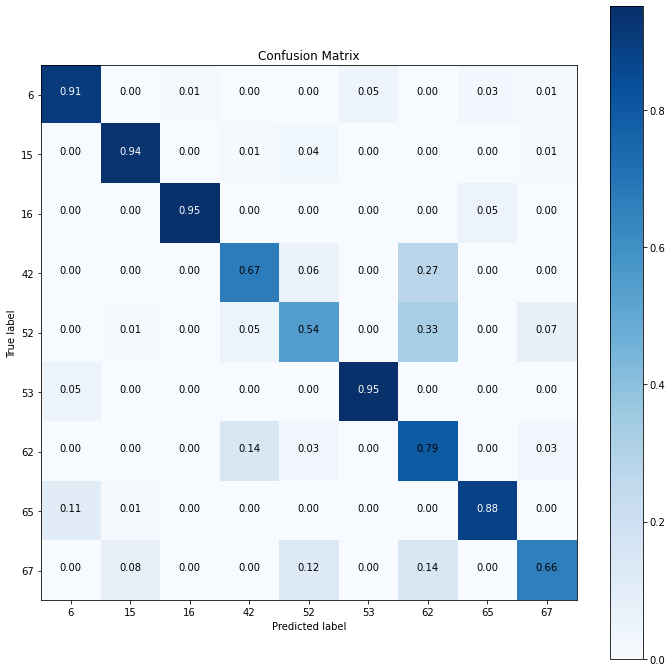


For number of classes: 10

X_train:  (4000, 105) , y_train:  (4000,) , X_test:  (1000, 105) , y_test:  (1000,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 134.25 seconds

Evaluation GP Model results:
Precision:  0.84
Recall:  0.84
F1-Score:  0.84
Accuracy:  0.84

Per Class Results:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       111
           1       0.90      0.86      0.88        96
           2       0.97      0.95      0.96        98
           3       0.82      0.72      0.76       113
           4       0.56      0.63      0.60        79
           5       0.95      0.99      0.97       102
           6       0.60      0.65      0.62        99
           7       0.91      0.96      0.93        96
           8       0.78      0.77      0.78        92
           9       0.90      0.91      0.91       114

    accuracy                           0.84      1000
   macro avg       0.84      0.83      0.83      1000
weighted avg       0.84      0.84      0.84      1000



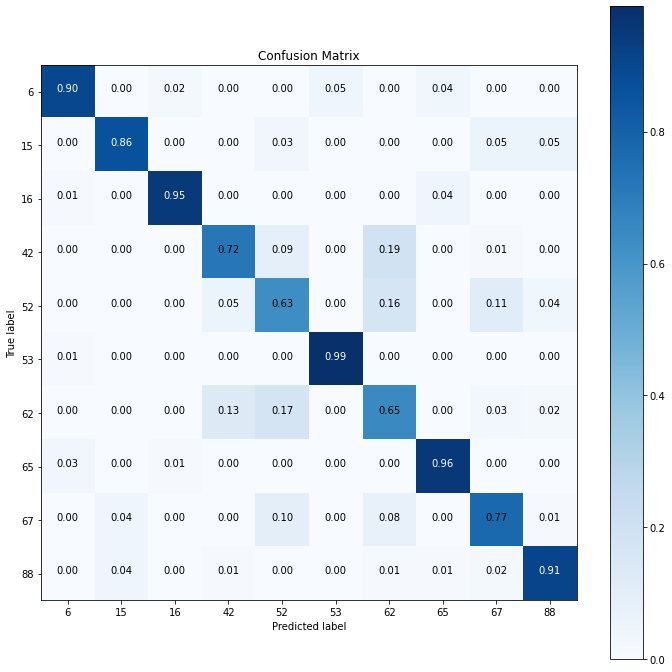


DL evaluation:

Model summary:
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               54272     
_________________________________________________________________
dense_22 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_23 (Dense)             (None, 10)                1290      
_________________________________________________________________
activation_7 (Activation)    (None, 10)                0         
Total params: 121,226
Trainable params: 121,226
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7 8 9], y=[5 9 9 ... 8 3 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


125/125 [==============================] - 0s 1ms/step - loss: 2.5162 - accuracy: 0.7345 - val_loss: 1.8510 - val_accuracy: 0.7970
Epoch 2/500
125/125 [==============================] - 0s 1ms/step - loss: 1.7431 - accuracy: 0.7928 - val_loss: 1.4252 - val_accuracy: 0.7890
Epoch 3/500
125/125 [==============================] - 0s 949us/step - loss: 1.3161 - accuracy: 0.8012 - val_loss: 1.1704 - val_accuracy: 0.8050
Epoch 4/500
125/125 [==============================] - 0s 982us/step - loss: 1.1020 - accuracy: 0.8060 - val_loss: 1.0188 - val_accuracy: 0.7920
Epoch 5/500
125/125 [==============================] - 0s 931us/step - loss: 0.9980 - accuracy: 0.8000 - val_loss: 0.9347 - val_accuracy: 0.8090
Epoch 6/500
125/125 [==============================] - 0s 922us/step - loss: 0.9564 - accuracy: 0.8052 - val_loss: 0.8849 - val_accuracy: 0.8120
Epoch 7/500
125/125 [==============================] - 0s 960us/step - loss: 0.8773 - accuracy: 0.8160 - val_loss: 0.9734 - val_accuracy: 0.7900
E

125/125 [==============================] - 0s 951us/step - loss: 1.9294 - accuracy: 0.8085 - val_loss: 1.6522 - val_accuracy: 0.7720
Epoch 114/500
125/125 [==============================] - 0s 929us/step - loss: 1.7926 - accuracy: 0.8150 - val_loss: 0.7432 - val_accuracy: 0.8190
Epoch 115/500
125/125 [==============================] - 0s 974us/step - loss: 0.6652 - accuracy: 0.8403 - val_loss: 0.7440 - val_accuracy: 0.8190
Epoch 116/500
125/125 [==============================] - 0s 966us/step - loss: 0.6128 - accuracy: 0.8438 - val_loss: 0.5930 - val_accuracy: 0.8270
Epoch 117/500
125/125 [==============================] - 0s 1ms/step - loss: 0.5333 - accuracy: 0.8432 - val_loss: 0.5830 - val_accuracy: 0.8230
Epoch 118/500
125/125 [==============================] - 0s 1ms/step - loss: 0.5290 - accuracy: 0.8470 - val_loss: 0.5848 - val_accuracy: 0.8270
Epoch 119/500
125/125 [==============================] - 0s 944us/step - loss: 0.5186 - accuracy: 0.8478 - val_loss: 0.5560 - val_accura

Epoch 169/500
125/125 [==============================] - 0s 969us/step - loss: 0.5372 - accuracy: 0.8425 - val_loss: 0.6164 - val_accuracy: 0.8260
Epoch 170/500
125/125 [==============================] - 0s 968us/step - loss: 0.5423 - accuracy: 0.8450 - val_loss: 0.5635 - val_accuracy: 0.8380
Epoch 171/500
125/125 [==============================] - 0s 1ms/step - loss: 0.5204 - accuracy: 0.8457 - val_loss: 0.5645 - val_accuracy: 0.8240
Epoch 172/500
125/125 [==============================] - 0s 947us/step - loss: 0.4940 - accuracy: 0.8528 - val_loss: 0.5248 - val_accuracy: 0.8510
Epoch 173/500
125/125 [==============================] - 0s 948us/step - loss: 0.4872 - accuracy: 0.8515 - val_loss: 0.5268 - val_accuracy: 0.8400
Epoch 174/500
125/125 [==============================] - 0s 1ms/step - loss: 0.4786 - accuracy: 0.8545 - val_loss: 0.5252 - val_accuracy: 0.8350
Epoch 175/500
125/125 [==============================] - 0s 967us/step - loss: 0.4711 - accuracy: 0.8515 - val_loss: 0.525

Epoch 225/500
125/125 [==============================] - 0s 948us/step - loss: 1.5009 - accuracy: 0.8245 - val_loss: 0.7237 - val_accuracy: 0.8320
Epoch 226/500
125/125 [==============================] - 0s 951us/step - loss: 0.7456 - accuracy: 0.8418 - val_loss: 0.8109 - val_accuracy: 0.8250
Epoch 227/500
125/125 [==============================] - 0s 948us/step - loss: 0.6150 - accuracy: 0.8388 - val_loss: 0.6341 - val_accuracy: 0.8370
Epoch 228/500
125/125 [==============================] - 0s 950us/step - loss: 0.5317 - accuracy: 0.8508 - val_loss: 0.5817 - val_accuracy: 0.8390
Epoch 229/500
125/125 [==============================] - 0s 942us/step - loss: 0.5091 - accuracy: 0.8512 - val_loss: 0.5417 - val_accuracy: 0.8320
Epoch 230/500
125/125 [==============================] - 0s 942us/step - loss: 0.4875 - accuracy: 0.8543 - val_loss: 0.5175 - val_accuracy: 0.8370
Epoch 231/500
125/125 [==============================] - 0s 959us/step - loss: 0.5319 - accuracy: 0.8440 - val_loss: 0

Epoch 281/500
125/125 [==============================] - 0s 931us/step - loss: 0.4990 - accuracy: 0.8565 - val_loss: 0.6102 - val_accuracy: 0.8270
Epoch 282/500
125/125 [==============================] - 0s 965us/step - loss: 0.5080 - accuracy: 0.8503 - val_loss: 0.6070 - val_accuracy: 0.8330
Epoch 283/500
125/125 [==============================] - 0s 947us/step - loss: 0.5417 - accuracy: 0.8425 - val_loss: 0.5574 - val_accuracy: 0.8360
Epoch 284/500
125/125 [==============================] - 0s 932us/step - loss: 0.4954 - accuracy: 0.8472 - val_loss: 0.5513 - val_accuracy: 0.8270
Epoch 285/500
125/125 [==============================] - 0s 939us/step - loss: 0.4771 - accuracy: 0.8515 - val_loss: 0.5426 - val_accuracy: 0.8280
Epoch 286/500
125/125 [==============================] - 0s 904us/step - loss: 0.4682 - accuracy: 0.8518 - val_loss: 0.5819 - val_accuracy: 0.8240
Epoch 287/500
125/125 [==============================] - 0s 983us/step - loss: 0.5081 - accuracy: 0.8472 - val_loss: 0

Epoch 337/500
125/125 [==============================] - 0s 923us/step - loss: 0.4406 - accuracy: 0.8562 - val_loss: 0.4912 - val_accuracy: 0.8390
Epoch 338/500
125/125 [==============================] - 0s 952us/step - loss: 0.4555 - accuracy: 0.8537 - val_loss: 0.5414 - val_accuracy: 0.8290
Epoch 339/500
125/125 [==============================] - 0s 1ms/step - loss: 0.4839 - accuracy: 0.8462 - val_loss: 0.5603 - val_accuracy: 0.8280
Epoch 340/500
125/125 [==============================] - 0s 951us/step - loss: 0.4720 - accuracy: 0.8512 - val_loss: 0.5111 - val_accuracy: 0.8250
Epoch 341/500
125/125 [==============================] - 0s 939us/step - loss: 0.4965 - accuracy: 0.8468 - val_loss: 0.6569 - val_accuracy: 0.8220
Epoch 342/500
125/125 [==============================] - 0s 952us/step - loss: 0.7998 - accuracy: 0.8127 - val_loss: 0.8665 - val_accuracy: 0.7820
Epoch 343/500
125/125 [==============================] - 0s 967us/step - loss: 2.3945 - accuracy: 0.7862 - val_loss: 0.8

Epoch 393/500
125/125 [==============================] - 0s 942us/step - loss: 0.4623 - accuracy: 0.8550 - val_loss: 0.5689 - val_accuracy: 0.8310
Epoch 394/500
125/125 [==============================] - 0s 907us/step - loss: 0.4646 - accuracy: 0.8555 - val_loss: 0.5092 - val_accuracy: 0.8280
Epoch 395/500
125/125 [==============================] - 0s 931us/step - loss: 0.4530 - accuracy: 0.8560 - val_loss: 0.5078 - val_accuracy: 0.8310
Epoch 396/500
125/125 [==============================] - 0s 991us/step - loss: 0.4569 - accuracy: 0.8480 - val_loss: 0.5213 - val_accuracy: 0.8320
Epoch 397/500
125/125 [==============================] - 0s 1ms/step - loss: 0.4572 - accuracy: 0.8547 - val_loss: 0.5071 - val_accuracy: 0.8320
Epoch 398/500
125/125 [==============================] - 0s 993us/step - loss: 0.4493 - accuracy: 0.8555 - val_loss: 0.4966 - val_accuracy: 0.8440
Epoch 399/500
125/125 [==============================] - 0s 939us/step - loss: 0.4448 - accuracy: 0.8583 - val_loss: 0.5

Epoch 449/500
125/125 [==============================] - 0s 950us/step - loss: 0.4935 - accuracy: 0.8560 - val_loss: 0.6768 - val_accuracy: 0.8050
Epoch 450/500
125/125 [==============================] - 0s 923us/step - loss: 0.5634 - accuracy: 0.8432 - val_loss: 0.6029 - val_accuracy: 0.8280
Epoch 451/500
125/125 [==============================] - 0s 962us/step - loss: 0.5014 - accuracy: 0.8562 - val_loss: 0.5913 - val_accuracy: 0.8370
Epoch 452/500
125/125 [==============================] - 0s 958us/step - loss: 0.5022 - accuracy: 0.8555 - val_loss: 0.5214 - val_accuracy: 0.8350
Epoch 453/500
125/125 [==============================] - 0s 913us/step - loss: 0.4643 - accuracy: 0.8558 - val_loss: 0.5384 - val_accuracy: 0.8430
Epoch 454/500
125/125 [==============================] - 0s 957us/step - loss: 0.4706 - accuracy: 0.8560 - val_loss: 0.5227 - val_accuracy: 0.8340
Epoch 455/500
125/125 [==============================] - 0s 989us/step - loss: 0.4740 - accuracy: 0.8575 - val_loss: 0

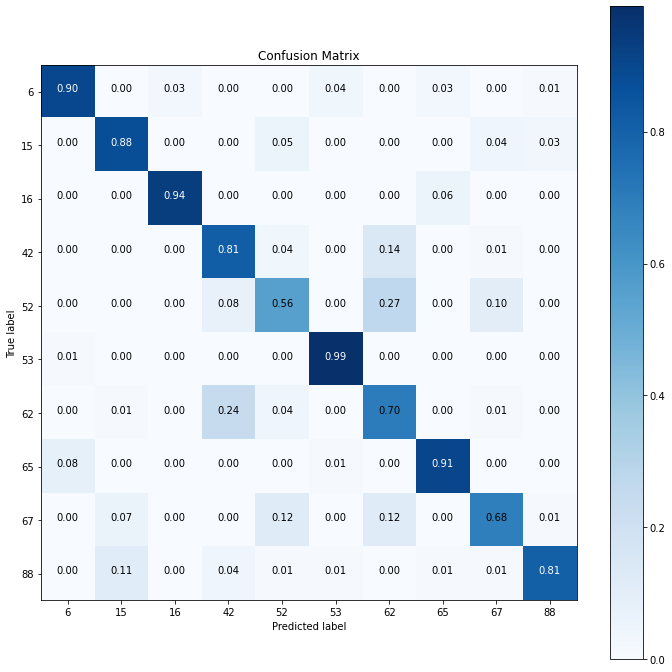


For number of classes: 11

X_train:  (4400, 105) , y_train:  (4400,) , X_test:  (1100, 105) , y_test:  (1100,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 156.94 seconds

Evaluation GP Model results:
Precision:  0.84
Recall:  0.84
F1-Score:  0.84
Accuracy:  0.84

Per Class Results:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92        96
           1       0.91      0.87      0.89       106
           2       0.99      0.98      0.98        98
           3       0.78      0.81      0.79        90
           4       0.75      0.55      0.63        99
           5       0.96      0.98      0.97        94
           6       0.59      0.66      0.62       112
           7       0.96      0.95      0.95        99
           8       0.78      0.71      0.74        90
           9       0.91      0.93      0.92       113
          10       0.71      0.84      0.77       103

    accuracy                           0.84      1100
   macro avg       0.84      0.84      0.84      1100
weighted avg       0.84      0.84      0.84      1100



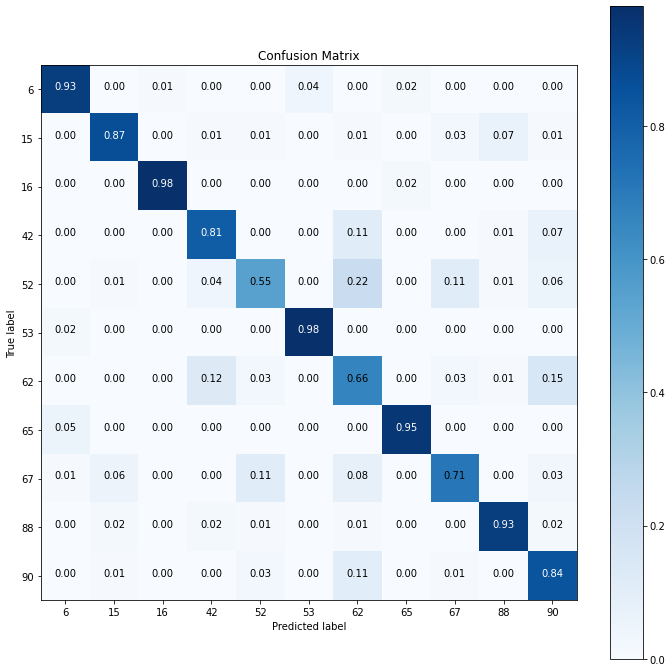


DL evaluation:

Model summary:
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               54272     
_________________________________________________________________
dense_25 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_26 (Dense)             (None, 11)                1419      
_________________________________________________________________
activation_8 (Activation)    (None, 11)                0         
Total params: 121,355
Trainable params: 121,355
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10], y=[ 3  4 10 ...  1  0 10] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


138/138 [==============================] - 0s 2ms/step - loss: 2.4757 - accuracy: 0.7300 - val_loss: 1.8737 - val_accuracy: 0.7582
Epoch 2/500
138/138 [==============================] - 0s 1ms/step - loss: 1.6348 - accuracy: 0.7782 - val_loss: 1.3918 - val_accuracy: 0.7582
Epoch 3/500
138/138 [==============================] - 0s 1ms/step - loss: 1.3072 - accuracy: 0.7843 - val_loss: 1.1439 - val_accuracy: 0.7709
Epoch 4/500
138/138 [==============================] - 0s 1ms/step - loss: 1.1161 - accuracy: 0.7914 - val_loss: 1.0185 - val_accuracy: 0.7755
Epoch 5/500
138/138 [==============================] - 0s 1ms/step - loss: 1.0053 - accuracy: 0.7948 - val_loss: 0.9408 - val_accuracy: 0.7718
Epoch 6/500
138/138 [==============================] - 0s 1ms/step - loss: 0.9214 - accuracy: 0.7961 - val_loss: 0.9388 - val_accuracy: 0.7500
Epoch 7/500
138/138 [==============================] - 0s 1ms/step - loss: 1.0357 - accuracy: 0.7814 - val_loss: 0.9197 - val_accuracy: 0.7773
Epoch 8/500

138/138 [==============================] - 0s 1ms/step - loss: 1.1820 - accuracy: 0.7961 - val_loss: 0.9003 - val_accuracy: 0.7864
Epoch 59/500
138/138 [==============================] - 0s 1ms/step - loss: 0.9571 - accuracy: 0.8150 - val_loss: 0.8249 - val_accuracy: 0.7827
Epoch 60/500
138/138 [==============================] - 0s 1ms/step - loss: 0.7954 - accuracy: 0.8182 - val_loss: 0.7283 - val_accuracy: 0.7936
Epoch 61/500
138/138 [==============================] - 0s 1ms/step - loss: 0.7160 - accuracy: 0.8264 - val_loss: 0.7390 - val_accuracy: 0.7964
Epoch 62/500
138/138 [==============================] - 0s 1ms/step - loss: 0.6766 - accuracy: 0.8239 - val_loss: 0.6775 - val_accuracy: 0.7991
Epoch 63/500
138/138 [==============================] - 0s 1ms/step - loss: 0.6305 - accuracy: 0.8277 - val_loss: 0.6742 - val_accuracy: 0.8055
Epoch 64/500
138/138 [==============================] - 0s 1ms/step - loss: 0.6100 - accuracy: 0.8282 - val_loss: 0.6626 - val_accuracy: 0.8100
Epoch

Epoch 115/500
138/138 [==============================] - 0s 1ms/step - loss: 0.5599 - accuracy: 0.8357 - val_loss: 0.6202 - val_accuracy: 0.8036
Epoch 116/500
138/138 [==============================] - 0s 1ms/step - loss: 0.5726 - accuracy: 0.8323 - val_loss: 0.6273 - val_accuracy: 0.8009
Epoch 117/500
138/138 [==============================] - 0s 1ms/step - loss: 0.5681 - accuracy: 0.8323 - val_loss: 0.6351 - val_accuracy: 0.8136
Epoch 118/500
138/138 [==============================] - 0s 1ms/step - loss: 0.5894 - accuracy: 0.8305 - val_loss: 0.6858 - val_accuracy: 0.7991
Epoch 119/500
138/138 [==============================] - 0s 1ms/step - loss: 0.5815 - accuracy: 0.8289 - val_loss: 0.6081 - val_accuracy: 0.8136
Epoch 120/500
138/138 [==============================] - 0s 1ms/step - loss: 0.5713 - accuracy: 0.8302 - val_loss: 0.6105 - val_accuracy: 0.8100
Epoch 121/500
138/138 [==============================] - 0s 1ms/step - loss: 0.5587 - accuracy: 0.8320 - val_loss: 0.6185 - val_ac

138/138 [==============================] - 0s 1ms/step - loss: 1.2850 - accuracy: 0.7868 - val_loss: 1.4830 - val_accuracy: 0.7682
Epoch 228/500
138/138 [==============================] - 0s 1ms/step - loss: 0.9648 - accuracy: 0.8066 - val_loss: 0.7822 - val_accuracy: 0.8064
Epoch 229/500
138/138 [==============================] - 0s 1ms/step - loss: 0.6538 - accuracy: 0.8277 - val_loss: 0.6730 - val_accuracy: 0.8064
Epoch 230/500
138/138 [==============================] - 0s 1ms/step - loss: 0.6694 - accuracy: 0.8291 - val_loss: 0.7454 - val_accuracy: 0.8100
Epoch 231/500
138/138 [==============================] - 0s 1ms/step - loss: 0.6022 - accuracy: 0.8361 - val_loss: 0.6218 - val_accuracy: 0.8164
Epoch 232/500
138/138 [==============================] - 0s 1ms/step - loss: 0.7341 - accuracy: 0.8198 - val_loss: 0.8472 - val_accuracy: 0.8055
Epoch 233/500
138/138 [==============================] - 0s 2ms/step - loss: 1.8736 - accuracy: 0.7670 - val_loss: 2.1591 - val_accuracy: 0.7200

138/138 [==============================] - 0s 1ms/step - loss: 0.8453 - accuracy: 0.8252 - val_loss: 0.6893 - val_accuracy: 0.8082
Epoch 340/500
138/138 [==============================] - 0s 1ms/step - loss: 0.7326 - accuracy: 0.8173 - val_loss: 0.7375 - val_accuracy: 0.8073
Epoch 341/500
138/138 [==============================] - 0s 1ms/step - loss: 0.5875 - accuracy: 0.8391 - val_loss: 0.6726 - val_accuracy: 0.8018
Epoch 342/500
138/138 [==============================] - 0s 1ms/step - loss: 0.5945 - accuracy: 0.8377 - val_loss: 0.6264 - val_accuracy: 0.7991
Epoch 343/500
138/138 [==============================] - 0s 1ms/step - loss: 0.5553 - accuracy: 0.8411 - val_loss: 0.6244 - val_accuracy: 0.8073
Epoch 344/500
138/138 [==============================] - 0s 1ms/step - loss: 0.5538 - accuracy: 0.8366 - val_loss: 0.6175 - val_accuracy: 0.7982
Epoch 345/500
138/138 [==============================] - 0s 1ms/step - loss: 0.5361 - accuracy: 0.8405 - val_loss: 0.6107 - val_accuracy: 0.8164

138/138 [==============================] - 0s 1ms/step - loss: 0.5964 - accuracy: 0.8407 - val_loss: 0.7245 - val_accuracy: 0.8027
Epoch 452/500
138/138 [==============================] - 0s 1ms/step - loss: 0.5848 - accuracy: 0.8430 - val_loss: 0.6465 - val_accuracy: 0.8100
Epoch 453/500
138/138 [==============================] - 0s 1ms/step - loss: 0.6578 - accuracy: 0.8314 - val_loss: 0.6767 - val_accuracy: 0.8045
Epoch 454/500
138/138 [==============================] - 0s 1ms/step - loss: 1.3730 - accuracy: 0.8005 - val_loss: 0.8623 - val_accuracy: 0.7955
Epoch 455/500
138/138 [==============================] - 0s 1ms/step - loss: 0.7136 - accuracy: 0.8384 - val_loss: 0.7115 - val_accuracy: 0.7927
Epoch 456/500
138/138 [==============================] - 0s 1ms/step - loss: 0.8382 - accuracy: 0.8223 - val_loss: 0.6587 - val_accuracy: 0.8145
Epoch 457/500
138/138 [==============================] - 0s 1ms/step - loss: 0.6343 - accuracy: 0.8384 - val_loss: 0.6184 - val_accuracy: 0.8191

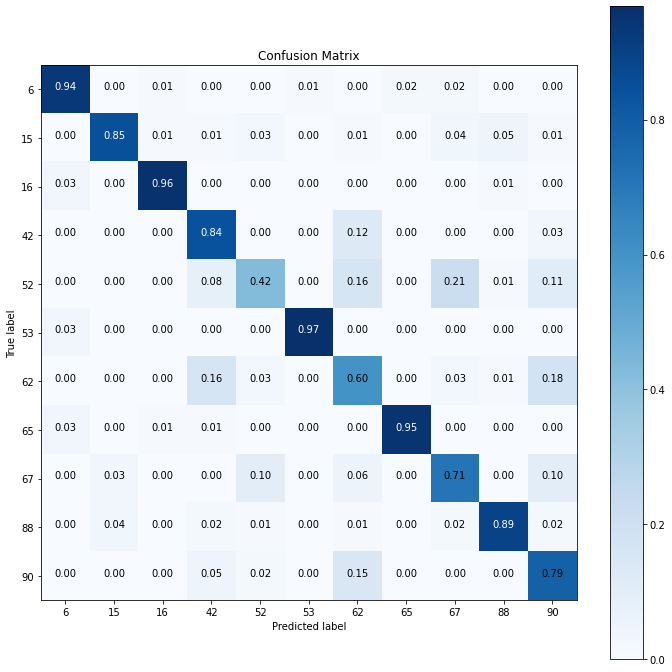


For number of classes: 12

X_train:  (4800, 105) , y_train:  (4800,) , X_test:  (1200, 105) , y_test:  (1200,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 198.31 seconds

Evaluation GP Model results:
Precision:  0.87
Recall:  0.86
F1-Score:  0.86
Accuracy:  0.86

Per Class Results:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        91
           1       0.94      0.90      0.92       104
           2       0.94      0.95      0.94        93
           3       0.81      0.82      0.82       106
           4       0.89      0.53      0.67        96
           5       0.98      0.99      0.99       106
           6       0.61      0.75      0.67       106
           7       0.93      0.88      0.90        88
           8       0.85      0.78      0.82       116
           9       0.89      0.95      0.92       104
          10       0.69      0.82      0.75        91
          11       0.98      0.98      0.98        99

    accuracy                           0.86      1200
   macro avg       0.87      0.86      0.86      1200
weighted avg       0.87      0.86      0.8

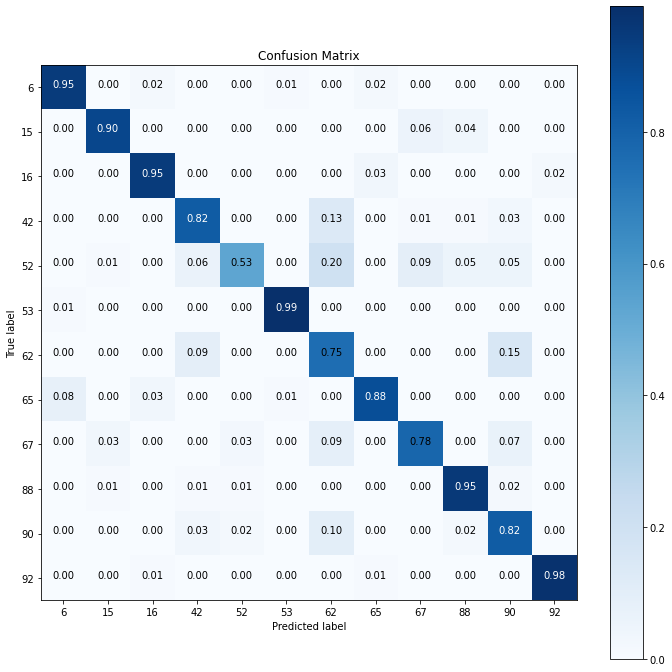


DL evaluation:

Model summary:
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 512)               54272     
_________________________________________________________________
dense_28 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_29 (Dense)             (None, 12)                1548      
_________________________________________________________________
activation_9 (Activation)    (None, 12)                0         
Total params: 121,484
Trainable params: 121,484
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11], y=[0 9 5 ... 1 7 7] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


150/150 [==============================] - 0s 1ms/step - loss: 2.5442 - accuracy: 0.7379 - val_loss: 1.8359 - val_accuracy: 0.7783
Epoch 2/500
150/150 [==============================] - 0s 933us/step - loss: 1.6288 - accuracy: 0.7877 - val_loss: 1.3539 - val_accuracy: 0.8050
Epoch 3/500
150/150 [==============================] - 0s 955us/step - loss: 1.2853 - accuracy: 0.7946 - val_loss: 1.1382 - val_accuracy: 0.8042
Epoch 4/500
150/150 [==============================] - 0s 935us/step - loss: 1.1793 - accuracy: 0.7887 - val_loss: 1.0395 - val_accuracy: 0.7975
Epoch 5/500
150/150 [==============================] - 0s 957us/step - loss: 1.0626 - accuracy: 0.7900 - val_loss: 0.9895 - val_accuracy: 0.7767
Epoch 6/500
150/150 [==============================] - 0s 944us/step - loss: 1.2773 - accuracy: 0.7785 - val_loss: 0.9062 - val_accuracy: 0.8158
Epoch 7/500
150/150 [==============================] - 0s 943us/step - loss: 0.9051 - accuracy: 0.8042 - val_loss: 0.8908 - val_accuracy: 0.8050

150/150 [==============================] - 0s 973us/step - loss: 0.5682 - accuracy: 0.8315 - val_loss: 0.5954 - val_accuracy: 0.8392
Epoch 114/500
150/150 [==============================] - 0s 963us/step - loss: 0.5642 - accuracy: 0.8371 - val_loss: 0.5756 - val_accuracy: 0.8325
Epoch 115/500
150/150 [==============================] - 0s 986us/step - loss: 0.7261 - accuracy: 0.8233 - val_loss: 0.9616 - val_accuracy: 0.7908
Epoch 116/500
150/150 [==============================] - ETA: 0s - loss: 1.3877 - accuracy: 0.77 - 0s 1ms/step - loss: 1.3749 - accuracy: 0.7790 - val_loss: 0.8880 - val_accuracy: 0.8308
Epoch 117/500
150/150 [==============================] - 0s 970us/step - loss: 1.3383 - accuracy: 0.7873 - val_loss: 0.9097 - val_accuracy: 0.8258
Epoch 118/500
150/150 [==============================] - 0s 954us/step - loss: 0.8763 - accuracy: 0.8213 - val_loss: 1.9975 - val_accuracy: 0.7317
Epoch 119/500
150/150 [==============================] - 0s 995us/step - loss: 1.0256 - accu

Epoch 169/500
150/150 [==============================] - 0s 1ms/step - loss: 1.0126 - accuracy: 0.8185 - val_loss: 0.9188 - val_accuracy: 0.8150
Epoch 170/500
150/150 [==============================] - 0s 1ms/step - loss: 0.8531 - accuracy: 0.8131 - val_loss: 0.7366 - val_accuracy: 0.8317
Epoch 171/500
150/150 [==============================] - 0s 1ms/step - loss: 0.8570 - accuracy: 0.8135 - val_loss: 0.6640 - val_accuracy: 0.8250
Epoch 172/500
150/150 [==============================] - 0s 1ms/step - loss: 0.7977 - accuracy: 0.8271 - val_loss: 0.6834 - val_accuracy: 0.8292
Epoch 173/500
150/150 [==============================] - 0s 977us/step - loss: 0.7098 - accuracy: 0.8252 - val_loss: 0.6928 - val_accuracy: 0.8317
Epoch 174/500
150/150 [==============================] - 0s 994us/step - loss: 0.6568 - accuracy: 0.8296 - val_loss: 0.6478 - val_accuracy: 0.8350
Epoch 175/500
150/150 [==============================] - 0s 1ms/step - loss: 0.6022 - accuracy: 0.8340 - val_loss: 0.6015 - va

150/150 [==============================] - 0s 1ms/step - loss: 0.5466 - accuracy: 0.8425 - val_loss: 0.5712 - val_accuracy: 0.8400
Epoch 282/500
150/150 [==============================] - 0s 989us/step - loss: 0.5426 - accuracy: 0.8371 - val_loss: 0.5940 - val_accuracy: 0.8292
Epoch 283/500
150/150 [==============================] - 0s 993us/step - loss: 0.5330 - accuracy: 0.8381 - val_loss: 0.5657 - val_accuracy: 0.8375
Epoch 284/500
150/150 [==============================] - 0s 975us/step - loss: 0.5343 - accuracy: 0.8413 - val_loss: 0.5677 - val_accuracy: 0.8308
Epoch 285/500
150/150 [==============================] - 0s 971us/step - loss: 0.5385 - accuracy: 0.8392 - val_loss: 0.5692 - val_accuracy: 0.8375
Epoch 286/500
150/150 [==============================] - 0s 990us/step - loss: 0.5381 - accuracy: 0.8350 - val_loss: 0.5627 - val_accuracy: 0.8350
Epoch 287/500
150/150 [==============================] - 0s 952us/step - loss: 0.5329 - accuracy: 0.8354 - val_loss: 0.5591 - val_accu

Epoch 337/500
150/150 [==============================] - 0s 973us/step - loss: 0.7497 - accuracy: 0.8298 - val_loss: 0.6254 - val_accuracy: 0.8300
Epoch 338/500
150/150 [==============================] - 0s 978us/step - loss: 0.6059 - accuracy: 0.8373 - val_loss: 0.6173 - val_accuracy: 0.8325
Epoch 339/500
150/150 [==============================] - 0s 985us/step - loss: 0.5766 - accuracy: 0.8381 - val_loss: 0.5855 - val_accuracy: 0.8342
Epoch 340/500
150/150 [==============================] - 0s 958us/step - loss: 0.5565 - accuracy: 0.8358 - val_loss: 0.5865 - val_accuracy: 0.8350
Epoch 341/500
150/150 [==============================] - 0s 998us/step - loss: 0.5553 - accuracy: 0.8404 - val_loss: 0.5879 - val_accuracy: 0.8342
Epoch 342/500
150/150 [==============================] - 0s 979us/step - loss: 0.5424 - accuracy: 0.8421 - val_loss: 0.5647 - val_accuracy: 0.8392
Epoch 343/500
150/150 [==============================] - 0s 969us/step - loss: 0.5313 - accuracy: 0.8400 - val_loss: 0

Epoch 393/500
150/150 [==============================] - 0s 1ms/step - loss: 1.0622 - accuracy: 0.8150 - val_loss: 0.7587 - val_accuracy: 0.8283
Epoch 394/500
150/150 [==============================] - 0s 994us/step - loss: 0.7054 - accuracy: 0.8292 - val_loss: 0.8242 - val_accuracy: 0.8075
Epoch 395/500
150/150 [==============================] - 0s 932us/step - loss: 1.0905 - accuracy: 0.8104 - val_loss: 0.6775 - val_accuracy: 0.8425
Epoch 396/500
150/150 [==============================] - 0s 970us/step - loss: 0.6493 - accuracy: 0.8354 - val_loss: 0.7333 - val_accuracy: 0.8308
Epoch 397/500
150/150 [==============================] - 0s 943us/step - loss: 0.6614 - accuracy: 0.8394 - val_loss: 0.6685 - val_accuracy: 0.8325
Epoch 398/500
150/150 [==============================] - 0s 948us/step - loss: 0.7275 - accuracy: 0.8321 - val_loss: 0.6970 - val_accuracy: 0.8250
Epoch 399/500
150/150 [==============================] - 0s 956us/step - loss: 0.6911 - accuracy: 0.8338 - val_loss: 0.6

Epoch 449/500
150/150 [==============================] - 0s 1ms/step - loss: 0.5175 - accuracy: 0.8394 - val_loss: 0.5522 - val_accuracy: 0.8358
Epoch 450/500
150/150 [==============================] - 0s 1ms/step - loss: 0.5198 - accuracy: 0.8385 - val_loss: 0.5507 - val_accuracy: 0.8425
Epoch 451/500
150/150 [==============================] - 0s 898us/step - loss: 0.5185 - accuracy: 0.8396 - val_loss: 0.5581 - val_accuracy: 0.8383
Epoch 452/500
150/150 [==============================] - 0s 933us/step - loss: 0.5182 - accuracy: 0.8419 - val_loss: 0.5509 - val_accuracy: 0.8433
Epoch 453/500
150/150 [==============================] - 0s 888us/step - loss: 0.5121 - accuracy: 0.8448 - val_loss: 0.5489 - val_accuracy: 0.8342
Epoch 454/500
150/150 [==============================] - 0s 1ms/step - loss: 0.5107 - accuracy: 0.8460 - val_loss: 0.5633 - val_accuracy: 0.8292
Epoch 455/500
150/150 [==============================] - 0s 972us/step - loss: 0.5189 - accuracy: 0.8371 - val_loss: 0.5682 

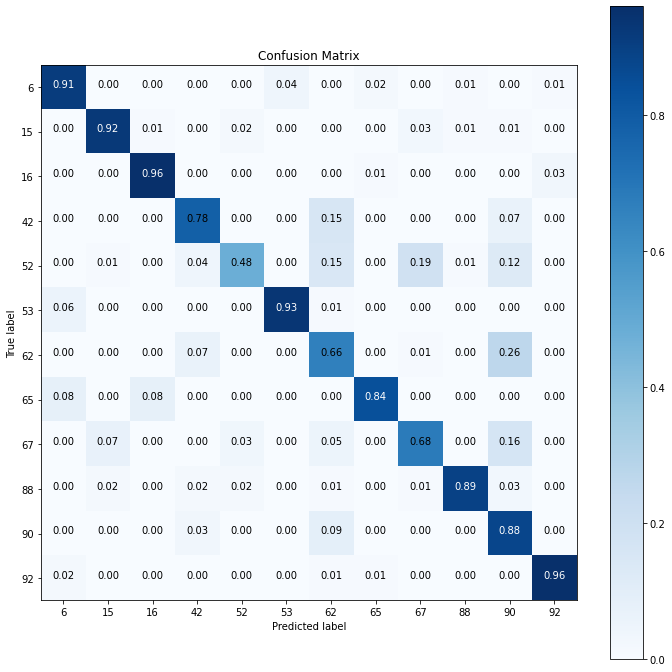


For number of classes: 13

X_train:  (5200, 105) , y_train:  (5200,) , X_test:  (1300, 105) , y_test:  (1300,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 246.22 seconds

Evaluation GP Model results:
Precision:  0.85
Recall:  0.84
F1-Score:  0.84
Accuracy:  0.84

Per Class Results:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87        88
           1       0.81      0.86      0.83        91
           2       0.96      0.97      0.96        99
           3       0.85      0.67      0.75        90
           4       0.72      0.57      0.64        97
           5       0.96      0.97      0.96        91
           6       0.59      0.82      0.69       104
           7       0.91      0.90      0.91       101
           8       0.88      0.75      0.81       114
           9       0.90      0.95      0.93       107
          10       0.76      0.83      0.79       109
          11       0.99      0.98      0.99       104
          12       0.88      0.84      0.86       105

    accuracy                           0.84      1300
   macro avg       0.85      0.84      0.8

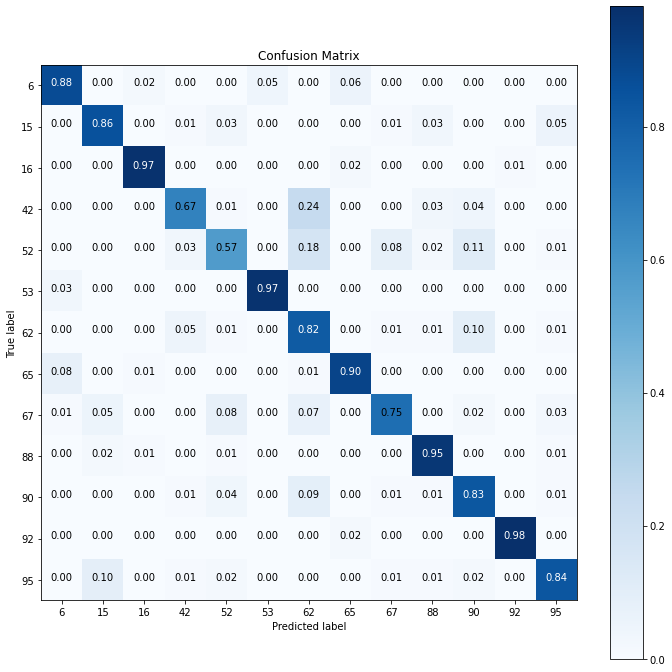


DL evaluation:

Model summary:
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 512)               54272     
_________________________________________________________________
dense_31 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_32 (Dense)             (None, 13)                1677      
_________________________________________________________________
activation_10 (Activation)   (None, 13)                0         
Total params: 121,613
Trainable params: 121,613
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12], y=[ 6 10  1 ...  0  8 12] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


163/163 [==============================] - 0s 2ms/step - loss: 2.5536 - accuracy: 0.7146 - val_loss: 1.8802 - val_accuracy: 0.7538
Epoch 2/500
163/163 [==============================] - 0s 1ms/step - loss: 1.6961 - accuracy: 0.7762 - val_loss: 1.5642 - val_accuracy: 0.7531
Epoch 3/500
163/163 [==============================] - 0s 1ms/step - loss: 1.3730 - accuracy: 0.7754 - val_loss: 1.2466 - val_accuracy: 0.7577
Epoch 4/500
163/163 [==============================] - 0s 1ms/step - loss: 1.1390 - accuracy: 0.7835 - val_loss: 1.2923 - val_accuracy: 0.7831
Epoch 5/500
163/163 [==============================] - 0s 1ms/step - loss: 1.0003 - accuracy: 0.7890 - val_loss: 0.9817 - val_accuracy: 0.7823
Epoch 6/500
163/163 [==============================] - 0s 1ms/step - loss: 1.1249 - accuracy: 0.7733 - val_loss: 1.3038 - val_accuracy: 0.7608
Epoch 7/500
163/163 [==============================] - 0s 1ms/step - loss: 1.0216 - accuracy: 0.7844 - val_loss: 0.9445 - val_accuracy: 0.7777
Epoch 8/500

163/163 [==============================] - 0s 1ms/step - loss: 1.1904 - accuracy: 0.7896 - val_loss: 1.4744 - val_accuracy: 0.8000
Epoch 59/500
163/163 [==============================] - 0s 1ms/step - loss: 0.9370 - accuracy: 0.8035 - val_loss: 1.0244 - val_accuracy: 0.7762
Epoch 60/500
163/163 [==============================] - 0s 1ms/step - loss: 0.8131 - accuracy: 0.8140 - val_loss: 0.8018 - val_accuracy: 0.7792
Epoch 61/500
163/163 [==============================] - 0s 1ms/step - loss: 0.8803 - accuracy: 0.7985 - val_loss: 0.9634 - val_accuracy: 0.7962
Epoch 62/500
163/163 [==============================] - 0s 1ms/step - loss: 0.6846 - accuracy: 0.8198 - val_loss: 0.7164 - val_accuracy: 0.8023
Epoch 63/500
163/163 [==============================] - 0s 1ms/step - loss: 0.7208 - accuracy: 0.8165 - val_loss: 0.8920 - val_accuracy: 0.7931
Epoch 64/500
163/163 [==============================] - 0s 1ms/step - loss: 0.6893 - accuracy: 0.8206 - val_loss: 0.8451 - val_accuracy: 0.7931
Epoch

163/163 [==============================] - 0s 1ms/step - loss: 0.6185 - accuracy: 0.8213 - val_loss: 1.6255 - val_accuracy: 0.7100
Epoch 171/500
163/163 [==============================] - 0s 1ms/step - loss: 1.3782 - accuracy: 0.7829 - val_loss: 1.6224 - val_accuracy: 0.7615
Epoch 172/500
163/163 [==============================] - 0s 1ms/step - loss: 1.6322 - accuracy: 0.7919 - val_loss: 2.7152 - val_accuracy: 0.7600
Epoch 173/500
163/163 [==============================] - 0s 1ms/step - loss: 1.7331 - accuracy: 0.7977 - val_loss: 1.8560 - val_accuracy: 0.7938
Epoch 174/500
163/163 [==============================] - 0s 1ms/step - loss: 0.9873 - accuracy: 0.8188 - val_loss: 0.8995 - val_accuracy: 0.8031
Epoch 175/500
163/163 [==============================] - 0s 1ms/step - loss: 0.6604 - accuracy: 0.8250 - val_loss: 0.7479 - val_accuracy: 0.8100
Epoch 176/500
163/163 [==============================] - 0s 1ms/step - loss: 0.6248 - accuracy: 0.8302 - val_loss: 0.7089 - val_accuracy: 0.8169

163/163 [==============================] - 0s 1ms/step - loss: 0.8200 - accuracy: 0.8242 - val_loss: 0.8847 - val_accuracy: 0.8031
Epoch 283/500
163/163 [==============================] - 0s 1ms/step - loss: 0.6552 - accuracy: 0.8240 - val_loss: 0.7444 - val_accuracy: 0.8177
Epoch 284/500
163/163 [==============================] - 0s 1ms/step - loss: 0.6103 - accuracy: 0.8310 - val_loss: 0.7000 - val_accuracy: 0.8162
Epoch 285/500
163/163 [==============================] - 0s 1ms/step - loss: 0.6130 - accuracy: 0.8308 - val_loss: 0.7607 - val_accuracy: 0.8146
Epoch 286/500
163/163 [==============================] - 0s 1ms/step - loss: 0.6004 - accuracy: 0.8300 - val_loss: 0.6888 - val_accuracy: 0.8146
Epoch 287/500
163/163 [==============================] - 0s 1ms/step - loss: 0.5946 - accuracy: 0.8298 - val_loss: 0.6532 - val_accuracy: 0.8138
Epoch 288/500
163/163 [==============================] - 0s 1ms/step - loss: 0.5764 - accuracy: 0.8362 - val_loss: 0.6748 - val_accuracy: 0.8100

163/163 [==============================] - 0s 1ms/step - loss: 0.5901 - accuracy: 0.8292 - val_loss: 0.6398 - val_accuracy: 0.8208
Epoch 395/500
163/163 [==============================] - 0s 1ms/step - loss: 0.5773 - accuracy: 0.8285 - val_loss: 0.6564 - val_accuracy: 0.8138
Epoch 396/500
163/163 [==============================] - 0s 1ms/step - loss: 0.5806 - accuracy: 0.8302 - val_loss: 0.6509 - val_accuracy: 0.8092
Epoch 397/500
163/163 [==============================] - 0s 1ms/step - loss: 0.5633 - accuracy: 0.8333 - val_loss: 0.6402 - val_accuracy: 0.8138
Epoch 398/500
163/163 [==============================] - 0s 1ms/step - loss: 0.5648 - accuracy: 0.8383 - val_loss: 0.6398 - val_accuracy: 0.8131
Epoch 399/500
163/163 [==============================] - 0s 1ms/step - loss: 0.5642 - accuracy: 0.8302 - val_loss: 0.6387 - val_accuracy: 0.8138
Epoch 400/500
163/163 [==============================] - 0s 1ms/step - loss: 0.5611 - accuracy: 0.8296 - val_loss: 0.6439 - val_accuracy: 0.8138

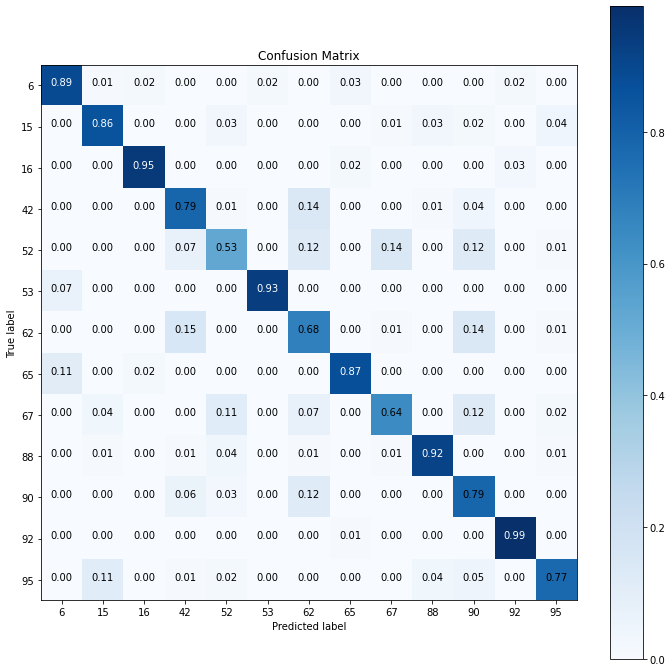

([0.98, 0.99, 0.94, 0.92, 0.9, 0.89, 0.82, 0.84, 0.84, 0.86, 0.84],
 [10.07,
  18.49,
  29.21,
  39.49,
  57.71,
  82.74,
  105.53,
  134.25,
  156.94,
  198.31,
  246.22],
 [0.98, 0.99, 0.95, 0.92, 0.9, 0.9, 0.84, 0.84, 0.84, 0.87, 0.85],
 [0.98, 0.99, 0.94, 0.92, 0.9, 0.89, 0.82, 0.84, 0.84, 0.86, 0.84],
 [0.98, 0.99, 0.94, 0.92, 0.9, 0.89, 0.82, 0.84, 0.84, 0.86, 0.84],
 [0.96, 0.99, 0.94, 0.92, 0.89, 0.88, 0.81, 0.82, 0.81, 0.82, 0.81],
 [27.7, 27.27, 41.01, 38.37, 54.58, 48.99, 68.87, 61.48, 81.38, 75.34, 99.42],
 [0.96, 0.99, 0.94, 0.92, 0.9, 0.89, 0.83, 0.83, 0.82, 0.84, 0.82],
 [0.96, 0.99, 0.94, 0.92, 0.89, 0.88, 0.81, 0.82, 0.81, 0.82, 0.81],
 [0.96, 0.99, 0.94, 0.92, 0.89, 0.88, 0.81, 0.82, 0.81, 0.82, 0.81])

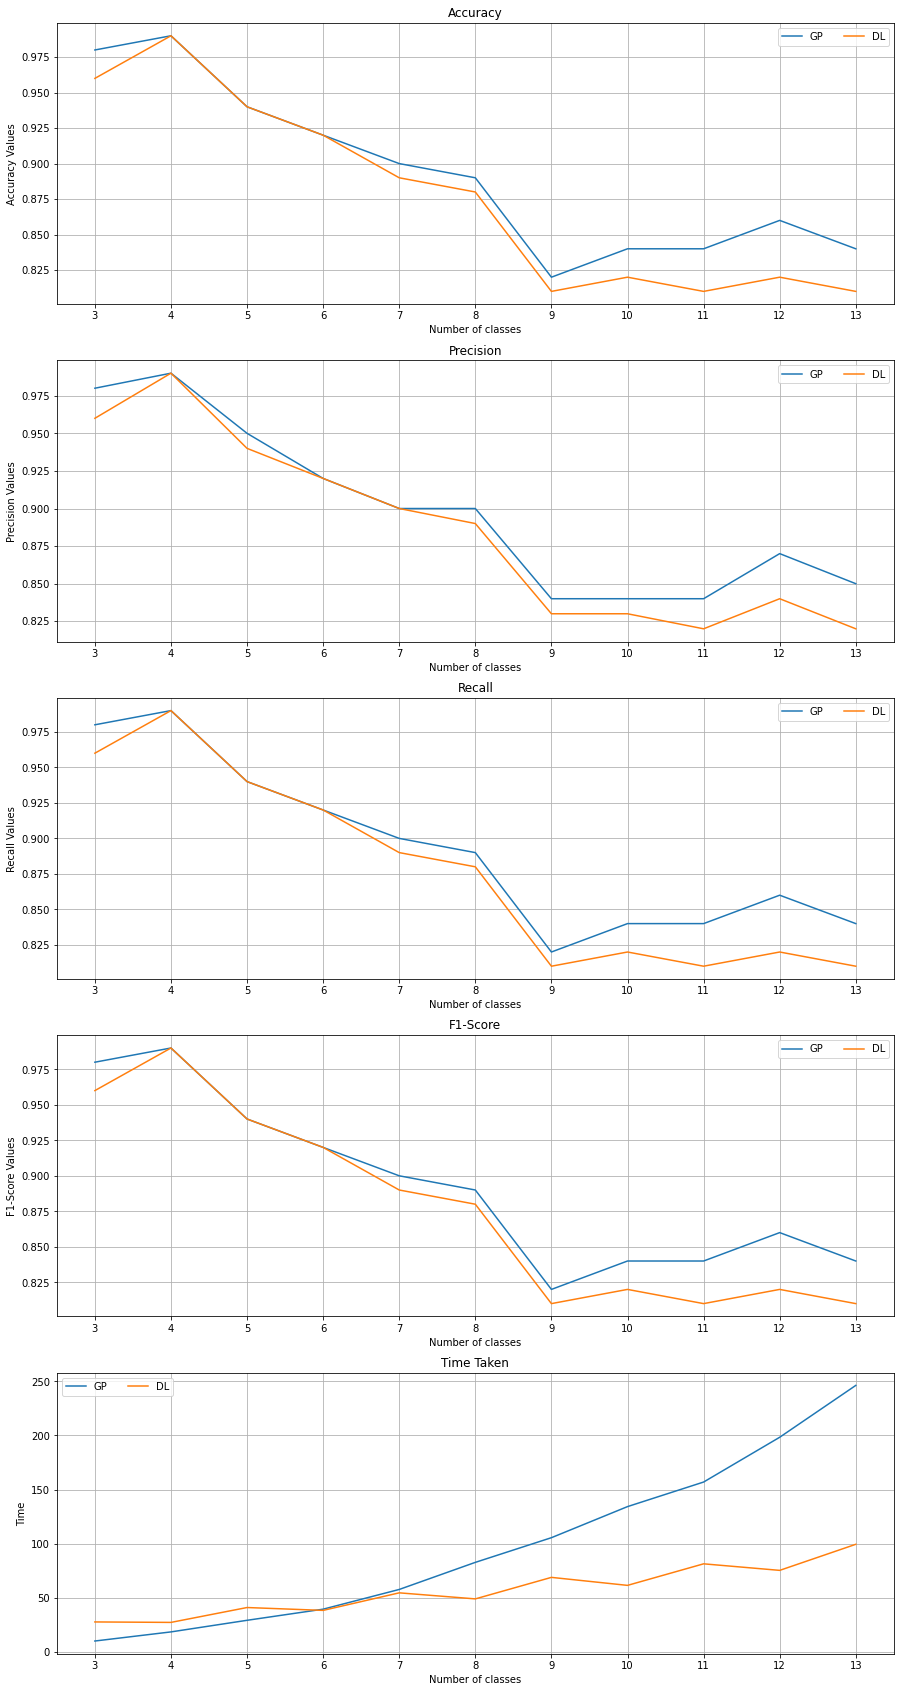

In [13]:
run_models(dl_model_1, 500)

# Using 1000 object per class Dataset

Dataset Shape: (12000, 107)

For number of classes: 3

X_train:  (2400, 105) , y_train:  (2400,) , X_test:  (600, 105) , y_test:  (600,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 29.08 seconds

Evaluation GP Model results:
Precision:  0.99
Recall:  0.99
F1-Score:  0.99
Accuracy:  0.99

Per Class Results:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       213
           1       1.00      0.99      1.00       180
           2       0.97      1.00      0.98       207

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



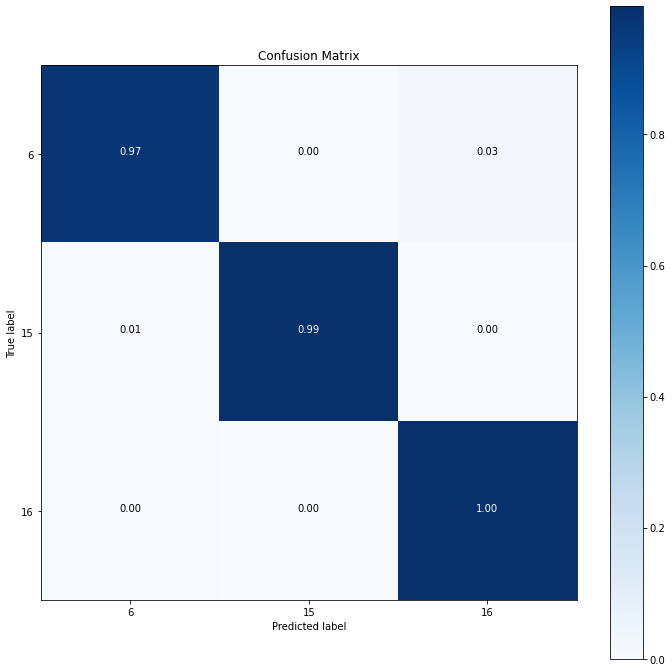


DL evaluation:

Model summary:
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 256)               27136     
_________________________________________________________________
dense_34 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_35 (Dense)             (None, 3)                 195       
_________________________________________________________________
activation_11 (Activation)   (None, 3)                 0         
Total params: 43,779
Trainable params: 43,779
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
 1/75 [..............................] - ETA: 0s - loss: 1.1503 - accuracy: 0.3125

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2], y=[0 0 2 ... 0 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


75/75 [==============================] - 0s 3ms/step - loss: 0.1449 - accuracy: 0.9454 - val_loss: 0.1173 - val_accuracy: 0.9817
Epoch 2/500
75/75 [==============================] - 0s 976us/step - loss: 0.0386 - accuracy: 0.9892 - val_loss: 0.5744 - val_accuracy: 0.9800
Epoch 3/500
75/75 [==============================] - 0s 927us/step - loss: 0.0387 - accuracy: 0.9904 - val_loss: 0.9964 - val_accuracy: 0.9700
Epoch 4/500
75/75 [==============================] - 0s 933us/step - loss: 0.0459 - accuracy: 0.9854 - val_loss: 0.0734 - val_accuracy: 0.9833
Epoch 5/500
75/75 [==============================] - 0s 988us/step - loss: 0.0240 - accuracy: 0.9937 - val_loss: 0.0701 - val_accuracy: 0.9867
Epoch 6/500
75/75 [==============================] - 0s 932us/step - loss: 0.0176 - accuracy: 0.9942 - val_loss: 0.0714 - val_accuracy: 0.9883
Epoch 7/500
75/75 [==============================] - 0s 905us/step - loss: 0.0130 - accuracy: 0.9967 - val_loss: 0.0723 - val_accuracy: 0.9917
Epoch 8/500
7

75/75 [==============================] - 0s 942us/step - loss: 7.2408e-06 - accuracy: 1.0000 - val_loss: 1.4355 - val_accuracy: 0.9850
Epoch 113/500
75/75 [==============================] - 0s 927us/step - loss: 6.7685e-06 - accuracy: 1.0000 - val_loss: 1.4592 - val_accuracy: 0.9850
Epoch 114/500
75/75 [==============================] - 0s 951us/step - loss: 6.9370e-06 - accuracy: 1.0000 - val_loss: 1.4546 - val_accuracy: 0.9850
Epoch 115/500
75/75 [==============================] - 0s 950us/step - loss: 5.7925e-06 - accuracy: 1.0000 - val_loss: 1.4782 - val_accuracy: 0.9850
Epoch 116/500
75/75 [==============================] - 0s 930us/step - loss: 5.8870e-06 - accuracy: 1.0000 - val_loss: 1.4849 - val_accuracy: 0.9850
Epoch 117/500
75/75 [==============================] - 0s 939us/step - loss: 5.4258e-06 - accuracy: 1.0000 - val_loss: 1.4819 - val_accuracy: 0.9850
Epoch 118/500
75/75 [==============================] - 0s 951us/step - loss: 5.8161e-06 - accuracy: 1.0000 - val_loss: 1

75/75 [==============================] - 0s 972us/step - loss: 2.4440e-05 - accuracy: 1.0000 - val_loss: 1.2530 - val_accuracy: 0.9833
Epoch 223/500
75/75 [==============================] - 0s 930us/step - loss: 2.3466e-05 - accuracy: 1.0000 - val_loss: 1.2202 - val_accuracy: 0.9833
Epoch 224/500
75/75 [==============================] - 0s 889us/step - loss: 2.2366e-05 - accuracy: 1.0000 - val_loss: 0.9601 - val_accuracy: 0.9833
Epoch 225/500
75/75 [==============================] - 0s 908us/step - loss: 2.4047e-05 - accuracy: 1.0000 - val_loss: 1.0502 - val_accuracy: 0.9850
Epoch 226/500
75/75 [==============================] - 0s 913us/step - loss: 2.3062e-05 - accuracy: 1.0000 - val_loss: 1.0863 - val_accuracy: 0.9833
Epoch 227/500
75/75 [==============================] - 0s 933us/step - loss: 2.0445e-05 - accuracy: 1.0000 - val_loss: 1.1539 - val_accuracy: 0.9850
Epoch 228/500
75/75 [==============================] - 0s 964us/step - loss: 2.0489e-05 - accuracy: 1.0000 - val_loss: 1

75/75 [==============================] - 0s 1ms/step - loss: 3.7538e-07 - accuracy: 1.0000 - val_loss: 1.8874 - val_accuracy: 0.9833
Epoch 333/500
75/75 [==============================] - 0s 968us/step - loss: 3.1336e-07 - accuracy: 1.0000 - val_loss: 1.9066 - val_accuracy: 0.9833
Epoch 334/500
75/75 [==============================] - 0s 1ms/step - loss: 2.9022e-07 - accuracy: 1.0000 - val_loss: 1.8947 - val_accuracy: 0.9833
Epoch 335/500
75/75 [==============================] - 0s 1ms/step - loss: 2.8587e-07 - accuracy: 1.0000 - val_loss: 1.9138 - val_accuracy: 0.9833
Epoch 336/500
75/75 [==============================] - 0s 1ms/step - loss: 2.6722e-07 - accuracy: 1.0000 - val_loss: 1.9460 - val_accuracy: 0.9833
Epoch 337/500
75/75 [==============================] - 0s 1ms/step - loss: 2.6350e-07 - accuracy: 1.0000 - val_loss: 1.9696 - val_accuracy: 0.9833
Epoch 338/500
75/75 [==============================] - 0s 1ms/step - loss: 2.8016e-07 - accuracy: 1.0000 - val_loss: 1.9439 - val_

75/75 [==============================] - 0s 1ms/step - loss: 4.8736e-09 - accuracy: 1.0000 - val_loss: 2.4743 - val_accuracy: 0.9833
Epoch 443/500
75/75 [==============================] - 0s 1ms/step - loss: 4.4253e-09 - accuracy: 1.0000 - val_loss: 2.4088 - val_accuracy: 0.9850
Epoch 444/500
75/75 [==============================] - 0s 1ms/step - loss: 4.4193e-09 - accuracy: 1.0000 - val_loss: 2.4674 - val_accuracy: 0.9833
Epoch 445/500
75/75 [==============================] - 0s 1ms/step - loss: 4.3679e-09 - accuracy: 1.0000 - val_loss: 2.4957 - val_accuracy: 0.9833
Epoch 446/500
75/75 [==============================] - 0s 1ms/step - loss: 4.3753e-09 - accuracy: 1.0000 - val_loss: 2.4717 - val_accuracy: 0.9833
Epoch 447/500
75/75 [==============================] - 0s 1ms/step - loss: 3.6711e-09 - accuracy: 1.0000 - val_loss: 2.4353 - val_accuracy: 0.9850
Epoch 448/500
75/75 [==============================] - 0s 1ms/step - loss: 3.5608e-09 - accuracy: 1.0000 - val_loss: 2.5256 - val_ac

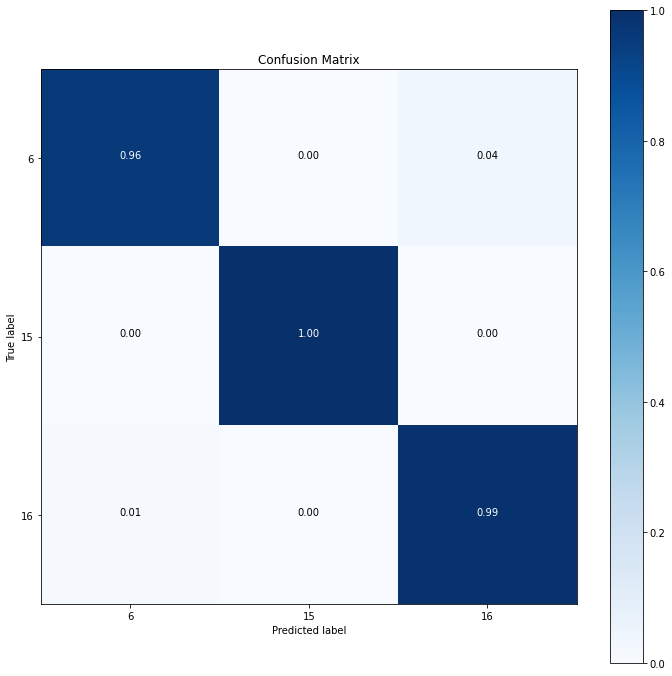


For number of classes: 4

X_train:  (3200, 105) , y_train:  (3200,) , X_test:  (800, 105) , y_test:  (800,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 77.94 seconds

Evaluation GP Model results:
Precision:  0.99
Recall:  0.99
F1-Score:  0.99
Accuracy:  0.99

Per Class Results:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       197
           1       1.00      0.98      0.99       198
           2       0.97      1.00      0.98       214
           3       0.98      1.00      0.99       191

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



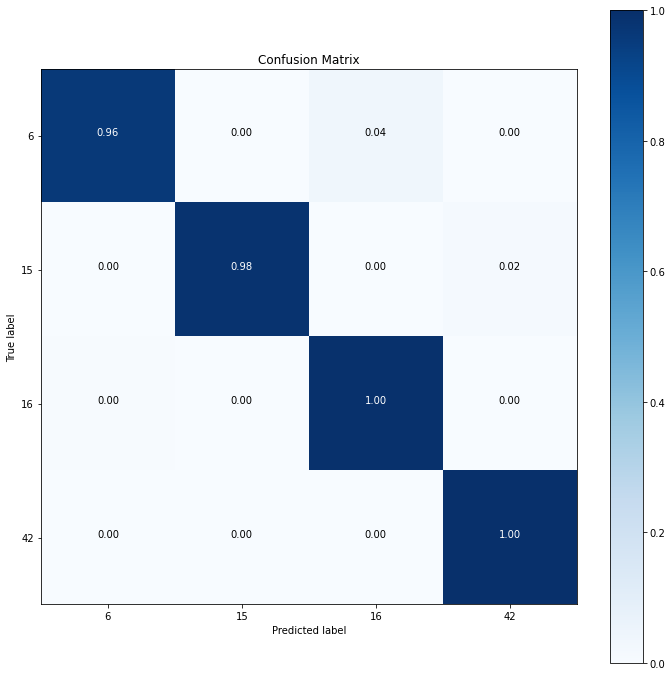


DL evaluation:

Model summary:
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 256)               27136     
_________________________________________________________________
dense_37 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_38 (Dense)             (None, 4)                 260       
_________________________________________________________________
activation_12 (Activation)   (None, 4)                 0         
Total params: 43,844
Trainable params: 43,844
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
  1/100 [..............................] - ETA: 0s - loss: 1.6636 - accuracy: 0.2812

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3], y=[3 3 1 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


100/100 [==============================] - 0s 2ms/step - loss: 0.1826 - accuracy: 0.9375 - val_loss: 0.0620 - val_accuracy: 0.9837
Epoch 2/500
100/100 [==============================] - 0s 952us/step - loss: 0.0848 - accuracy: 0.9816 - val_loss: 0.0522 - val_accuracy: 0.9825
Epoch 3/500
100/100 [==============================] - 0s 878us/step - loss: 0.0503 - accuracy: 0.9866 - val_loss: 0.0457 - val_accuracy: 0.9837
Epoch 4/500
100/100 [==============================] - 0s 952us/step - loss: 0.0423 - accuracy: 0.9894 - val_loss: 0.0499 - val_accuracy: 0.9850
Epoch 5/500
100/100 [==============================] - 0s 929us/step - loss: 0.0429 - accuracy: 0.9866 - val_loss: 0.0469 - val_accuracy: 0.9850
Epoch 6/500
100/100 [==============================] - 0s 882us/step - loss: 0.0404 - accuracy: 0.9894 - val_loss: 0.0420 - val_accuracy: 0.9862
Epoch 7/500
100/100 [==============================] - 0s 866us/step - loss: 0.0385 - accuracy: 0.9894 - val_loss: 0.0447 - val_accuracy: 0.9887

100/100 [==============================] - 0s 933us/step - loss: 0.0146 - accuracy: 0.9966 - val_loss: 0.0421 - val_accuracy: 0.9912
Epoch 114/500
100/100 [==============================] - 0s 943us/step - loss: 0.0165 - accuracy: 0.9962 - val_loss: 0.0389 - val_accuracy: 0.9925
Epoch 115/500
100/100 [==============================] - 0s 885us/step - loss: 0.0138 - accuracy: 0.9969 - val_loss: 0.0331 - val_accuracy: 0.9937
Epoch 116/500
100/100 [==============================] - 0s 896us/step - loss: 0.0143 - accuracy: 0.9959 - val_loss: 0.0377 - val_accuracy: 0.9925
Epoch 117/500
100/100 [==============================] - 0s 910us/step - loss: 0.0165 - accuracy: 0.9956 - val_loss: 0.0369 - val_accuracy: 0.9912
Epoch 118/500
100/100 [==============================] - 0s 925us/step - loss: 0.0143 - accuracy: 0.9947 - val_loss: 0.0558 - val_accuracy: 0.9875
Epoch 119/500
100/100 [==============================] - 0s 863us/step - loss: 0.0110 - accuracy: 0.9969 - val_loss: 0.0416 - val_ac

Epoch 169/500
100/100 [==============================] - 0s 896us/step - loss: 0.0173 - accuracy: 0.9962 - val_loss: 0.0327 - val_accuracy: 0.9937
Epoch 170/500
100/100 [==============================] - 0s 996us/step - loss: 0.0132 - accuracy: 0.9956 - val_loss: 0.0362 - val_accuracy: 0.9950
Epoch 171/500
100/100 [==============================] - 0s 933us/step - loss: 0.0122 - accuracy: 0.9966 - val_loss: 0.0312 - val_accuracy: 0.9937
Epoch 172/500
100/100 [==============================] - 0s 935us/step - loss: 0.0269 - accuracy: 0.9953 - val_loss: 0.2716 - val_accuracy: 0.9837
Epoch 173/500
100/100 [==============================] - 0s 949us/step - loss: 0.0439 - accuracy: 0.9906 - val_loss: 0.0436 - val_accuracy: 0.9925
Epoch 174/500
100/100 [==============================] - 0s 947us/step - loss: 0.0319 - accuracy: 0.9928 - val_loss: 0.0875 - val_accuracy: 0.9800
Epoch 175/500
100/100 [==============================] - 0s 930us/step - loss: 0.0217 - accuracy: 0.9937 - val_loss: 0

Epoch 225/500
100/100 [==============================] - 0s 933us/step - loss: 0.0098 - accuracy: 0.9981 - val_loss: 0.0422 - val_accuracy: 0.9950
Epoch 226/500
100/100 [==============================] - 0s 994us/step - loss: 0.0091 - accuracy: 0.9978 - val_loss: 0.0397 - val_accuracy: 0.9950
Epoch 227/500
100/100 [==============================] - 0s 938us/step - loss: 0.0094 - accuracy: 0.9978 - val_loss: 0.0435 - val_accuracy: 0.9950
Epoch 228/500
100/100 [==============================] - 0s 945us/step - loss: 0.0486 - accuracy: 0.9909 - val_loss: 0.0740 - val_accuracy: 0.9875
Epoch 229/500
100/100 [==============================] - 0s 929us/step - loss: 0.0437 - accuracy: 0.9919 - val_loss: 0.0547 - val_accuracy: 0.9912
Epoch 230/500
100/100 [==============================] - 0s 891us/step - loss: 0.0202 - accuracy: 0.9950 - val_loss: 0.0605 - val_accuracy: 0.9900
Epoch 231/500
100/100 [==============================] - 0s 923us/step - loss: 0.0480 - accuracy: 0.9941 - val_loss: 0

Epoch 336/500
100/100 [==============================] - 0s 943us/step - loss: 0.0124 - accuracy: 0.9969 - val_loss: 0.0446 - val_accuracy: 0.9950
Epoch 337/500
100/100 [==============================] - 0s 948us/step - loss: 0.0142 - accuracy: 0.9962 - val_loss: 0.0446 - val_accuracy: 0.9950
Epoch 338/500
100/100 [==============================] - 0s 914us/step - loss: 0.0110 - accuracy: 0.9975 - val_loss: 0.0408 - val_accuracy: 0.9950
Epoch 339/500
100/100 [==============================] - 0s 929us/step - loss: 0.0104 - accuracy: 0.9969 - val_loss: 0.0432 - val_accuracy: 0.9950
Epoch 340/500
100/100 [==============================] - 0s 902us/step - loss: 0.0116 - accuracy: 0.9969 - val_loss: 0.0444 - val_accuracy: 0.9937
Epoch 341/500
100/100 [==============================] - 0s 941us/step - loss: 0.0157 - accuracy: 0.9959 - val_loss: 0.0349 - val_accuracy: 0.9950
Epoch 342/500
100/100 [==============================] - 0s 951us/step - loss: 0.0112 - accuracy: 0.9969 - val_loss: 0

Epoch 392/500
100/100 [==============================] - 0s 902us/step - loss: 0.0113 - accuracy: 0.9972 - val_loss: 0.0364 - val_accuracy: 0.9950
Epoch 393/500
100/100 [==============================] - 0s 958us/step - loss: 0.0099 - accuracy: 0.9978 - val_loss: 0.0347 - val_accuracy: 0.9937
Epoch 394/500
100/100 [==============================] - 0s 899us/step - loss: 0.0107 - accuracy: 0.9969 - val_loss: 0.0363 - val_accuracy: 0.9925
Epoch 395/500
100/100 [==============================] - 0s 892us/step - loss: 0.0099 - accuracy: 0.9978 - val_loss: 0.0381 - val_accuracy: 0.9937
Epoch 396/500
100/100 [==============================] - 0s 888us/step - loss: 0.0089 - accuracy: 0.9984 - val_loss: 0.0393 - val_accuracy: 0.9937
Epoch 397/500
100/100 [==============================] - 0s 898us/step - loss: 0.0085 - accuracy: 0.9978 - val_loss: 0.0360 - val_accuracy: 0.9937
Epoch 398/500
100/100 [==============================] - 0s 934us/step - loss: 0.0088 - accuracy: 0.9981 - val_loss: 0

Epoch 448/500
100/100 [==============================] - 0s 911us/step - loss: 0.0085 - accuracy: 0.9984 - val_loss: 0.0424 - val_accuracy: 0.9937
Epoch 449/500
100/100 [==============================] - 0s 1ms/step - loss: 0.0086 - accuracy: 0.9981 - val_loss: 0.0414 - val_accuracy: 0.9937
Epoch 450/500
100/100 [==============================] - 0s 895us/step - loss: 0.0093 - accuracy: 0.9984 - val_loss: 0.0454 - val_accuracy: 0.9950
Epoch 451/500
100/100 [==============================] - 0s 965us/step - loss: 0.0079 - accuracy: 0.9981 - val_loss: 0.0447 - val_accuracy: 0.9937
Epoch 452/500
100/100 [==============================] - 0s 899us/step - loss: 0.0096 - accuracy: 0.9981 - val_loss: 0.0450 - val_accuracy: 0.9950
Epoch 453/500
100/100 [==============================] - 0s 917us/step - loss: 0.0085 - accuracy: 0.9981 - val_loss: 0.0435 - val_accuracy: 0.9950
Epoch 454/500
100/100 [==============================] - 0s 927us/step - loss: 0.0089 - accuracy: 0.9978 - val_loss: 0.0

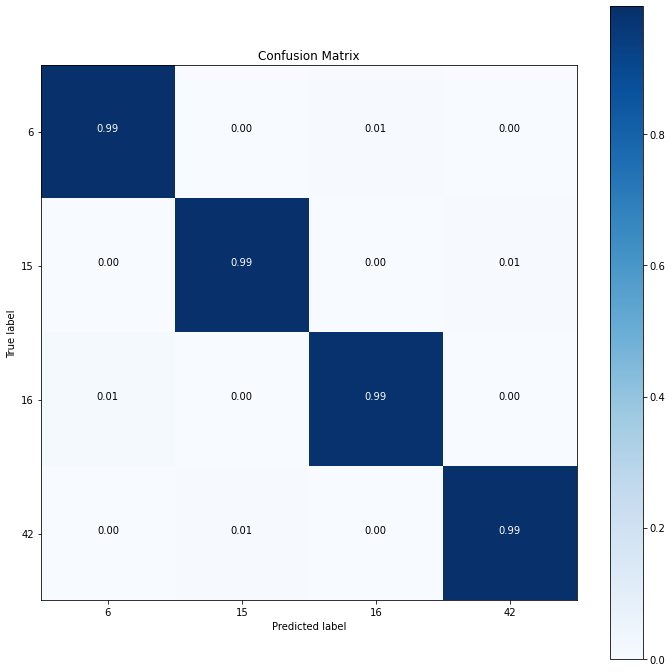


For number of classes: 5

X_train:  (4000, 105) , y_train:  (4000,) , X_test:  (1000, 105) , y_test:  (1000,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 132.06 seconds

Evaluation GP Model results:
Precision:  0.93
Recall:  0.93
F1-Score:  0.93
Accuracy:  0.93

Per Class Results:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       182
           1       0.91      0.94      0.92       185
           2       0.99      1.00      1.00       229
           3       0.82      0.98      0.89       193
           4       0.94      0.73      0.82       211

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



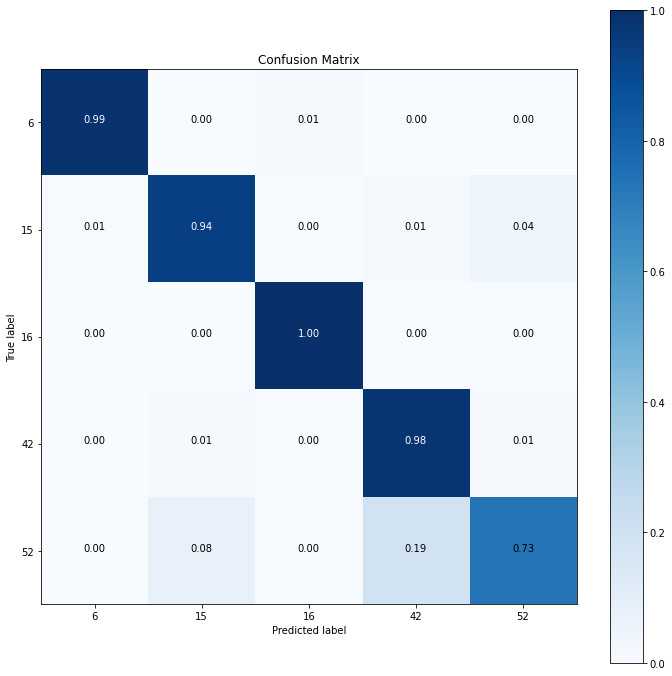


DL evaluation:

Model summary:
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 256)               27136     
_________________________________________________________________
dense_40 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_41 (Dense)             (None, 5)                 325       
_________________________________________________________________
activation_13 (Activation)   (None, 5)                 0         
Total params: 43,909
Trainable params: 43,909
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
  1/125 [..............................] - ETA: 0s - loss: 1.8554 - accuracy: 0.1875

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4], y=[2 2 1 ... 0 0 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


125/125 [==============================] - 0s 1ms/step - loss: 0.3361 - accuracy: 0.8852 - val_loss: 0.2183 - val_accuracy: 0.9120
Epoch 2/500
125/125 [==============================] - 0s 916us/step - loss: 0.2420 - accuracy: 0.9085 - val_loss: 0.4656 - val_accuracy: 0.9080
Epoch 3/500
125/125 [==============================] - 0s 870us/step - loss: 0.2017 - accuracy: 0.9218 - val_loss: 0.8463 - val_accuracy: 0.9180
Epoch 4/500
125/125 [==============================] - 0s 1ms/step - loss: 0.1863 - accuracy: 0.9247 - val_loss: 0.5024 - val_accuracy: 0.9180
Epoch 5/500
125/125 [==============================] - 0s 913us/step - loss: 0.1822 - accuracy: 0.9262 - val_loss: 0.4007 - val_accuracy: 0.9170
Epoch 6/500
125/125 [==============================] - 0s 1ms/step - loss: 0.1806 - accuracy: 0.9273 - val_loss: 1.3258 - val_accuracy: 0.9290
Epoch 7/500
125/125 [==============================] - 0s 933us/step - loss: 0.1881 - accuracy: 0.9208 - val_loss: 0.9661 - val_accuracy: 0.9150
Epo

125/125 [==============================] - 0s 984us/step - loss: 0.1331 - accuracy: 0.9402 - val_loss: 0.9447 - val_accuracy: 0.9200
Epoch 114/500
125/125 [==============================] - 0s 1ms/step - loss: 0.1359 - accuracy: 0.9415 - val_loss: 0.9541 - val_accuracy: 0.9260
Epoch 115/500
125/125 [==============================] - 0s 994us/step - loss: 0.1308 - accuracy: 0.9460 - val_loss: 1.0390 - val_accuracy: 0.9270
Epoch 116/500
125/125 [==============================] - 0s 1ms/step - loss: 0.1336 - accuracy: 0.9442 - val_loss: 0.9203 - val_accuracy: 0.9250
Epoch 117/500
125/125 [==============================] - 0s 960us/step - loss: 0.1351 - accuracy: 0.9427 - val_loss: 0.9197 - val_accuracy: 0.9220
Epoch 118/500
125/125 [==============================] - 0s 979us/step - loss: 0.1335 - accuracy: 0.9440 - val_loss: 1.0068 - val_accuracy: 0.9200
Epoch 119/500
125/125 [==============================] - 0s 992us/step - loss: 0.1325 - accuracy: 0.9440 - val_loss: 0.9309 - val_accura

Epoch 169/500
125/125 [==============================] - 0s 969us/step - loss: 0.1287 - accuracy: 0.9433 - val_loss: 1.1176 - val_accuracy: 0.9270
Epoch 170/500
125/125 [==============================] - 0s 977us/step - loss: 0.1277 - accuracy: 0.9457 - val_loss: 1.0730 - val_accuracy: 0.9270
Epoch 171/500
125/125 [==============================] - 0s 946us/step - loss: 0.1279 - accuracy: 0.9457 - val_loss: 1.0685 - val_accuracy: 0.9270
Epoch 172/500
125/125 [==============================] - 0s 951us/step - loss: 0.1296 - accuracy: 0.9452 - val_loss: 0.9945 - val_accuracy: 0.9290
Epoch 173/500
125/125 [==============================] - 0s 927us/step - loss: 0.1297 - accuracy: 0.9445 - val_loss: 0.9838 - val_accuracy: 0.9290
Epoch 174/500
125/125 [==============================] - 0s 916us/step - loss: 0.1264 - accuracy: 0.9467 - val_loss: 1.1381 - val_accuracy: 0.9270
Epoch 175/500
125/125 [==============================] - 0s 939us/step - loss: 0.1285 - accuracy: 0.9463 - val_loss: 0

Epoch 225/500
125/125 [==============================] - 0s 935us/step - loss: 0.1253 - accuracy: 0.9482 - val_loss: 1.2439 - val_accuracy: 0.9350
Epoch 226/500
125/125 [==============================] - 0s 930us/step - loss: 0.1285 - accuracy: 0.9455 - val_loss: 1.1008 - val_accuracy: 0.9310
Epoch 227/500
125/125 [==============================] - 0s 962us/step - loss: 0.1244 - accuracy: 0.9477 - val_loss: 1.2678 - val_accuracy: 0.9300
Epoch 228/500
125/125 [==============================] - 0s 973us/step - loss: 0.1296 - accuracy: 0.9473 - val_loss: 1.1562 - val_accuracy: 0.9330
Epoch 229/500
125/125 [==============================] - 0s 921us/step - loss: 0.1264 - accuracy: 0.9427 - val_loss: 0.9674 - val_accuracy: 0.9290
Epoch 230/500
125/125 [==============================] - 0s 999us/step - loss: 0.1274 - accuracy: 0.9475 - val_loss: 1.1301 - val_accuracy: 0.9260
Epoch 231/500
125/125 [==============================] - 0s 1ms/step - loss: 0.2177 - accuracy: 0.9370 - val_loss: 1.4

Epoch 281/500
125/125 [==============================] - 0s 930us/step - loss: 0.1245 - accuracy: 0.9480 - val_loss: 1.3928 - val_accuracy: 0.9240
Epoch 282/500
125/125 [==============================] - 0s 929us/step - loss: 0.1239 - accuracy: 0.9488 - val_loss: 1.4359 - val_accuracy: 0.9370
Epoch 283/500
125/125 [==============================] - 0s 970us/step - loss: 0.1245 - accuracy: 0.9467 - val_loss: 1.3604 - val_accuracy: 0.9300
Epoch 284/500
125/125 [==============================] - 0s 968us/step - loss: 0.1225 - accuracy: 0.9492 - val_loss: 1.3567 - val_accuracy: 0.9280
Epoch 285/500
125/125 [==============================] - 0s 959us/step - loss: 0.1248 - accuracy: 0.9482 - val_loss: 1.4350 - val_accuracy: 0.9310
Epoch 286/500
125/125 [==============================] - 0s 912us/step - loss: 0.1315 - accuracy: 0.9467 - val_loss: 1.3641 - val_accuracy: 0.9310
Epoch 287/500
125/125 [==============================] - 0s 939us/step - loss: 0.1449 - accuracy: 0.9392 - val_loss: 1

Epoch 337/500
125/125 [==============================] - 0s 949us/step - loss: 0.1231 - accuracy: 0.9463 - val_loss: 1.3931 - val_accuracy: 0.9310
Epoch 338/500
125/125 [==============================] - 0s 929us/step - loss: 0.1225 - accuracy: 0.9480 - val_loss: 1.2674 - val_accuracy: 0.9270
Epoch 339/500
125/125 [==============================] - 0s 973us/step - loss: 0.1225 - accuracy: 0.9482 - val_loss: 1.2568 - val_accuracy: 0.9360
Epoch 340/500
125/125 [==============================] - 0s 959us/step - loss: 0.1213 - accuracy: 0.9492 - val_loss: 1.2452 - val_accuracy: 0.9250
Epoch 341/500
125/125 [==============================] - 0s 911us/step - loss: 0.1225 - accuracy: 0.9498 - val_loss: 1.2670 - val_accuracy: 0.9380
Epoch 342/500
125/125 [==============================] - 0s 911us/step - loss: 0.1226 - accuracy: 0.9475 - val_loss: 1.2360 - val_accuracy: 0.9350
Epoch 343/500
125/125 [==============================] - 0s 931us/step - loss: 0.1232 - accuracy: 0.9498 - val_loss: 1

Epoch 393/500
125/125 [==============================] - 0s 951us/step - loss: 0.1200 - accuracy: 0.9477 - val_loss: 1.7023 - val_accuracy: 0.9360
Epoch 394/500
125/125 [==============================] - 0s 954us/step - loss: 0.1196 - accuracy: 0.9492 - val_loss: 1.6206 - val_accuracy: 0.9300
Epoch 395/500
125/125 [==============================] - 0s 929us/step - loss: 0.1221 - accuracy: 0.9475 - val_loss: 1.6165 - val_accuracy: 0.9380
Epoch 396/500
125/125 [==============================] - 0s 958us/step - loss: 0.1202 - accuracy: 0.9492 - val_loss: 1.6741 - val_accuracy: 0.9300
Epoch 397/500
125/125 [==============================] - 0s 1ms/step - loss: 0.1196 - accuracy: 0.9520 - val_loss: 1.4814 - val_accuracy: 0.9330
Epoch 398/500
125/125 [==============================] - 0s 996us/step - loss: 0.1206 - accuracy: 0.9488 - val_loss: 1.5176 - val_accuracy: 0.9380
Epoch 399/500
125/125 [==============================] - 0s 1ms/step - loss: 0.1203 - accuracy: 0.9490 - val_loss: 1.484

Epoch 449/500
125/125 [==============================] - 0s 954us/step - loss: 0.1191 - accuracy: 0.9503 - val_loss: 1.5970 - val_accuracy: 0.9360
Epoch 450/500
125/125 [==============================] - 0s 987us/step - loss: 0.1188 - accuracy: 0.9510 - val_loss: 1.6607 - val_accuracy: 0.9330
Epoch 451/500
125/125 [==============================] - 0s 939us/step - loss: 0.1200 - accuracy: 0.9513 - val_loss: 1.5938 - val_accuracy: 0.9260
Epoch 452/500
125/125 [==============================] - 0s 1ms/step - loss: 0.1205 - accuracy: 0.9480 - val_loss: 1.6399 - val_accuracy: 0.9380
Epoch 453/500
125/125 [==============================] - 0s 1ms/step - loss: 0.1191 - accuracy: 0.9490 - val_loss: 1.5430 - val_accuracy: 0.9330
Epoch 454/500
125/125 [==============================] - 0s 985us/step - loss: 0.1202 - accuracy: 0.9490 - val_loss: 1.6770 - val_accuracy: 0.9310
Epoch 455/500
125/125 [==============================] - 0s 963us/step - loss: 0.1237 - accuracy: 0.9480 - val_loss: 1.567

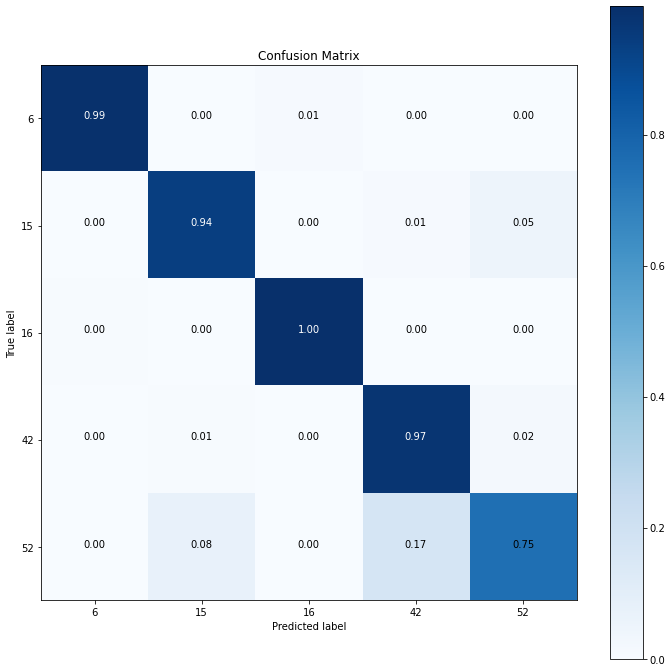


For number of classes: 6

X_train:  (4800, 105) , y_train:  (4800,) , X_test:  (1200, 105) , y_test:  (1200,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 189.40 seconds

Evaluation GP Model results:
Precision:  0.94
Recall:  0.94
F1-Score:  0.94
Accuracy:  0.94

Per Class Results:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       201
           1       0.95      0.90      0.92       182
           2       1.00      0.98      0.99       220
           3       0.84      0.96      0.90       193
           4       0.87      0.80      0.83       196
           5       0.99      0.98      0.99       208

    accuracy                           0.94      1200
   macro avg       0.94      0.93      0.93      1200
weighted avg       0.94      0.94      0.94      1200



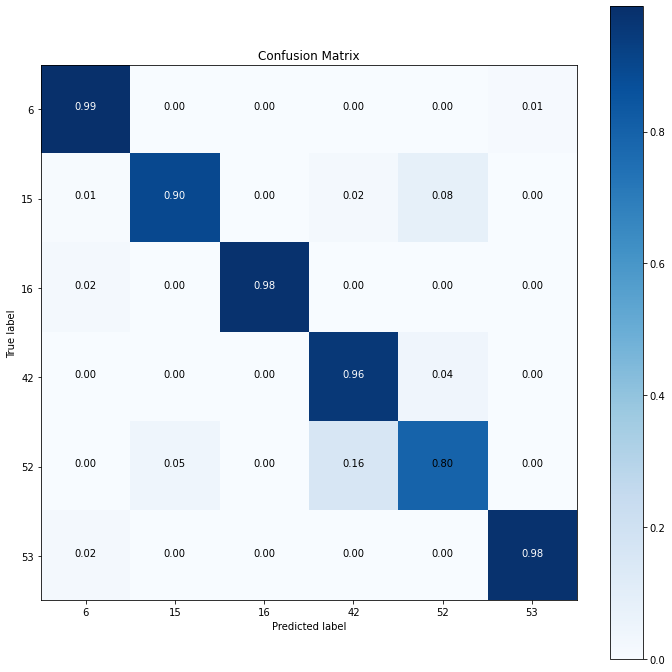


DL evaluation:

Model summary:
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 256)               27136     
_________________________________________________________________
dense_43 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_44 (Dense)             (None, 6)                 390       
_________________________________________________________________
activation_14 (Activation)   (None, 6)                 0         
Total params: 43,974
Trainable params: 43,974
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
  1/150 [..............................] - ETA: 0s - loss: 1.7447 - accuracy: 0.1875

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4 5], y=[1 0 1 ... 2 3 5] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


150/150 [==============================] - 0s 1ms/step - loss: 0.3721 - accuracy: 0.8804 - val_loss: 0.2360 - val_accuracy: 0.9000
Epoch 2/500
150/150 [==============================] - 0s 900us/step - loss: 0.2512 - accuracy: 0.9158 - val_loss: 0.2453 - val_accuracy: 0.9125
Epoch 3/500
150/150 [==============================] - 0s 847us/step - loss: 0.3149 - accuracy: 0.9158 - val_loss: 0.2110 - val_accuracy: 0.9100
Epoch 4/500
150/150 [==============================] - 0s 907us/step - loss: 0.2040 - accuracy: 0.9240 - val_loss: 0.2367 - val_accuracy: 0.9133
Epoch 5/500
150/150 [==============================] - 0s 899us/step - loss: 0.1984 - accuracy: 0.9242 - val_loss: 0.2307 - val_accuracy: 0.9208
Epoch 6/500
150/150 [==============================] - 0s 899us/step - loss: 0.1804 - accuracy: 0.9296 - val_loss: 0.1987 - val_accuracy: 0.9242
Epoch 7/500
150/150 [==============================] - 0s 920us/step - loss: 0.1726 - accuracy: 0.9300 - val_loss: 0.2338 - val_accuracy: 0.9167

150/150 [==============================] - 0s 921us/step - loss: 0.1317 - accuracy: 0.9433 - val_loss: 0.2091 - val_accuracy: 0.9358
Epoch 114/500
150/150 [==============================] - 0s 903us/step - loss: 0.1332 - accuracy: 0.9431 - val_loss: 0.2365 - val_accuracy: 0.9283
Epoch 115/500
150/150 [==============================] - 0s 896us/step - loss: 0.1310 - accuracy: 0.9446 - val_loss: 0.2250 - val_accuracy: 0.9275
Epoch 116/500
150/150 [==============================] - 0s 924us/step - loss: 0.1286 - accuracy: 0.9429 - val_loss: 0.2214 - val_accuracy: 0.9292
Epoch 117/500
150/150 [==============================] - 0s 979us/step - loss: 0.1318 - accuracy: 0.9423 - val_loss: 0.2353 - val_accuracy: 0.9342
Epoch 118/500
150/150 [==============================] - 0s 917us/step - loss: 0.1402 - accuracy: 0.9442 - val_loss: 0.1911 - val_accuracy: 0.9333
Epoch 119/500
150/150 [==============================] - 0s 944us/step - loss: 0.1829 - accuracy: 0.9400 - val_loss: 0.2751 - val_ac

Epoch 169/500
150/150 [==============================] - 0s 865us/step - loss: 0.1262 - accuracy: 0.9448 - val_loss: 0.2204 - val_accuracy: 0.9317
Epoch 170/500
150/150 [==============================] - 0s 968us/step - loss: 0.1242 - accuracy: 0.9473 - val_loss: 0.2176 - val_accuracy: 0.9392
Epoch 171/500
150/150 [==============================] - 0s 927us/step - loss: 0.1259 - accuracy: 0.9465 - val_loss: 0.2030 - val_accuracy: 0.9375
Epoch 172/500
150/150 [==============================] - 0s 923us/step - loss: 0.1262 - accuracy: 0.9481 - val_loss: 0.2069 - val_accuracy: 0.9308
Epoch 173/500
150/150 [==============================] - 0s 972us/step - loss: 0.1265 - accuracy: 0.9463 - val_loss: 0.1951 - val_accuracy: 0.9358
Epoch 174/500
150/150 [==============================] - 0s 912us/step - loss: 0.1247 - accuracy: 0.9456 - val_loss: 0.2129 - val_accuracy: 0.9308
Epoch 175/500
150/150 [==============================] - 0s 930us/step - loss: 0.1230 - accuracy: 0.9483 - val_loss: 0

Epoch 225/500
150/150 [==============================] - 0s 1ms/step - loss: 0.1380 - accuracy: 0.9446 - val_loss: 0.1700 - val_accuracy: 0.9383
Epoch 226/500
150/150 [==============================] - 0s 961us/step - loss: 0.1235 - accuracy: 0.9442 - val_loss: 0.1996 - val_accuracy: 0.9308
Epoch 227/500
150/150 [==============================] - 0s 949us/step - loss: 0.1216 - accuracy: 0.9481 - val_loss: 0.2129 - val_accuracy: 0.9342
Epoch 228/500
150/150 [==============================] - 0s 955us/step - loss: 0.1207 - accuracy: 0.9492 - val_loss: 0.2166 - val_accuracy: 0.9350
Epoch 229/500
150/150 [==============================] - 0s 909us/step - loss: 0.1217 - accuracy: 0.9479 - val_loss: 0.2289 - val_accuracy: 0.9300
Epoch 230/500
150/150 [==============================] - 0s 932us/step - loss: 0.1205 - accuracy: 0.9471 - val_loss: 0.2192 - val_accuracy: 0.9350
Epoch 231/500
150/150 [==============================] - 0s 917us/step - loss: 0.1215 - accuracy: 0.9481 - val_loss: 0.2

Epoch 281/500
150/150 [==============================] - 0s 1ms/step - loss: 0.1246 - accuracy: 0.9463 - val_loss: 0.1786 - val_accuracy: 0.9408
Epoch 282/500
150/150 [==============================] - 0s 1ms/step - loss: 0.1181 - accuracy: 0.9485 - val_loss: 0.2164 - val_accuracy: 0.9367
Epoch 283/500
150/150 [==============================] - 0s 1ms/step - loss: 0.1219 - accuracy: 0.9485 - val_loss: 0.2315 - val_accuracy: 0.9358
Epoch 284/500
150/150 [==============================] - 0s 984us/step - loss: 0.1172 - accuracy: 0.9508 - val_loss: 0.2645 - val_accuracy: 0.9400
Epoch 285/500
150/150 [==============================] - 0s 1ms/step - loss: 0.1540 - accuracy: 0.9425 - val_loss: 0.1909 - val_accuracy: 0.9392
Epoch 286/500
150/150 [==============================] - 0s 1ms/step - loss: 0.1320 - accuracy: 0.9463 - val_loss: 0.3031 - val_accuracy: 0.9308
Epoch 287/500
150/150 [==============================] - 0s 1ms/step - loss: 0.1678 - accuracy: 0.9410 - val_loss: 0.2530 - val_

Epoch 337/500
150/150 [==============================] - 0s 957us/step - loss: 0.1183 - accuracy: 0.9485 - val_loss: 0.2561 - val_accuracy: 0.9383
Epoch 338/500
150/150 [==============================] - 0s 983us/step - loss: 0.1196 - accuracy: 0.9471 - val_loss: 0.2525 - val_accuracy: 0.9358
Epoch 339/500
150/150 [==============================] - 0s 943us/step - loss: 0.1390 - accuracy: 0.9458 - val_loss: 0.3663 - val_accuracy: 0.9308
Epoch 340/500
150/150 [==============================] - 0s 959us/step - loss: 0.1929 - accuracy: 0.9415 - val_loss: 0.3305 - val_accuracy: 0.9292
Epoch 341/500
150/150 [==============================] - 0s 919us/step - loss: 0.1863 - accuracy: 0.9419 - val_loss: 0.1878 - val_accuracy: 0.9342
Epoch 342/500
150/150 [==============================] - 0s 932us/step - loss: 0.1384 - accuracy: 0.9454 - val_loss: 0.2644 - val_accuracy: 0.9308
Epoch 343/500
150/150 [==============================] - 0s 938us/step - loss: 0.1294 - accuracy: 0.9469 - val_loss: 0

Epoch 393/500
150/150 [==============================] - 0s 951us/step - loss: 0.1174 - accuracy: 0.9496 - val_loss: 0.3270 - val_accuracy: 0.9300
Epoch 394/500
150/150 [==============================] - 0s 901us/step - loss: 0.1180 - accuracy: 0.9477 - val_loss: 0.2865 - val_accuracy: 0.9392
Epoch 395/500
150/150 [==============================] - 0s 912us/step - loss: 0.1180 - accuracy: 0.9498 - val_loss: 0.2850 - val_accuracy: 0.9358
Epoch 396/500
150/150 [==============================] - 0s 892us/step - loss: 0.1182 - accuracy: 0.9496 - val_loss: 0.2883 - val_accuracy: 0.9400
Epoch 397/500
150/150 [==============================] - 0s 865us/step - loss: 0.1182 - accuracy: 0.9477 - val_loss: 0.3028 - val_accuracy: 0.9350
Epoch 398/500
150/150 [==============================] - 0s 888us/step - loss: 0.1165 - accuracy: 0.9492 - val_loss: 0.3038 - val_accuracy: 0.9408
Epoch 399/500
150/150 [==============================] - 0s 893us/step - loss: 0.1185 - accuracy: 0.9475 - val_loss: 0

Epoch 449/500
150/150 [==============================] - 0s 853us/step - loss: 0.1145 - accuracy: 0.9496 - val_loss: 0.2817 - val_accuracy: 0.9383
Epoch 450/500
150/150 [==============================] - 0s 921us/step - loss: 0.1166 - accuracy: 0.9513 - val_loss: 0.2847 - val_accuracy: 0.9433
Epoch 451/500
150/150 [==============================] - 0s 908us/step - loss: 0.1125 - accuracy: 0.9525 - val_loss: 0.2899 - val_accuracy: 0.9375
Epoch 452/500
150/150 [==============================] - 0s 910us/step - loss: 0.1134 - accuracy: 0.9527 - val_loss: 0.2919 - val_accuracy: 0.9408
Epoch 453/500
150/150 [==============================] - 0s 908us/step - loss: 0.1150 - accuracy: 0.9521 - val_loss: 0.2857 - val_accuracy: 0.9408
Epoch 454/500
150/150 [==============================] - 0s 877us/step - loss: 0.1178 - accuracy: 0.9483 - val_loss: 0.3000 - val_accuracy: 0.9342
Epoch 455/500
150/150 [==============================] - 0s 976us/step - loss: 0.1141 - accuracy: 0.9496 - val_loss: 0

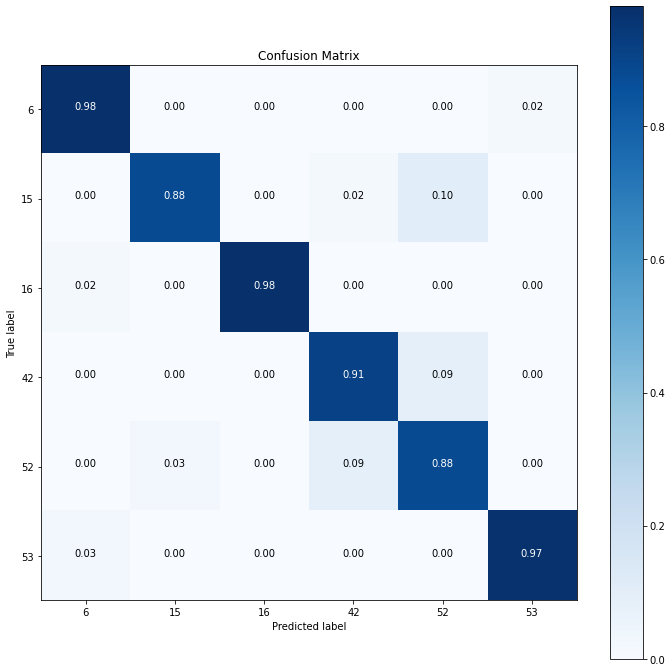


For number of classes: 7

X_train:  (5600, 105) , y_train:  (5600,) , X_test:  (1400, 105) , y_test:  (1400,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 266.45 seconds

Evaluation GP Model results:
Precision:  0.88
Recall:  0.88
F1-Score:  0.88
Accuracy:  0.88

Per Class Results:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       183
           1       0.96      0.93      0.95       197
           2       0.98      0.98      0.98       214
           3       0.82      0.88      0.85       195
           4       0.82      0.69      0.75       210
           5       0.97      0.97      0.97       195
           6       0.68      0.77      0.72       206

    accuracy                           0.88      1400
   macro avg       0.88      0.88      0.88      1400
weighted avg       0.88      0.88      0.88      1400



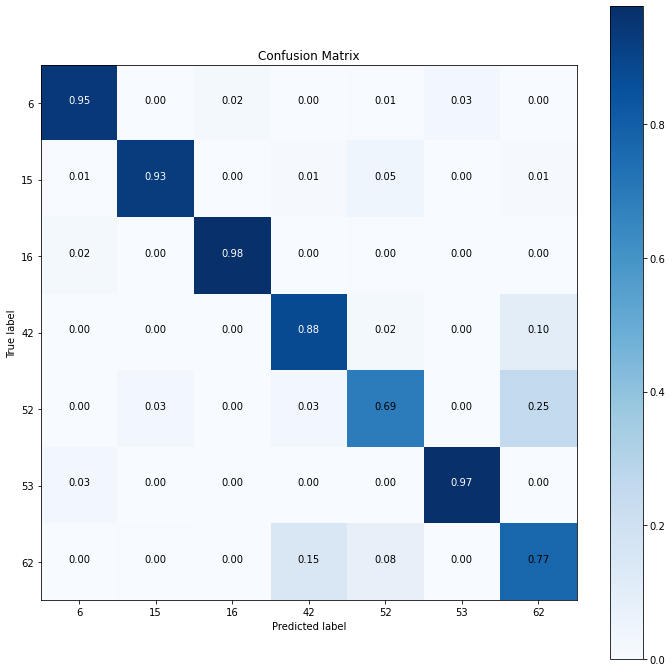


DL evaluation:

Model summary:
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 256)               27136     
_________________________________________________________________
dense_46 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_47 (Dense)             (None, 7)                 455       
_________________________________________________________________
activation_15 (Activation)   (None, 7)                 0         
Total params: 44,039
Trainable params: 44,039
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
  1/175 [..............................] - ETA: 0s - loss: 3.4489 - accuracy: 0.0625

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4 5 6], y=[1 3 1 ... 2 1 5] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


175/175 [==============================] - 0s 1ms/step - loss: 0.5493 - accuracy: 0.8123 - val_loss: 0.7229 - val_accuracy: 0.8479
Epoch 2/500
175/175 [==============================] - 0s 810us/step - loss: 0.3926 - accuracy: 0.8516 - val_loss: 0.9160 - val_accuracy: 0.8593
Epoch 3/500
175/175 [==============================] - 0s 863us/step - loss: 0.3813 - accuracy: 0.8600 - val_loss: 0.8822 - val_accuracy: 0.8571
Epoch 4/500
175/175 [==============================] - 0s 835us/step - loss: 0.3526 - accuracy: 0.8629 - val_loss: 0.5934 - val_accuracy: 0.8643
Epoch 5/500
175/175 [==============================] - 0s 853us/step - loss: 0.3691 - accuracy: 0.8639 - val_loss: 0.7013 - val_accuracy: 0.8493
Epoch 6/500
175/175 [==============================] - 0s 834us/step - loss: 0.3395 - accuracy: 0.8641 - val_loss: 0.8100 - val_accuracy: 0.8536
Epoch 7/500
175/175 [==============================] - 0s 790us/step - loss: 0.3231 - accuracy: 0.8704 - val_loss: 0.5553 - val_accuracy: 0.8671

175/175 [==============================] - 0s 833us/step - loss: 0.2716 - accuracy: 0.8863 - val_loss: 0.8933 - val_accuracy: 0.8771
Epoch 114/500
175/175 [==============================] - 0s 870us/step - loss: 0.2737 - accuracy: 0.8877 - val_loss: 0.9892 - val_accuracy: 0.8721
Epoch 115/500
175/175 [==============================] - 0s 841us/step - loss: 0.2741 - accuracy: 0.8866 - val_loss: 0.8991 - val_accuracy: 0.8743
Epoch 116/500
175/175 [==============================] - 0s 879us/step - loss: 0.2920 - accuracy: 0.8820 - val_loss: 0.8859 - val_accuracy: 0.8800
Epoch 117/500
175/175 [==============================] - 0s 879us/step - loss: 0.2737 - accuracy: 0.8871 - val_loss: 1.2631 - val_accuracy: 0.8750
Epoch 118/500
175/175 [==============================] - 0s 847us/step - loss: 0.3135 - accuracy: 0.8795 - val_loss: 1.1355 - val_accuracy: 0.8764
Epoch 119/500
175/175 [==============================] - 0s 834us/step - loss: 0.2746 - accuracy: 0.8870 - val_loss: 0.9971 - val_ac

Epoch 169/500
175/175 [==============================] - 0s 855us/step - loss: 0.2647 - accuracy: 0.8861 - val_loss: 0.8979 - val_accuracy: 0.8764
Epoch 170/500
175/175 [==============================] - 0s 843us/step - loss: 0.2690 - accuracy: 0.8884 - val_loss: 1.0824 - val_accuracy: 0.8786
Epoch 171/500
175/175 [==============================] - 0s 855us/step - loss: 0.2651 - accuracy: 0.8909 - val_loss: 1.0268 - val_accuracy: 0.8707
Epoch 172/500
175/175 [==============================] - 0s 859us/step - loss: 0.2656 - accuracy: 0.8904 - val_loss: 1.0353 - val_accuracy: 0.8779
Epoch 173/500
175/175 [==============================] - 0s 872us/step - loss: 0.2636 - accuracy: 0.8905 - val_loss: 0.9835 - val_accuracy: 0.8786
Epoch 174/500
175/175 [==============================] - 0s 842us/step - loss: 0.2685 - accuracy: 0.8911 - val_loss: 0.9330 - val_accuracy: 0.8743
Epoch 175/500
175/175 [==============================] - 0s 856us/step - loss: 0.2683 - accuracy: 0.8864 - val_loss: 1

Epoch 225/500
175/175 [==============================] - 0s 840us/step - loss: 0.2631 - accuracy: 0.8895 - val_loss: 1.1347 - val_accuracy: 0.8743
Epoch 226/500
175/175 [==============================] - 0s 848us/step - loss: 0.2651 - accuracy: 0.8916 - val_loss: 1.1254 - val_accuracy: 0.8757
Epoch 227/500
175/175 [==============================] - 0s 856us/step - loss: 0.2616 - accuracy: 0.8905 - val_loss: 1.0455 - val_accuracy: 0.8793
Epoch 228/500
175/175 [==============================] - 0s 847us/step - loss: 0.2735 - accuracy: 0.8896 - val_loss: 1.2392 - val_accuracy: 0.8757
Epoch 229/500
175/175 [==============================] - 0s 896us/step - loss: 0.3033 - accuracy: 0.8850 - val_loss: 1.1149 - val_accuracy: 0.8800
Epoch 230/500
175/175 [==============================] - 0s 843us/step - loss: 0.2705 - accuracy: 0.8886 - val_loss: 1.0762 - val_accuracy: 0.8793
Epoch 231/500
175/175 [==============================] - 0s 882us/step - loss: 0.2625 - accuracy: 0.8913 - val_loss: 1

175/175 [==============================] - 0s 868us/step - loss: 0.2568 - accuracy: 0.8943 - val_loss: 1.2400 - val_accuracy: 0.8807
Epoch 336/500
175/175 [==============================] - 0s 833us/step - loss: 0.2634 - accuracy: 0.8902 - val_loss: 1.3078 - val_accuracy: 0.8729
Epoch 337/500
175/175 [==============================] - 0s 823us/step - loss: 0.2577 - accuracy: 0.8923 - val_loss: 1.2464 - val_accuracy: 0.8843
Epoch 338/500
175/175 [==============================] - 0s 846us/step - loss: 0.2608 - accuracy: 0.8918 - val_loss: 1.2413 - val_accuracy: 0.8800
Epoch 339/500
175/175 [==============================] - 0s 841us/step - loss: 0.2565 - accuracy: 0.8950 - val_loss: 1.2657 - val_accuracy: 0.8721
Epoch 340/500
175/175 [==============================] - 0s 860us/step - loss: 0.2609 - accuracy: 0.8888 - val_loss: 1.3162 - val_accuracy: 0.8764
Epoch 341/500
175/175 [==============================] - 0s 859us/step - loss: 0.2761 - accuracy: 0.8891 - val_loss: 1.0586 - val_ac

Epoch 391/500
175/175 [==============================] - 0s 832us/step - loss: 0.2973 - accuracy: 0.8879 - val_loss: 1.5182 - val_accuracy: 0.8807
Epoch 392/500
175/175 [==============================] - 0s 887us/step - loss: 0.2718 - accuracy: 0.8913 - val_loss: 1.4819 - val_accuracy: 0.8829
Epoch 393/500
175/175 [==============================] - 0s 866us/step - loss: 0.2630 - accuracy: 0.8905 - val_loss: 1.3849 - val_accuracy: 0.8807
Epoch 394/500
175/175 [==============================] - 0s 849us/step - loss: 0.2602 - accuracy: 0.8889 - val_loss: 1.4292 - val_accuracy: 0.8807
Epoch 395/500
175/175 [==============================] - 0s 827us/step - loss: 0.2569 - accuracy: 0.8945 - val_loss: 1.2287 - val_accuracy: 0.8843
Epoch 396/500
175/175 [==============================] - 0s 872us/step - loss: 0.2605 - accuracy: 0.8909 - val_loss: 1.2886 - val_accuracy: 0.8871
Epoch 397/500
175/175 [==============================] - 0s 861us/step - loss: 0.2569 - accuracy: 0.8938 - val_loss: 1

Epoch 447/500
175/175 [==============================] - 0s 856us/step - loss: 0.2530 - accuracy: 0.8971 - val_loss: 1.3928 - val_accuracy: 0.8857
Epoch 448/500
175/175 [==============================] - 0s 846us/step - loss: 0.2533 - accuracy: 0.8952 - val_loss: 1.4064 - val_accuracy: 0.8793
Epoch 449/500
175/175 [==============================] - 0s 838us/step - loss: 0.2552 - accuracy: 0.8945 - val_loss: 1.5008 - val_accuracy: 0.8836
Epoch 450/500
175/175 [==============================] - 0s 841us/step - loss: 0.2637 - accuracy: 0.8870 - val_loss: 1.4797 - val_accuracy: 0.8800
Epoch 451/500
175/175 [==============================] - 0s 857us/step - loss: 0.2683 - accuracy: 0.8900 - val_loss: 1.7323 - val_accuracy: 0.8807
Epoch 452/500
175/175 [==============================] - 0s 871us/step - loss: 0.2563 - accuracy: 0.8938 - val_loss: 1.6762 - val_accuracy: 0.8793
Epoch 453/500
175/175 [==============================] - 0s 873us/step - loss: 0.2525 - accuracy: 0.8980 - val_loss: 1

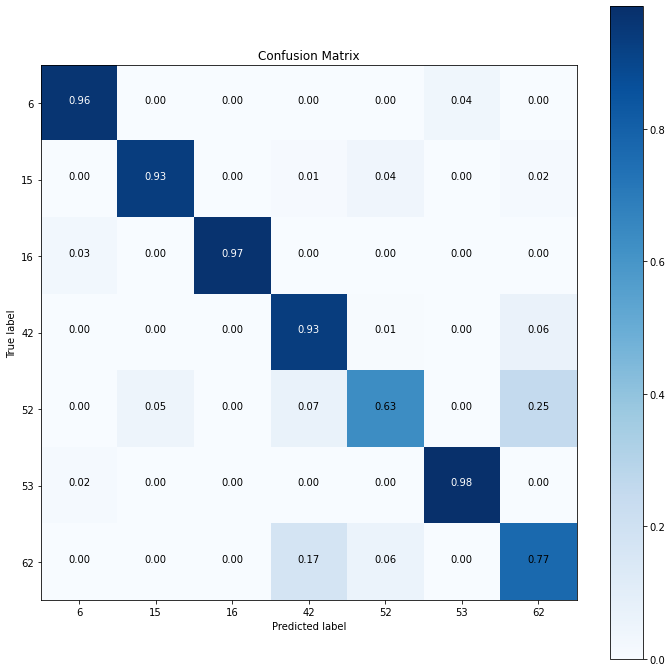


For number of classes: 8

X_train:  (6400, 105) , y_train:  (6400,) , X_test:  (1600, 105) , y_test:  (1600,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 353.37 seconds

Evaluation GP Model results:
Precision:  0.89
Recall:  0.89
F1-Score:  0.89
Accuracy:  0.89

Per Class Results:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       205
           1       0.93      0.93      0.93       193
           2       0.98      0.98      0.98       202
           3       0.82      0.84      0.83       197
           4       0.82      0.66      0.73       201
           5       0.97      1.00      0.99       195
           6       0.71      0.82      0.76       213
           7       0.95      0.97      0.96       194

    accuracy                           0.89      1600
   macro avg       0.90      0.89      0.89      1600
weighted avg       0.89      0.89      0.89      1600



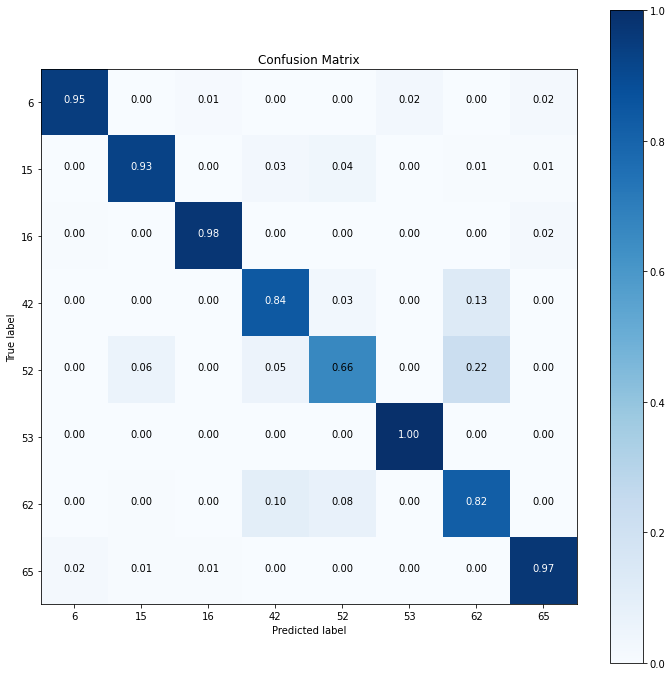


DL evaluation:

Model summary:
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 256)               27136     
_________________________________________________________________
dense_49 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_50 (Dense)             (None, 8)                 520       
_________________________________________________________________
activation_16 (Activation)   (None, 8)                 0         
Total params: 44,104
Trainable params: 44,104
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
  1/200 [..............................] - ETA: 0s - loss: 2.8171 - accuracy: 0.0312

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7], y=[1 0 3 ... 5 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


200/200 [==============================] - 0s 1ms/step - loss: 0.5618 - accuracy: 0.8059 - val_loss: 0.4945 - val_accuracy: 0.8450
Epoch 2/500
200/200 [==============================] - 0s 799us/step - loss: 0.4101 - accuracy: 0.8381 - val_loss: 0.5670 - val_accuracy: 0.8456
Epoch 3/500
200/200 [==============================] - 0s 766us/step - loss: 0.3736 - accuracy: 0.8525 - val_loss: 0.5203 - val_accuracy: 0.8456
Epoch 4/500
200/200 [==============================] - 0s 775us/step - loss: 0.3692 - accuracy: 0.8587 - val_loss: 0.4203 - val_accuracy: 0.8431
Epoch 5/500
200/200 [==============================] - 0s 792us/step - loss: 0.3896 - accuracy: 0.8567 - val_loss: 0.5250 - val_accuracy: 0.8425
Epoch 6/500
200/200 [==============================] - 0s 800us/step - loss: 0.3643 - accuracy: 0.8559 - val_loss: 0.3713 - val_accuracy: 0.8575
Epoch 7/500
200/200 [==============================] - 0s 791us/step - loss: 0.3513 - accuracy: 0.8627 - val_loss: 0.4689 - val_accuracy: 0.8550

200/200 [==============================] - 0s 769us/step - loss: 0.2788 - accuracy: 0.8861 - val_loss: 0.8091 - val_accuracy: 0.8769
Epoch 114/500
200/200 [==============================] - 0s 788us/step - loss: 0.2692 - accuracy: 0.8889 - val_loss: 0.7928 - val_accuracy: 0.8800
Epoch 115/500
200/200 [==============================] - 0s 796us/step - loss: 0.2688 - accuracy: 0.8922 - val_loss: 0.9120 - val_accuracy: 0.8794
Epoch 116/500
200/200 [==============================] - 0s 846us/step - loss: 0.2785 - accuracy: 0.8917 - val_loss: 0.7581 - val_accuracy: 0.8763
Epoch 117/500
200/200 [==============================] - 0s 817us/step - loss: 0.2802 - accuracy: 0.8870 - val_loss: 1.0849 - val_accuracy: 0.8650
Epoch 118/500
200/200 [==============================] - 0s 809us/step - loss: 0.2882 - accuracy: 0.8870 - val_loss: 0.8813 - val_accuracy: 0.8881
Epoch 119/500
200/200 [==============================] - 0s 775us/step - loss: 0.2700 - accuracy: 0.8902 - val_loss: 0.9512 - val_ac

Epoch 169/500
200/200 [==============================] - 0s 806us/step - loss: 0.2660 - accuracy: 0.8947 - val_loss: 1.1236 - val_accuracy: 0.8725
Epoch 170/500
200/200 [==============================] - 0s 781us/step - loss: 0.3514 - accuracy: 0.8839 - val_loss: 1.0147 - val_accuracy: 0.8712
Epoch 171/500
200/200 [==============================] - 0s 806us/step - loss: 0.3250 - accuracy: 0.8847 - val_loss: 1.2885 - val_accuracy: 0.8731
Epoch 172/500
200/200 [==============================] - 0s 795us/step - loss: 0.2694 - accuracy: 0.8916 - val_loss: 1.1024 - val_accuracy: 0.8819
Epoch 173/500
200/200 [==============================] - 0s 793us/step - loss: 0.2594 - accuracy: 0.8964 - val_loss: 0.9598 - val_accuracy: 0.8831
Epoch 174/500
200/200 [==============================] - 0s 801us/step - loss: 0.2616 - accuracy: 0.8939 - val_loss: 1.0244 - val_accuracy: 0.8662
Epoch 175/500
200/200 [==============================] - 0s 812us/step - loss: 0.2607 - accuracy: 0.8955 - val_loss: 1

Epoch 225/500
200/200 [==============================] - 0s 837us/step - loss: 0.2574 - accuracy: 0.8959 - val_loss: 1.1146 - val_accuracy: 0.8850
Epoch 226/500
200/200 [==============================] - 0s 859us/step - loss: 0.2662 - accuracy: 0.8933 - val_loss: 1.0774 - val_accuracy: 0.8850
Epoch 227/500
200/200 [==============================] - 0s 808us/step - loss: 0.2656 - accuracy: 0.8966 - val_loss: 1.0475 - val_accuracy: 0.8875
Epoch 228/500
200/200 [==============================] - 0s 807us/step - loss: 0.2553 - accuracy: 0.8952 - val_loss: 1.1392 - val_accuracy: 0.8806
Epoch 229/500
200/200 [==============================] - 0s 783us/step - loss: 0.2544 - accuracy: 0.8989 - val_loss: 1.0458 - val_accuracy: 0.8856
Epoch 230/500
200/200 [==============================] - 0s 813us/step - loss: 0.2521 - accuracy: 0.8978 - val_loss: 1.0782 - val_accuracy: 0.8763
Epoch 231/500
200/200 [==============================] - 0s 804us/step - loss: 0.2542 - accuracy: 0.8980 - val_loss: 1

Epoch 281/500
200/200 [==============================] - 0s 800us/step - loss: 0.2528 - accuracy: 0.8992 - val_loss: 1.0475 - val_accuracy: 0.8763
Epoch 282/500
200/200 [==============================] - 0s 801us/step - loss: 0.2537 - accuracy: 0.8967 - val_loss: 1.1594 - val_accuracy: 0.8825
Epoch 283/500
200/200 [==============================] - 0s 817us/step - loss: 0.2520 - accuracy: 0.8991 - val_loss: 1.1314 - val_accuracy: 0.8794
Epoch 284/500
200/200 [==============================] - 0s 790us/step - loss: 0.2517 - accuracy: 0.8980 - val_loss: 1.2801 - val_accuracy: 0.8794
Epoch 285/500
200/200 [==============================] - 0s 822us/step - loss: 0.2550 - accuracy: 0.8955 - val_loss: 1.4334 - val_accuracy: 0.8775
Epoch 286/500
200/200 [==============================] - 0s 818us/step - loss: 0.2520 - accuracy: 0.8967 - val_loss: 1.3133 - val_accuracy: 0.8838
Epoch 287/500
200/200 [==============================] - 0s 807us/step - loss: 0.2673 - accuracy: 0.8944 - val_loss: 1

Epoch 337/500
200/200 [==============================] - 0s 814us/step - loss: 0.2496 - accuracy: 0.9000 - val_loss: 1.2286 - val_accuracy: 0.8794
Epoch 338/500
200/200 [==============================] - 0s 802us/step - loss: 0.2502 - accuracy: 0.9013 - val_loss: 1.2399 - val_accuracy: 0.8900
Epoch 339/500
200/200 [==============================] - 0s 810us/step - loss: 0.2545 - accuracy: 0.9009 - val_loss: 1.2356 - val_accuracy: 0.8794
Epoch 340/500
200/200 [==============================] - 0s 819us/step - loss: 0.2478 - accuracy: 0.8991 - val_loss: 1.3006 - val_accuracy: 0.8850
Epoch 341/500
200/200 [==============================] - 0s 804us/step - loss: 0.2496 - accuracy: 0.9008 - val_loss: 1.3487 - val_accuracy: 0.8831
Epoch 342/500
200/200 [==============================] - 0s 787us/step - loss: 0.2651 - accuracy: 0.8970 - val_loss: 1.3163 - val_accuracy: 0.8788
Epoch 343/500
200/200 [==============================] - 0s 785us/step - loss: 0.2540 - accuracy: 0.8980 - val_loss: 1

Epoch 393/500
200/200 [==============================] - 0s 794us/step - loss: 0.2485 - accuracy: 0.8991 - val_loss: 1.1533 - val_accuracy: 0.8794
Epoch 394/500
200/200 [==============================] - 0s 793us/step - loss: 0.2496 - accuracy: 0.8983 - val_loss: 1.1213 - val_accuracy: 0.8694
Epoch 395/500
200/200 [==============================] - 0s 798us/step - loss: 0.2540 - accuracy: 0.8975 - val_loss: 1.4006 - val_accuracy: 0.8819
Epoch 396/500
200/200 [==============================] - 0s 770us/step - loss: 0.2549 - accuracy: 0.8975 - val_loss: 1.1696 - val_accuracy: 0.8919
Epoch 397/500
200/200 [==============================] - 0s 803us/step - loss: 0.2488 - accuracy: 0.9022 - val_loss: 1.3193 - val_accuracy: 0.8769
Epoch 398/500
200/200 [==============================] - 0s 826us/step - loss: 0.2502 - accuracy: 0.9014 - val_loss: 1.3128 - val_accuracy: 0.8875
Epoch 399/500
200/200 [==============================] - 0s 806us/step - loss: 0.2488 - accuracy: 0.8995 - val_loss: 1

Epoch 449/500
200/200 [==============================] - 0s 795us/step - loss: 0.2516 - accuracy: 0.9006 - val_loss: 1.2800 - val_accuracy: 0.8844
Epoch 450/500
200/200 [==============================] - 0s 832us/step - loss: 0.2461 - accuracy: 0.9059 - val_loss: 1.2973 - val_accuracy: 0.8888
Epoch 451/500
200/200 [==============================] - 0s 837us/step - loss: 0.2470 - accuracy: 0.9028 - val_loss: 1.3422 - val_accuracy: 0.8788
Epoch 452/500
200/200 [==============================] - 0s 856us/step - loss: 0.2479 - accuracy: 0.8984 - val_loss: 1.3820 - val_accuracy: 0.8863
Epoch 453/500
200/200 [==============================] - 0s 834us/step - loss: 0.2442 - accuracy: 0.9005 - val_loss: 1.2742 - val_accuracy: 0.8831
Epoch 454/500
200/200 [==============================] - 0s 779us/step - loss: 0.2460 - accuracy: 0.9031 - val_loss: 1.0506 - val_accuracy: 0.8863
Epoch 455/500
200/200 [==============================] - 0s 793us/step - loss: 0.2443 - accuracy: 0.9036 - val_loss: 1

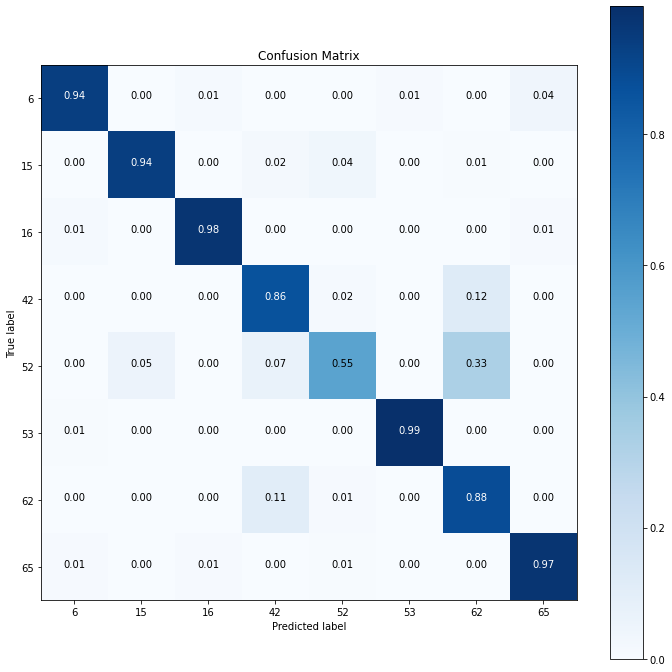


For number of classes: 9

X_train:  (7200, 105) , y_train:  (7200,) , X_test:  (1800, 105) , y_test:  (1800,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 485.15 seconds

Evaluation GP Model results:
Precision:  0.86
Recall:  0.86
F1-Score:  0.85
Accuracy:  0.86

Per Class Results:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       213
           1       0.89      0.91      0.90       211
           2       0.98      0.98      0.98       199
           3       0.81      0.85      0.83       184
           4       0.83      0.56      0.67       196
           5       0.97      0.97      0.97       208
           6       0.60      0.80      0.69       189
           7       0.96      0.96      0.96       200
           8       0.76      0.69      0.73       200

    accuracy                           0.86      1800
   macro avg       0.86      0.85      0.85      1800
weighted avg       0.86      0.86      0.85      1800



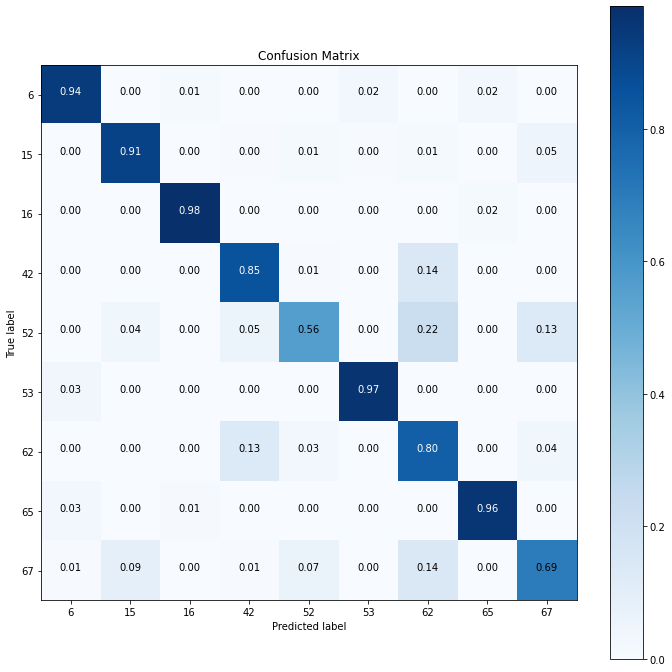


DL evaluation:

Model summary:
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 256)               27136     
_________________________________________________________________
dense_52 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_53 (Dense)             (None, 9)                 585       
_________________________________________________________________
activation_17 (Activation)   (None, 9)                 0         
Total params: 44,169
Trainable params: 44,169
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
  1/225 [..............................] - ETA: 0s - loss: 2.4217 - accuracy: 0.0312

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7 8], y=[0 3 1 ... 2 2 6] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


225/225 [==============================] - 0s 1ms/step - loss: 0.7437 - accuracy: 0.7478 - val_loss: 0.5823 - val_accuracy: 0.7878
Epoch 2/500
225/225 [==============================] - 0s 814us/step - loss: 0.5562 - accuracy: 0.8007 - val_loss: 0.6316 - val_accuracy: 0.7933
Epoch 3/500
225/225 [==============================] - 0s 793us/step - loss: 0.5072 - accuracy: 0.8100 - val_loss: 0.5431 - val_accuracy: 0.7956
Epoch 4/500
225/225 [==============================] - 0s 806us/step - loss: 0.4982 - accuracy: 0.8107 - val_loss: 0.6645 - val_accuracy: 0.8039
Epoch 5/500
225/225 [==============================] - 0s 806us/step - loss: 0.4761 - accuracy: 0.8142 - val_loss: 0.5827 - val_accuracy: 0.8050
Epoch 6/500
225/225 [==============================] - 0s 798us/step - loss: 0.4615 - accuracy: 0.8179 - val_loss: 0.5125 - val_accuracy: 0.8133
Epoch 7/500
225/225 [==============================] - 0s 840us/step - loss: 0.4694 - accuracy: 0.8214 - val_loss: 0.4920 - val_accuracy: 0.8111

225/225 [==============================] - 0s 890us/step - loss: 0.3805 - accuracy: 0.8514 - val_loss: 0.5608 - val_accuracy: 0.8383
Epoch 114/500
225/225 [==============================] - 0s 843us/step - loss: 0.3850 - accuracy: 0.8464 - val_loss: 0.5083 - val_accuracy: 0.8439
Epoch 115/500
225/225 [==============================] - 0s 835us/step - loss: 0.3831 - accuracy: 0.8475 - val_loss: 0.5289 - val_accuracy: 0.8311
Epoch 116/500
225/225 [==============================] - 0s 812us/step - loss: 0.3876 - accuracy: 0.8472 - val_loss: 0.5252 - val_accuracy: 0.8372
Epoch 117/500
225/225 [==============================] - 0s 839us/step - loss: 0.3794 - accuracy: 0.8506 - val_loss: 0.5083 - val_accuracy: 0.8450
Epoch 118/500
225/225 [==============================] - 0s 831us/step - loss: 0.3770 - accuracy: 0.8486 - val_loss: 0.5373 - val_accuracy: 0.8456
Epoch 119/500
225/225 [==============================] - 0s 832us/step - loss: 0.3834 - accuracy: 0.8487 - val_loss: 0.4987 - val_ac

Epoch 169/500
225/225 [==============================] - 0s 842us/step - loss: 0.3745 - accuracy: 0.8532 - val_loss: 0.5300 - val_accuracy: 0.8461
Epoch 170/500
225/225 [==============================] - 0s 840us/step - loss: 0.3779 - accuracy: 0.8510 - val_loss: 0.5177 - val_accuracy: 0.8394
Epoch 171/500
225/225 [==============================] - 0s 870us/step - loss: 0.3746 - accuracy: 0.8515 - val_loss: 0.5374 - val_accuracy: 0.8422
Epoch 172/500
225/225 [==============================] - 0s 830us/step - loss: 0.3733 - accuracy: 0.8539 - val_loss: 0.6010 - val_accuracy: 0.8406
Epoch 173/500
225/225 [==============================] - 0s 848us/step - loss: 0.3716 - accuracy: 0.8521 - val_loss: 0.5803 - val_accuracy: 0.8356
Epoch 174/500
225/225 [==============================] - 0s 822us/step - loss: 0.3714 - accuracy: 0.8565 - val_loss: 0.6407 - val_accuracy: 0.8367
Epoch 175/500
225/225 [==============================] - 0s 843us/step - loss: 0.3728 - accuracy: 0.8553 - val_loss: 0

Epoch 225/500
225/225 [==============================] - 0s 830us/step - loss: 0.3655 - accuracy: 0.8586 - val_loss: 0.5913 - val_accuracy: 0.8411
Epoch 226/500
225/225 [==============================] - 0s 842us/step - loss: 0.3667 - accuracy: 0.8582 - val_loss: 0.5758 - val_accuracy: 0.8406
Epoch 227/500
225/225 [==============================] - 0s 821us/step - loss: 0.3660 - accuracy: 0.8572 - val_loss: 0.6078 - val_accuracy: 0.8450
Epoch 228/500
225/225 [==============================] - 0s 829us/step - loss: 0.3660 - accuracy: 0.8558 - val_loss: 0.5727 - val_accuracy: 0.8478
Epoch 229/500
225/225 [==============================] - 0s 839us/step - loss: 0.3686 - accuracy: 0.8535 - val_loss: 0.6894 - val_accuracy: 0.8422
Epoch 230/500
225/225 [==============================] - 0s 847us/step - loss: 0.4571 - accuracy: 0.8482 - val_loss: 0.6222 - val_accuracy: 0.8389
Epoch 231/500
225/225 [==============================] - 0s 846us/step - loss: 0.3815 - accuracy: 0.8507 - val_loss: 0

Epoch 281/500
225/225 [==============================] - 0s 847us/step - loss: 0.3684 - accuracy: 0.8586 - val_loss: 0.5642 - val_accuracy: 0.8478
Epoch 282/500
225/225 [==============================] - 0s 855us/step - loss: 0.3660 - accuracy: 0.8564 - val_loss: 0.5732 - val_accuracy: 0.8439
Epoch 283/500
225/225 [==============================] - 0s 871us/step - loss: 0.3704 - accuracy: 0.8582 - val_loss: 0.5812 - val_accuracy: 0.8428
Epoch 284/500
225/225 [==============================] - 0s 844us/step - loss: 0.3724 - accuracy: 0.8575 - val_loss: 0.6269 - val_accuracy: 0.8478
Epoch 285/500
225/225 [==============================] - 0s 836us/step - loss: 0.3715 - accuracy: 0.8567 - val_loss: 0.5670 - val_accuracy: 0.8367
Epoch 286/500
225/225 [==============================] - 0s 831us/step - loss: 0.3658 - accuracy: 0.8568 - val_loss: 0.5861 - val_accuracy: 0.8439
Epoch 287/500
225/225 [==============================] - 0s 829us/step - loss: 0.3613 - accuracy: 0.8596 - val_loss: 0

Epoch 337/500
225/225 [==============================] - 0s 844us/step - loss: 0.3672 - accuracy: 0.8601 - val_loss: 0.5614 - val_accuracy: 0.8450
Epoch 338/500
225/225 [==============================] - 0s 865us/step - loss: 0.3559 - accuracy: 0.8614 - val_loss: 0.5260 - val_accuracy: 0.8478
Epoch 339/500
225/225 [==============================] - 0s 845us/step - loss: 0.3586 - accuracy: 0.8589 - val_loss: 0.5125 - val_accuracy: 0.8467
Epoch 340/500
225/225 [==============================] - 0s 849us/step - loss: 0.3601 - accuracy: 0.8572 - val_loss: 0.5146 - val_accuracy: 0.8406
Epoch 341/500
225/225 [==============================] - 0s 828us/step - loss: 0.3582 - accuracy: 0.8582 - val_loss: 0.6281 - val_accuracy: 0.8456
Epoch 342/500
225/225 [==============================] - 0s 862us/step - loss: 0.3568 - accuracy: 0.8600 - val_loss: 0.5784 - val_accuracy: 0.8472
Epoch 343/500
225/225 [==============================] - 0s 823us/step - loss: 0.3605 - accuracy: 0.8596 - val_loss: 0

Epoch 393/500
225/225 [==============================] - 0s 844us/step - loss: 0.3584 - accuracy: 0.8571 - val_loss: 0.6165 - val_accuracy: 0.8511
Epoch 394/500
225/225 [==============================] - 0s 829us/step - loss: 0.3564 - accuracy: 0.8617 - val_loss: 0.5417 - val_accuracy: 0.8428
Epoch 395/500
225/225 [==============================] - 0s 829us/step - loss: 0.3574 - accuracy: 0.8578 - val_loss: 0.6498 - val_accuracy: 0.8511
Epoch 396/500
225/225 [==============================] - 0s 837us/step - loss: 0.3551 - accuracy: 0.8615 - val_loss: 0.6014 - val_accuracy: 0.8511
Epoch 397/500
225/225 [==============================] - 0s 821us/step - loss: 0.3565 - accuracy: 0.8629 - val_loss: 0.5957 - val_accuracy: 0.8394
Epoch 398/500
225/225 [==============================] - 0s 867us/step - loss: 0.3583 - accuracy: 0.8594 - val_loss: 0.5951 - val_accuracy: 0.8433
Epoch 399/500
225/225 [==============================] - 0s 810us/step - loss: 0.3552 - accuracy: 0.8583 - val_loss: 0

Epoch 449/500
225/225 [==============================] - 0s 848us/step - loss: 0.3548 - accuracy: 0.8614 - val_loss: 0.5704 - val_accuracy: 0.8550
Epoch 450/500
225/225 [==============================] - 0s 816us/step - loss: 0.3557 - accuracy: 0.8594 - val_loss: 0.5794 - val_accuracy: 0.8411
Epoch 451/500
225/225 [==============================] - 0s 835us/step - loss: 0.3539 - accuracy: 0.8585 - val_loss: 0.5940 - val_accuracy: 0.8450
Epoch 452/500
225/225 [==============================] - 0s 836us/step - loss: 0.3546 - accuracy: 0.8594 - val_loss: 0.6408 - val_accuracy: 0.8461
Epoch 453/500
225/225 [==============================] - 0s 821us/step - loss: 0.3508 - accuracy: 0.8631 - val_loss: 0.6609 - val_accuracy: 0.8506
Epoch 454/500
225/225 [==============================] - 0s 874us/step - loss: 0.3593 - accuracy: 0.8586 - val_loss: 0.5691 - val_accuracy: 0.8422
Epoch 455/500
225/225 [==============================] - 0s 860us/step - loss: 0.3649 - accuracy: 0.8587 - val_loss: 0

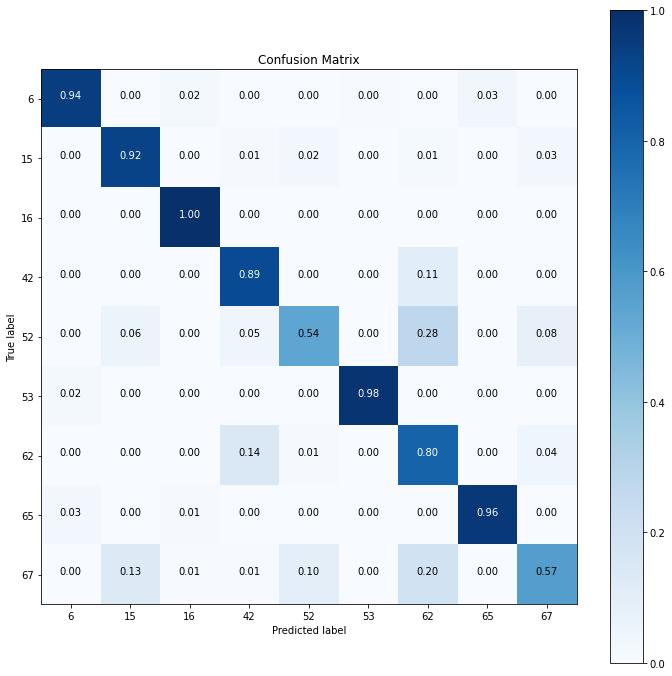


For number of classes: 10

X_train:  (8000, 105) , y_train:  (8000,) , X_test:  (2000, 105) , y_test:  (2000,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 637.05 seconds

Evaluation GP Model results:
Precision:  0.85
Recall:  0.85
F1-Score:  0.85
Accuracy:  0.85

Per Class Results:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       170
           1       0.90      0.85      0.87       211
           2       0.96      1.00      0.98       206
           3       0.80      0.83      0.82       185
           4       0.73      0.56      0.64       201
           5       0.98      0.98      0.98       192
           6       0.63      0.76      0.69       206
           7       0.97      0.96      0.96       212
           8       0.70      0.72      0.71       208
           9       0.92      0.94      0.93       209

    accuracy                           0.85      2000
   macro avg       0.86      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



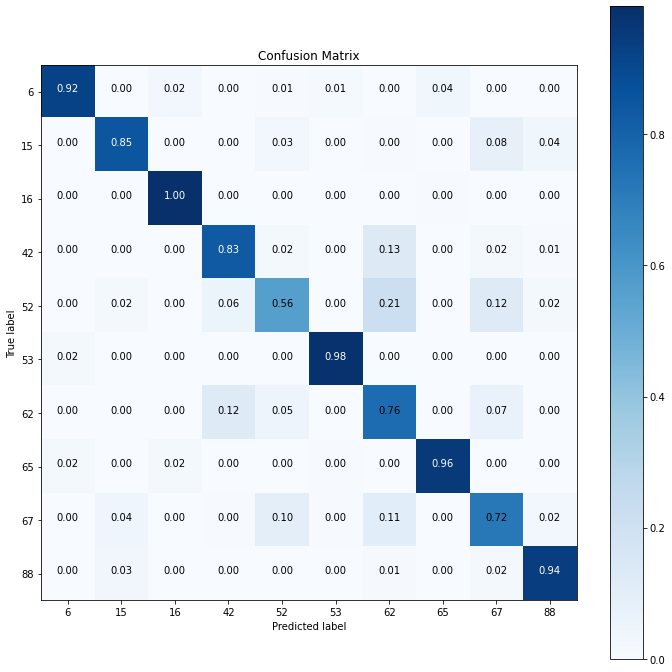


DL evaluation:

Model summary:
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 256)               27136     
_________________________________________________________________
dense_55 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_56 (Dense)             (None, 10)                650       
_________________________________________________________________
activation_18 (Activation)   (None, 10)                0         
Total params: 44,234
Trainable params: 44,234
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
  1/250 [..............................] - ETA: 0s - loss: 2.8104 - accuracy: 0.0938

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7 8 9], y=[4 8 6 ... 1 9 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


250/250 [==============================] - 0s 1ms/step - loss: 0.7905 - accuracy: 0.7374 - val_loss: 0.5665 - val_accuracy: 0.7915
Epoch 2/500
250/250 [==============================] - 0s 837us/step - loss: 0.5702 - accuracy: 0.7959 - val_loss: 0.5778 - val_accuracy: 0.7715
Epoch 3/500
250/250 [==============================] - 0s 853us/step - loss: 0.5345 - accuracy: 0.8049 - val_loss: 0.8103 - val_accuracy: 0.7965
Epoch 4/500
250/250 [==============================] - 0s 867us/step - loss: 0.5448 - accuracy: 0.8091 - val_loss: 0.5271 - val_accuracy: 0.8025
Epoch 5/500
250/250 [==============================] - 0s 842us/step - loss: 0.4962 - accuracy: 0.8170 - val_loss: 0.5143 - val_accuracy: 0.8065
Epoch 6/500
250/250 [==============================] - 0s 860us/step - loss: 0.4892 - accuracy: 0.8179 - val_loss: 0.5113 - val_accuracy: 0.8035
Epoch 7/500
250/250 [==============================] - 0s 840us/step - loss: 0.4789 - accuracy: 0.8180 - val_loss: 0.4908 - val_accuracy: 0.8055

250/250 [==============================] - 0s 889us/step - loss: 0.4050 - accuracy: 0.8471 - val_loss: 0.4606 - val_accuracy: 0.8160
Epoch 114/500
250/250 [==============================] - 0s 816us/step - loss: 0.4002 - accuracy: 0.8497 - val_loss: 0.4633 - val_accuracy: 0.8225
Epoch 115/500
250/250 [==============================] - 0s 846us/step - loss: 0.3972 - accuracy: 0.8494 - val_loss: 0.4467 - val_accuracy: 0.8235
Epoch 116/500
250/250 [==============================] - 0s 833us/step - loss: 0.4011 - accuracy: 0.8476 - val_loss: 0.4567 - val_accuracy: 0.8210
Epoch 117/500
250/250 [==============================] - 0s 853us/step - loss: 0.4032 - accuracy: 0.8455 - val_loss: 0.4604 - val_accuracy: 0.8200
Epoch 118/500
250/250 [==============================] - 0s 812us/step - loss: 0.4032 - accuracy: 0.8495 - val_loss: 0.4692 - val_accuracy: 0.8145
Epoch 119/500
250/250 [==============================] - 0s 806us/step - loss: 0.4023 - accuracy: 0.8497 - val_loss: 0.4596 - val_ac

Epoch 169/500
250/250 [==============================] - 0s 854us/step - loss: 0.3909 - accuracy: 0.8518 - val_loss: 0.4703 - val_accuracy: 0.8220
Epoch 170/500
250/250 [==============================] - 0s 825us/step - loss: 0.3930 - accuracy: 0.8535 - val_loss: 0.4514 - val_accuracy: 0.8300
Epoch 171/500
250/250 [==============================] - 0s 927us/step - loss: 0.3927 - accuracy: 0.8510 - val_loss: 0.4518 - val_accuracy: 0.8335
Epoch 172/500
250/250 [==============================] - 0s 868us/step - loss: 0.3933 - accuracy: 0.8510 - val_loss: 0.4508 - val_accuracy: 0.8250
Epoch 173/500
250/250 [==============================] - 0s 829us/step - loss: 0.4985 - accuracy: 0.8430 - val_loss: 0.4513 - val_accuracy: 0.8235
Epoch 174/500
250/250 [==============================] - 0s 814us/step - loss: 0.4147 - accuracy: 0.8461 - val_loss: 0.4699 - val_accuracy: 0.8225
Epoch 175/500
250/250 [==============================] - 0s 866us/step - loss: 0.4016 - accuracy: 0.8509 - val_loss: 0

Epoch 225/500
250/250 [==============================] - 0s 840us/step - loss: 0.3847 - accuracy: 0.8553 - val_loss: 0.4591 - val_accuracy: 0.8155
Epoch 226/500
250/250 [==============================] - 0s 844us/step - loss: 0.3941 - accuracy: 0.8508 - val_loss: 0.4599 - val_accuracy: 0.8260
Epoch 227/500
250/250 [==============================] - 0s 821us/step - loss: 0.3907 - accuracy: 0.8556 - val_loss: 0.4405 - val_accuracy: 0.8300
Epoch 228/500
250/250 [==============================] - 0s 806us/step - loss: 0.4616 - accuracy: 0.8494 - val_loss: 1.0008 - val_accuracy: 0.8185
Epoch 229/500
250/250 [==============================] - 0s 888us/step - loss: 0.4177 - accuracy: 0.8486 - val_loss: 0.4575 - val_accuracy: 0.8260
Epoch 230/500
250/250 [==============================] - 0s 858us/step - loss: 0.4021 - accuracy: 0.8512 - val_loss: 0.4502 - val_accuracy: 0.8315
Epoch 231/500
250/250 [==============================] - 0s 848us/step - loss: 0.4011 - accuracy: 0.8554 - val_loss: 0

Epoch 281/500
250/250 [==============================] - 0s 823us/step - loss: 0.3846 - accuracy: 0.8522 - val_loss: 0.4580 - val_accuracy: 0.8325
Epoch 282/500
250/250 [==============================] - 0s 838us/step - loss: 0.4008 - accuracy: 0.8522 - val_loss: 0.4686 - val_accuracy: 0.8320
Epoch 283/500
250/250 [==============================] - 0s 827us/step - loss: 0.4015 - accuracy: 0.8504 - val_loss: 0.4879 - val_accuracy: 0.8280
Epoch 284/500
250/250 [==============================] - 0s 817us/step - loss: 0.4159 - accuracy: 0.8525 - val_loss: 0.4603 - val_accuracy: 0.8265
Epoch 285/500
250/250 [==============================] - 0s 794us/step - loss: 0.3908 - accuracy: 0.8543 - val_loss: 0.4523 - val_accuracy: 0.8355
Epoch 286/500
250/250 [==============================] - 0s 791us/step - loss: 0.3842 - accuracy: 0.8554 - val_loss: 0.4385 - val_accuracy: 0.8385
Epoch 287/500
250/250 [==============================] - 0s 799us/step - loss: 0.3869 - accuracy: 0.8551 - val_loss: 0

Epoch 337/500
250/250 [==============================] - 0s 825us/step - loss: 0.3847 - accuracy: 0.8558 - val_loss: 0.4677 - val_accuracy: 0.8255
Epoch 338/500
250/250 [==============================] - 0s 865us/step - loss: 0.3832 - accuracy: 0.8576 - val_loss: 0.4453 - val_accuracy: 0.8305
Epoch 339/500
250/250 [==============================] - 0s 828us/step - loss: 0.3842 - accuracy: 0.8558 - val_loss: 0.4556 - val_accuracy: 0.8245
Epoch 340/500
250/250 [==============================] - 0s 810us/step - loss: 0.3808 - accuracy: 0.8584 - val_loss: 0.4553 - val_accuracy: 0.8290
Epoch 341/500
250/250 [==============================] - 0s 809us/step - loss: 0.3832 - accuracy: 0.8595 - val_loss: 0.4485 - val_accuracy: 0.8250
Epoch 342/500
250/250 [==============================] - 0s 839us/step - loss: 0.3869 - accuracy: 0.8546 - val_loss: 0.5000 - val_accuracy: 0.8290
Epoch 343/500
250/250 [==============================] - 0s 831us/step - loss: 0.3970 - accuracy: 0.8509 - val_loss: 0

Epoch 393/500
250/250 [==============================] - 0s 887us/step - loss: 0.3919 - accuracy: 0.8558 - val_loss: 0.5119 - val_accuracy: 0.8370
Epoch 394/500
250/250 [==============================] - 0s 868us/step - loss: 0.4105 - accuracy: 0.8506 - val_loss: 0.4783 - val_accuracy: 0.8390
Epoch 395/500
250/250 [==============================] - 0s 870us/step - loss: 0.3844 - accuracy: 0.8549 - val_loss: 0.4711 - val_accuracy: 0.8325
Epoch 396/500
250/250 [==============================] - 0s 873us/step - loss: 0.3800 - accuracy: 0.8577 - val_loss: 0.4762 - val_accuracy: 0.8280
Epoch 397/500
250/250 [==============================] - 0s 879us/step - loss: 0.3773 - accuracy: 0.8572 - val_loss: 0.4707 - val_accuracy: 0.8360
Epoch 398/500
250/250 [==============================] - 0s 855us/step - loss: 0.3804 - accuracy: 0.8575 - val_loss: 0.4813 - val_accuracy: 0.8375
Epoch 399/500
250/250 [==============================] - 0s 824us/step - loss: 0.3763 - accuracy: 0.8591 - val_loss: 0

Epoch 449/500
250/250 [==============================] - 0s 893us/step - loss: 0.4113 - accuracy: 0.8543 - val_loss: 0.4928 - val_accuracy: 0.8340
Epoch 450/500
250/250 [==============================] - 0s 882us/step - loss: 0.3879 - accuracy: 0.8566 - val_loss: 0.4694 - val_accuracy: 0.8345
Epoch 451/500
250/250 [==============================] - 0s 835us/step - loss: 0.3833 - accuracy: 0.8576 - val_loss: 0.5035 - val_accuracy: 0.8125
Epoch 452/500
250/250 [==============================] - 0s 834us/step - loss: 0.3738 - accuracy: 0.8576 - val_loss: 0.4765 - val_accuracy: 0.8410
Epoch 453/500
250/250 [==============================] - 0s 847us/step - loss: 0.3737 - accuracy: 0.8595 - val_loss: 0.4893 - val_accuracy: 0.8205
Epoch 454/500
250/250 [==============================] - 0s 883us/step - loss: 0.3783 - accuracy: 0.8574 - val_loss: 0.4849 - val_accuracy: 0.8310
Epoch 455/500
250/250 [==============================] - 0s 916us/step - loss: 0.3924 - accuracy: 0.8585 - val_loss: 0

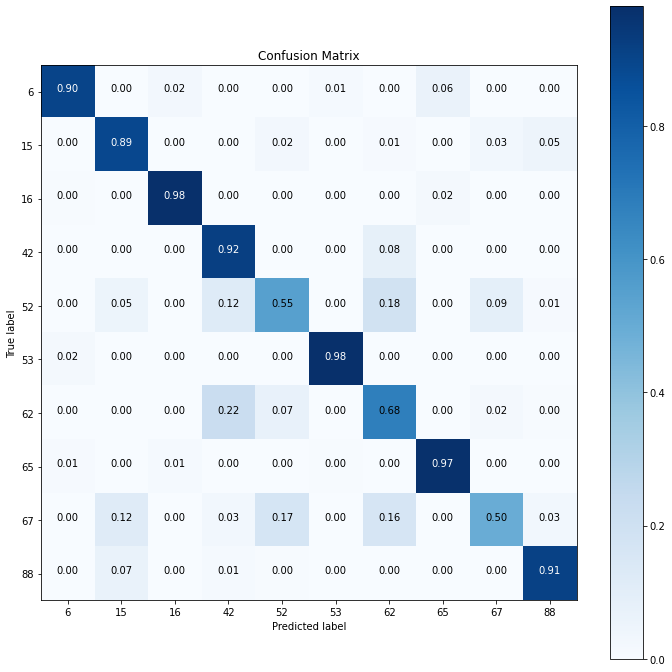


For number of classes: 11

X_train:  (8800, 105) , y_train:  (8800,) , X_test:  (2200, 105) , y_test:  (2200,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 855.65 seconds

Evaluation GP Model results:
Precision:  0.86
Recall:  0.85
F1-Score:  0.85
Accuracy:  0.85

Per Class Results:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       191
           1       0.85      0.87      0.86       190
           2       0.97      0.99      0.98       189
           3       0.86      0.81      0.83       198
           4       0.80      0.54      0.64       202
           5       0.98      0.99      0.98       214
           6       0.65      0.77      0.70       212
           7       0.96      0.94      0.95       211
           8       0.73      0.72      0.73       186
           9       0.90      0.91      0.90       197
          10       0.78      0.89      0.83       210

    accuracy                           0.85      2200
   macro avg       0.86      0.85      0.85      2200
weighted avg       0.86      0.85      0.85      2200



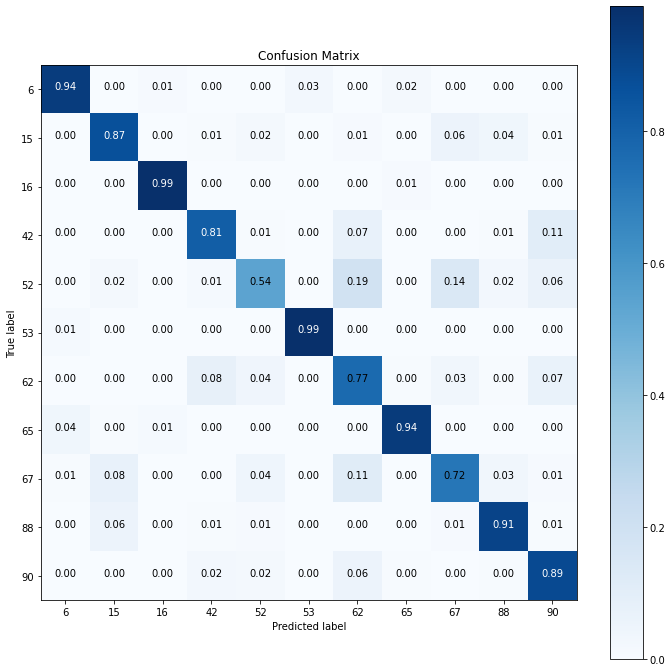


DL evaluation:

Model summary:
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 256)               27136     
_________________________________________________________________
dense_58 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_59 (Dense)             (None, 11)                715       
_________________________________________________________________
activation_19 (Activation)   (None, 11)                0         
Total params: 44,299
Trainable params: 44,299
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
  1/275 [..............................] - ETA: 0s - loss: 3.2128 - accuracy: 0.0625

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10], y=[8 5 9 ... 1 6 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


275/275 [==============================] - 0s 1ms/step - loss: 0.8407 - accuracy: 0.7298 - val_loss: 0.7636 - val_accuracy: 0.7686
Epoch 2/500
275/275 [==============================] - 0s 787us/step - loss: 0.6106 - accuracy: 0.7887 - val_loss: 0.5620 - val_accuracy: 0.7945
Epoch 3/500
275/275 [==============================] - 0s 781us/step - loss: 0.5849 - accuracy: 0.7951 - val_loss: 0.5946 - val_accuracy: 0.7964
Epoch 4/500
275/275 [==============================] - 0s 803us/step - loss: 0.5587 - accuracy: 0.7998 - val_loss: 0.6087 - val_accuracy: 0.7968
Epoch 5/500
275/275 [==============================] - 0s 809us/step - loss: 0.5582 - accuracy: 0.7993 - val_loss: 0.5704 - val_accuracy: 0.8082
Epoch 6/500
275/275 [==============================] - 0s 794us/step - loss: 0.5511 - accuracy: 0.8027 - val_loss: 0.5852 - val_accuracy: 0.7973
Epoch 7/500
275/275 [==============================] - 0s 923us/step - loss: 0.5428 - accuracy: 0.8083 - val_loss: 0.5781 - val_accuracy: 0.8077

275/275 [==============================] - 0s 871us/step - loss: 0.4630 - accuracy: 0.8399 - val_loss: 0.6819 - val_accuracy: 0.8173
Epoch 114/500
275/275 [==============================] - 0s 878us/step - loss: 0.4679 - accuracy: 0.8325 - val_loss: 0.5016 - val_accuracy: 0.8332
Epoch 115/500
275/275 [==============================] - 0s 855us/step - loss: 0.4567 - accuracy: 0.8320 - val_loss: 0.5265 - val_accuracy: 0.8273
Epoch 116/500
275/275 [==============================] - 0s 818us/step - loss: 0.4516 - accuracy: 0.8385 - val_loss: 0.5274 - val_accuracy: 0.8241
Epoch 117/500
275/275 [==============================] - 0s 829us/step - loss: 0.4684 - accuracy: 0.8344 - val_loss: 0.5244 - val_accuracy: 0.8205
Epoch 118/500
275/275 [==============================] - 0s 831us/step - loss: 0.4675 - accuracy: 0.8349 - val_loss: 0.5447 - val_accuracy: 0.8182
Epoch 119/500
275/275 [==============================] - 0s 821us/step - loss: 0.4654 - accuracy: 0.8325 - val_loss: 0.5277 - val_ac

Epoch 169/500
275/275 [==============================] - 0s 784us/step - loss: 0.4483 - accuracy: 0.8397 - val_loss: 0.8404 - val_accuracy: 0.8223
Epoch 170/500
275/275 [==============================] - 0s 813us/step - loss: 0.4447 - accuracy: 0.8402 - val_loss: 0.9289 - val_accuracy: 0.8191
Epoch 171/500
275/275 [==============================] - 0s 795us/step - loss: 0.4830 - accuracy: 0.8381 - val_loss: 0.6116 - val_accuracy: 0.8318
Epoch 172/500
275/275 [==============================] - 0s 795us/step - loss: 0.4689 - accuracy: 0.8384 - val_loss: 0.5505 - val_accuracy: 0.8164
Epoch 173/500
275/275 [==============================] - 0s 784us/step - loss: 0.4493 - accuracy: 0.8406 - val_loss: 0.5635 - val_accuracy: 0.8300
Epoch 174/500
275/275 [==============================] - 0s 844us/step - loss: 0.4642 - accuracy: 0.8388 - val_loss: 0.5120 - val_accuracy: 0.8264
Epoch 175/500
275/275 [==============================] - 0s 819us/step - loss: 0.4869 - accuracy: 0.8394 - val_loss: 0

Epoch 225/500
275/275 [==============================] - 0s 818us/step - loss: 0.4396 - accuracy: 0.8456 - val_loss: 0.8844 - val_accuracy: 0.8359
Epoch 226/500
275/275 [==============================] - 0s 795us/step - loss: 0.4392 - accuracy: 0.8419 - val_loss: 0.9134 - val_accuracy: 0.8295
Epoch 227/500
275/275 [==============================] - 0s 832us/step - loss: 0.4377 - accuracy: 0.8439 - val_loss: 1.0263 - val_accuracy: 0.8232
Epoch 228/500
275/275 [==============================] - 0s 858us/step - loss: 0.4472 - accuracy: 0.8424 - val_loss: 0.7552 - val_accuracy: 0.8241
Epoch 229/500
275/275 [==============================] - 0s 878us/step - loss: 0.4416 - accuracy: 0.8432 - val_loss: 0.7877 - val_accuracy: 0.8359
Epoch 230/500
275/275 [==============================] - 0s 869us/step - loss: 0.4399 - accuracy: 0.8418 - val_loss: 0.8773 - val_accuracy: 0.8268
Epoch 231/500
275/275 [==============================] - 0s 868us/step - loss: 0.4483 - accuracy: 0.8413 - val_loss: 0

Epoch 281/500
275/275 [==============================] - 0s 803us/step - loss: 0.4596 - accuracy: 0.8394 - val_loss: 0.7978 - val_accuracy: 0.8286
Epoch 282/500
275/275 [==============================] - 0s 821us/step - loss: 0.5107 - accuracy: 0.8390 - val_loss: 0.5766 - val_accuracy: 0.8300
Epoch 283/500
275/275 [==============================] - 0s 813us/step - loss: 0.4395 - accuracy: 0.8460 - val_loss: 0.5947 - val_accuracy: 0.8159
Epoch 284/500
275/275 [==============================] - 0s 786us/step - loss: 0.4356 - accuracy: 0.8457 - val_loss: 0.5943 - val_accuracy: 0.8309
Epoch 285/500
275/275 [==============================] - 0s 816us/step - loss: 0.4346 - accuracy: 0.8424 - val_loss: 0.6621 - val_accuracy: 0.8305
Epoch 286/500
275/275 [==============================] - 0s 810us/step - loss: 0.4354 - accuracy: 0.8455 - val_loss: 0.7084 - val_accuracy: 0.8295
Epoch 287/500
275/275 [==============================] - 0s 792us/step - loss: 0.4369 - accuracy: 0.8449 - val_loss: 0

Epoch 337/500
275/275 [==============================] - 0s 816us/step - loss: 0.4342 - accuracy: 0.8459 - val_loss: 0.8305 - val_accuracy: 0.8327
Epoch 338/500
275/275 [==============================] - 0s 794us/step - loss: 0.4350 - accuracy: 0.8438 - val_loss: 0.7022 - val_accuracy: 0.8341
Epoch 339/500
275/275 [==============================] - 0s 745us/step - loss: 0.4300 - accuracy: 0.8458 - val_loss: 0.8387 - val_accuracy: 0.8309
Epoch 340/500
275/275 [==============================] - 0s 802us/step - loss: 0.4334 - accuracy: 0.8444 - val_loss: 0.8718 - val_accuracy: 0.8332
Epoch 341/500
275/275 [==============================] - 0s 766us/step - loss: 0.4327 - accuracy: 0.8451 - val_loss: 1.0161 - val_accuracy: 0.8305
Epoch 342/500
275/275 [==============================] - 0s 805us/step - loss: 0.4345 - accuracy: 0.8457 - val_loss: 0.9716 - val_accuracy: 0.8273
Epoch 343/500
275/275 [==============================] - 0s 787us/step - loss: 0.4306 - accuracy: 0.8461 - val_loss: 1

Epoch 393/500
275/275 [==============================] - 0s 798us/step - loss: 0.4274 - accuracy: 0.8499 - val_loss: 1.0020 - val_accuracy: 0.8318
Epoch 394/500
275/275 [==============================] - 0s 778us/step - loss: 0.4380 - accuracy: 0.8482 - val_loss: 0.8060 - val_accuracy: 0.8214
Epoch 395/500
275/275 [==============================] - 0s 770us/step - loss: 0.4496 - accuracy: 0.8459 - val_loss: 0.8946 - val_accuracy: 0.8373
Epoch 396/500
275/275 [==============================] - 0s 790us/step - loss: 0.4405 - accuracy: 0.8444 - val_loss: 0.9066 - val_accuracy: 0.8250
Epoch 397/500
275/275 [==============================] - 0s 777us/step - loss: 0.4364 - accuracy: 0.8451 - val_loss: 0.9154 - val_accuracy: 0.8309
Epoch 398/500
275/275 [==============================] - 0s 803us/step - loss: 0.4332 - accuracy: 0.8469 - val_loss: 1.0271 - val_accuracy: 0.8191
Epoch 399/500
275/275 [==============================] - 0s 832us/step - loss: 0.4340 - accuracy: 0.8475 - val_loss: 1

Epoch 449/500
275/275 [==============================] - 0s 807us/step - loss: 0.4253 - accuracy: 0.8509 - val_loss: 1.1660 - val_accuracy: 0.8327
Epoch 450/500
275/275 [==============================] - 0s 791us/step - loss: 0.4309 - accuracy: 0.8495 - val_loss: 0.6114 - val_accuracy: 0.8409
Epoch 451/500
275/275 [==============================] - 0s 771us/step - loss: 0.4283 - accuracy: 0.8483 - val_loss: 0.6212 - val_accuracy: 0.8286
Epoch 452/500
275/275 [==============================] - 0s 837us/step - loss: 0.4538 - accuracy: 0.8455 - val_loss: 0.9109 - val_accuracy: 0.8259
Epoch 453/500
275/275 [==============================] - 0s 788us/step - loss: 0.4374 - accuracy: 0.8490 - val_loss: 0.8600 - val_accuracy: 0.8341
Epoch 454/500
275/275 [==============================] - 0s 830us/step - loss: 0.4438 - accuracy: 0.8445 - val_loss: 0.6154 - val_accuracy: 0.8373
Epoch 455/500
275/275 [==============================] - 0s 783us/step - loss: 0.4349 - accuracy: 0.8461 - val_loss: 0

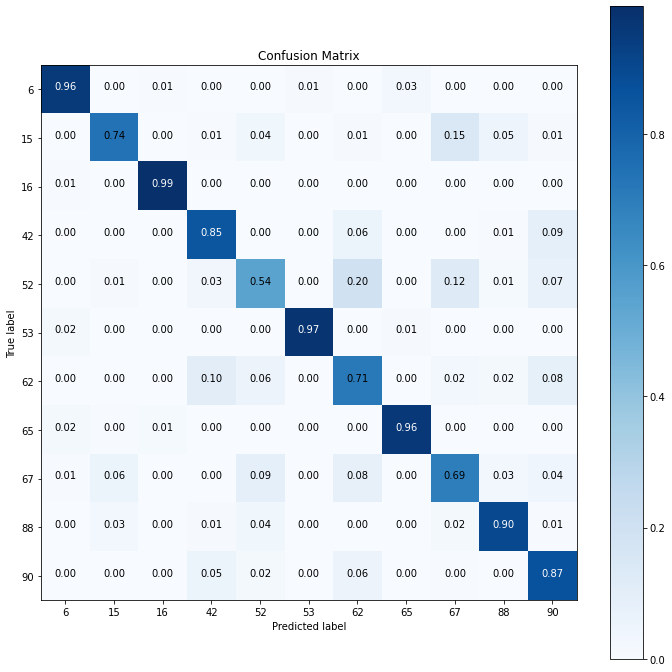


For number of classes: 12

X_train:  (9600, 105) , y_train:  (9600,) , X_test:  (2400, 105) , y_test:  (2400,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 1048.10 seconds

Evaluation GP Model results:
Precision:  0.86
Recall:  0.86
F1-Score:  0.86
Accuracy:  0.86

Per Class Results:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       190
           1       0.85      0.87      0.86       194
           2       0.96      0.98      0.97       195
           3       0.85      0.82      0.84       204
           4       0.77      0.56      0.65       175
           5       0.97      0.96      0.97       194
           6       0.58      0.73      0.65       195
           7       0.97      0.94      0.95       206
           8       0.75      0.69      0.72       213
           9       0.90      0.89      0.90       205
          10       0.82      0.88      0.85       218
          11       0.99      0.98      0.98       211

    accuracy                           0.86      2400
   macro avg       0.86      0.86      0.86      2400
weighted avg       0.86      0.86      0.

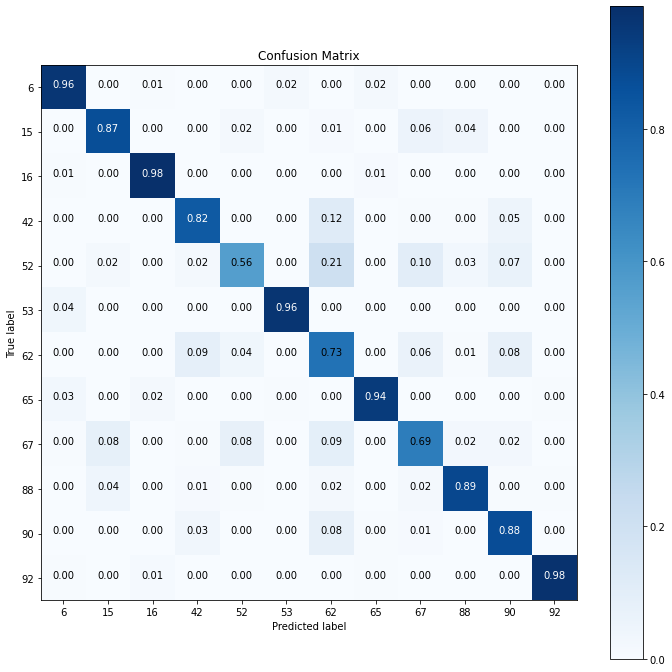


DL evaluation:

Model summary:
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 256)               27136     
_________________________________________________________________
dense_61 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_62 (Dense)             (None, 12)                780       
_________________________________________________________________
activation_20 (Activation)   (None, 12)                0         
Total params: 44,364
Trainable params: 44,364
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
  1/300 [..............................] - ETA: 0s - loss: 2.7918 - accuracy: 0.0000e+00

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11], y=[ 1  3 11 ...  4  4  3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


300/300 [==============================] - 0s 973us/step - loss: 0.7994 - accuracy: 0.7414 - val_loss: 0.5826 - val_accuracy: 0.7912
Epoch 2/500
300/300 [==============================] - 0s 763us/step - loss: 0.5788 - accuracy: 0.8032 - val_loss: 0.5517 - val_accuracy: 0.8037
Epoch 3/500
300/300 [==============================] - 0s 751us/step - loss: 0.5538 - accuracy: 0.8041 - val_loss: 0.5574 - val_accuracy: 0.8079
Epoch 4/500
300/300 [==============================] - 0s 770us/step - loss: 0.5327 - accuracy: 0.8104 - val_loss: 0.5719 - val_accuracy: 0.8075
Epoch 5/500
300/300 [==============================] - 0s 758us/step - loss: 0.5343 - accuracy: 0.8106 - val_loss: 0.5174 - val_accuracy: 0.8171
Epoch 6/500
300/300 [==============================] - 0s 765us/step - loss: 0.5137 - accuracy: 0.8168 - val_loss: 0.5196 - val_accuracy: 0.8138
Epoch 7/500
300/300 [==============================] - 0s 776us/step - loss: 0.5167 - accuracy: 0.8129 - val_loss: 0.5158 - val_accuracy: 0.80

300/300 [==============================] - 0s 754us/step - loss: 0.4339 - accuracy: 0.8458 - val_loss: 0.5369 - val_accuracy: 0.8296
Epoch 114/500
300/300 [==============================] - 0s 747us/step - loss: 0.4307 - accuracy: 0.8458 - val_loss: 0.5401 - val_accuracy: 0.8300
Epoch 115/500
300/300 [==============================] - 0s 720us/step - loss: 0.4335 - accuracy: 0.8460 - val_loss: 0.5625 - val_accuracy: 0.8179
Epoch 116/500
300/300 [==============================] - 0s 748us/step - loss: 0.4391 - accuracy: 0.8428 - val_loss: 0.5221 - val_accuracy: 0.8363
Epoch 117/500
300/300 [==============================] - 0s 749us/step - loss: 0.4266 - accuracy: 0.8482 - val_loss: 0.5260 - val_accuracy: 0.8246
Epoch 118/500
300/300 [==============================] - 0s 766us/step - loss: 0.4304 - accuracy: 0.8443 - val_loss: 0.5062 - val_accuracy: 0.8421
Epoch 119/500
300/300 [==============================] - 0s 784us/step - loss: 0.4283 - accuracy: 0.8426 - val_loss: 0.5126 - val_ac

Epoch 169/500
300/300 [==============================] - 0s 738us/step - loss: 0.4266 - accuracy: 0.8460 - val_loss: 0.5023 - val_accuracy: 0.8392
Epoch 170/500
300/300 [==============================] - 0s 735us/step - loss: 0.4168 - accuracy: 0.8495 - val_loss: 0.5090 - val_accuracy: 0.8396
Epoch 171/500
300/300 [==============================] - 0s 774us/step - loss: 0.4215 - accuracy: 0.8460 - val_loss: 0.5171 - val_accuracy: 0.8325
Epoch 172/500
300/300 [==============================] - 0s 756us/step - loss: 0.4180 - accuracy: 0.8496 - val_loss: 0.5161 - val_accuracy: 0.8371
Epoch 173/500
300/300 [==============================] - 0s 748us/step - loss: 0.4255 - accuracy: 0.8464 - val_loss: 0.5072 - val_accuracy: 0.8433
Epoch 174/500
300/300 [==============================] - 0s 760us/step - loss: 0.4235 - accuracy: 0.8480 - val_loss: 0.5133 - val_accuracy: 0.8408
Epoch 175/500
300/300 [==============================] - 0s 740us/step - loss: 0.4251 - accuracy: 0.8490 - val_loss: 0

Epoch 225/500
300/300 [==============================] - 0s 759us/step - loss: 0.4191 - accuracy: 0.8514 - val_loss: 0.5301 - val_accuracy: 0.8392
Epoch 226/500
300/300 [==============================] - 0s 739us/step - loss: 0.4219 - accuracy: 0.8518 - val_loss: 0.5226 - val_accuracy: 0.8367
Epoch 227/500
300/300 [==============================] - 0s 745us/step - loss: 0.4169 - accuracy: 0.8501 - val_loss: 0.5237 - val_accuracy: 0.8329
Epoch 228/500
300/300 [==============================] - 0s 770us/step - loss: 0.4144 - accuracy: 0.8521 - val_loss: 0.5310 - val_accuracy: 0.8329
Epoch 229/500
300/300 [==============================] - 0s 734us/step - loss: 0.4174 - accuracy: 0.8525 - val_loss: 0.5626 - val_accuracy: 0.8288
Epoch 230/500
300/300 [==============================] - 0s 748us/step - loss: 0.4224 - accuracy: 0.8519 - val_loss: 0.5728 - val_accuracy: 0.8342
Epoch 231/500
300/300 [==============================] - 0s 762us/step - loss: 0.4182 - accuracy: 0.8487 - val_loss: 0

Epoch 281/500
300/300 [==============================] - 0s 783us/step - loss: 0.4166 - accuracy: 0.8511 - val_loss: 0.6116 - val_accuracy: 0.8283
Epoch 282/500
300/300 [==============================] - 0s 765us/step - loss: 0.4198 - accuracy: 0.8487 - val_loss: 0.6075 - val_accuracy: 0.8358
Epoch 283/500
300/300 [==============================] - 0s 832us/step - loss: 0.4112 - accuracy: 0.8528 - val_loss: 0.5809 - val_accuracy: 0.8388
Epoch 284/500
300/300 [==============================] - 0s 820us/step - loss: 0.4098 - accuracy: 0.8514 - val_loss: 0.5910 - val_accuracy: 0.8350
Epoch 285/500
300/300 [==============================] - 0s 803us/step - loss: 0.4096 - accuracy: 0.8530 - val_loss: 0.6002 - val_accuracy: 0.8300
Epoch 286/500
300/300 [==============================] - 0s 791us/step - loss: 0.4115 - accuracy: 0.8526 - val_loss: 0.6194 - val_accuracy: 0.8413
Epoch 287/500
300/300 [==============================] - 0s 818us/step - loss: 0.4094 - accuracy: 0.8524 - val_loss: 0

Epoch 337/500
300/300 [==============================] - 0s 771us/step - loss: 0.4095 - accuracy: 0.8526 - val_loss: 0.5605 - val_accuracy: 0.8475
Epoch 338/500
300/300 [==============================] - 0s 809us/step - loss: 0.4094 - accuracy: 0.8526 - val_loss: 0.5748 - val_accuracy: 0.8438
Epoch 339/500
300/300 [==============================] - 0s 797us/step - loss: 0.4224 - accuracy: 0.8503 - val_loss: 0.5750 - val_accuracy: 0.8408
Epoch 340/500
300/300 [==============================] - 0s 788us/step - loss: 0.4112 - accuracy: 0.8545 - val_loss: 0.5555 - val_accuracy: 0.8425
Epoch 341/500
300/300 [==============================] - 0s 809us/step - loss: 0.4066 - accuracy: 0.8546 - val_loss: 0.5934 - val_accuracy: 0.8358
Epoch 342/500
300/300 [==============================] - 0s 820us/step - loss: 0.4066 - accuracy: 0.8548 - val_loss: 0.5640 - val_accuracy: 0.8300
Epoch 343/500
300/300 [==============================] - 0s 834us/step - loss: 0.4092 - accuracy: 0.8542 - val_loss: 0

Epoch 393/500
300/300 [==============================] - 0s 796us/step - loss: 0.4057 - accuracy: 0.8566 - val_loss: 0.5982 - val_accuracy: 0.8429
Epoch 394/500
300/300 [==============================] - 0s 770us/step - loss: 0.4381 - accuracy: 0.8533 - val_loss: 0.5783 - val_accuracy: 0.8304
Epoch 395/500
300/300 [==============================] - 0s 817us/step - loss: 0.4192 - accuracy: 0.8526 - val_loss: 0.5661 - val_accuracy: 0.8467
Epoch 396/500
300/300 [==============================] - 0s 867us/step - loss: 0.4084 - accuracy: 0.8543 - val_loss: 0.5811 - val_accuracy: 0.8396
Epoch 397/500
300/300 [==============================] - 0s 801us/step - loss: 0.4087 - accuracy: 0.8533 - val_loss: 0.5438 - val_accuracy: 0.8446
Epoch 398/500
300/300 [==============================] - 0s 785us/step - loss: 0.4064 - accuracy: 0.8536 - val_loss: 0.5474 - val_accuracy: 0.8438
Epoch 399/500
300/300 [==============================] - 0s 770us/step - loss: 0.4012 - accuracy: 0.8573 - val_loss: 0

Epoch 449/500
300/300 [==============================] - 0s 782us/step - loss: 0.4054 - accuracy: 0.8553 - val_loss: 0.6255 - val_accuracy: 0.8433
Epoch 450/500
300/300 [==============================] - 0s 772us/step - loss: 0.4023 - accuracy: 0.8568 - val_loss: 0.6293 - val_accuracy: 0.8438
Epoch 451/500
300/300 [==============================] - 0s 741us/step - loss: 0.4035 - accuracy: 0.8559 - val_loss: 0.6053 - val_accuracy: 0.8458
Epoch 452/500
300/300 [==============================] - 0s 751us/step - loss: 0.4027 - accuracy: 0.8549 - val_loss: 0.6158 - val_accuracy: 0.8421
Epoch 453/500
300/300 [==============================] - 0s 746us/step - loss: 0.4009 - accuracy: 0.8561 - val_loss: 0.6077 - val_accuracy: 0.8433
Epoch 454/500
300/300 [==============================] - 0s 750us/step - loss: 0.4055 - accuracy: 0.8548 - val_loss: 0.6289 - val_accuracy: 0.8346
Epoch 455/500
300/300 [==============================] - 0s 740us/step - loss: 0.4000 - accuracy: 0.8554 - val_loss: 0

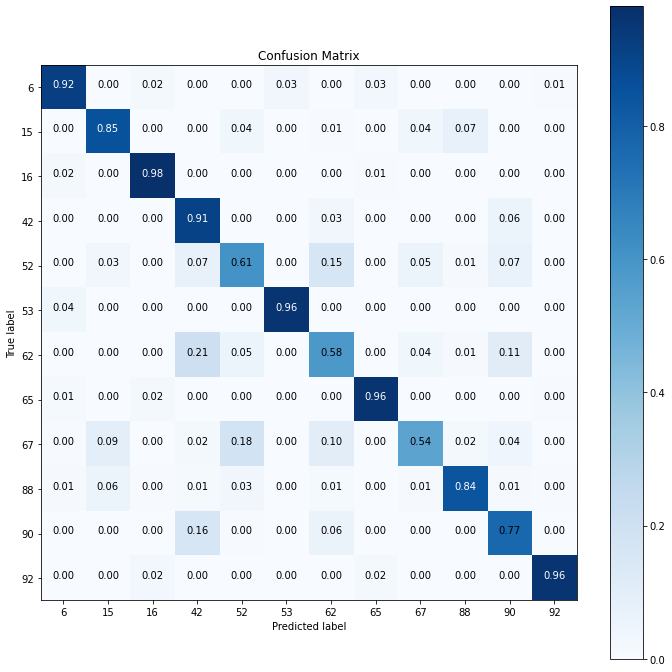

([0.99, 0.99, 0.93, 0.94, 0.88, 0.89, 0.86, 0.85, 0.85, 0.86],
 [29.08, 77.94, 132.06, 189.4, 266.45, 353.37, 485.15, 637.05, 855.65, 1048.1],
 [0.99, 0.99, 0.93, 0.94, 0.88, 0.89, 0.86, 0.85, 0.86, 0.86],
 [0.99, 0.99, 0.93, 0.94, 0.88, 0.89, 0.86, 0.85, 0.85, 0.86],
 [0.99, 0.99, 0.93, 0.94, 0.88, 0.89, 0.85, 0.85, 0.85, 0.86],
 [0.98, 0.99, 0.93, 0.94, 0.88, 0.89, 0.85, 0.82, 0.84, 0.82],
 [38.49, 47.49, 61.46, 70.74, 76.43, 81.38, 95.82, 107.24, 112.09, 116.19],
 [0.98, 0.99, 0.93, 0.94, 0.89, 0.9, 0.86, 0.83, 0.84, 0.83],
 [0.98, 0.99, 0.93, 0.94, 0.88, 0.89, 0.85, 0.82, 0.84, 0.82],
 [0.98, 0.99, 0.93, 0.94, 0.88, 0.89, 0.85, 0.82, 0.84, 0.82])

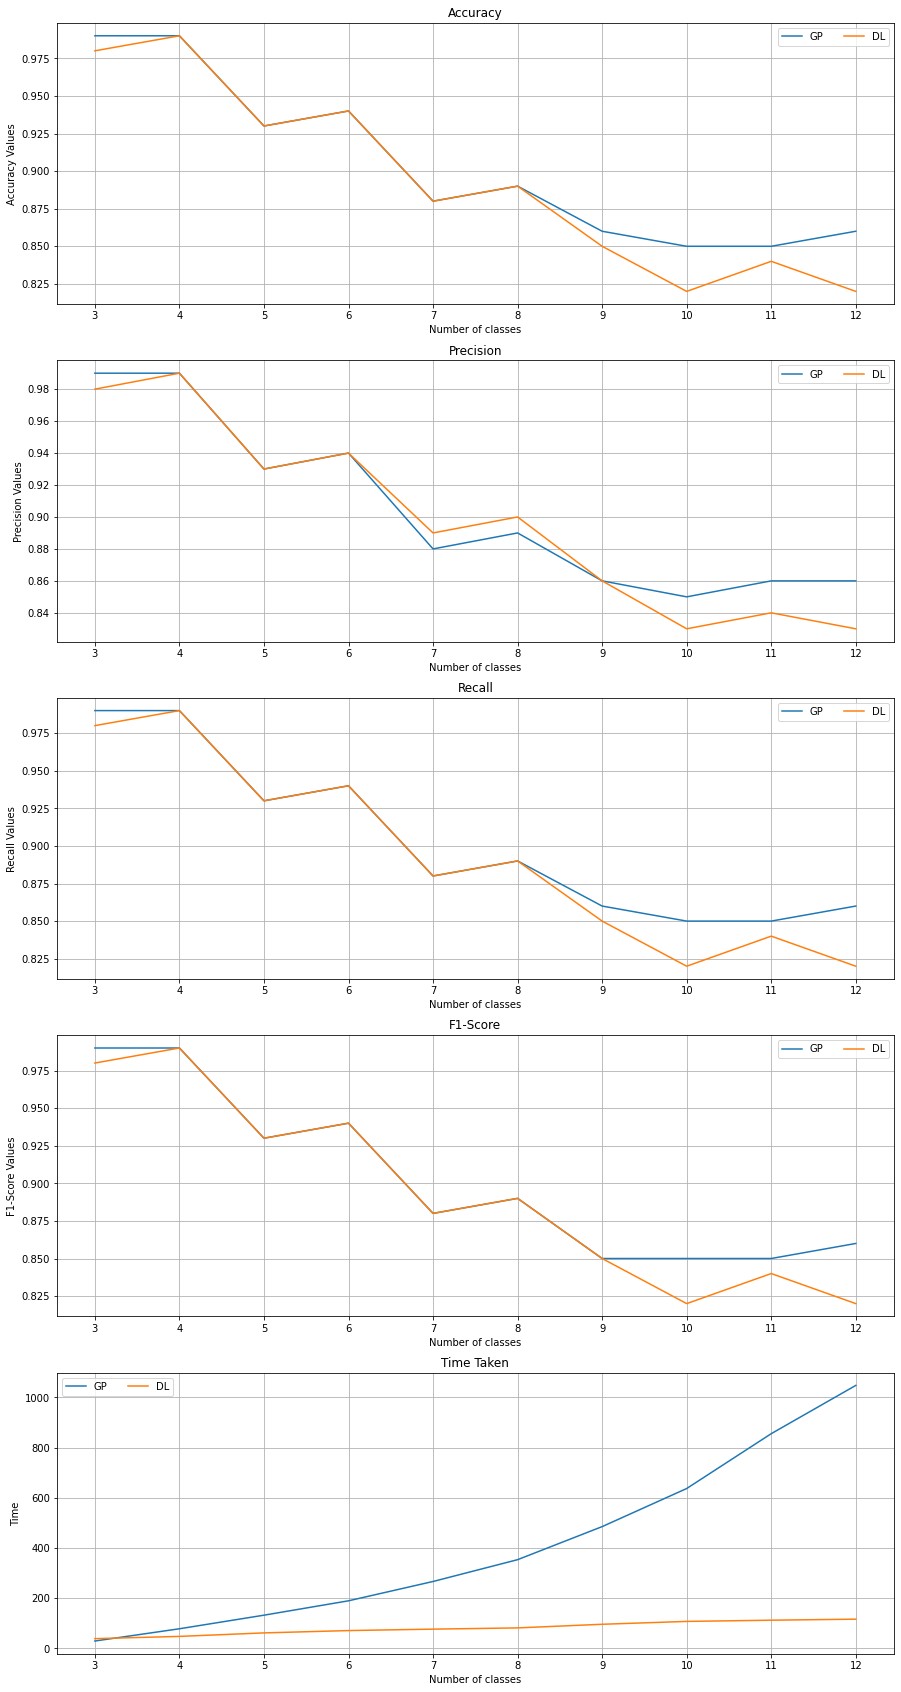

In [14]:
run_models(dl_model_2, 1000)

# Using 2000 object per class Dataset

Dataset Shape: (14000, 107)

For number of classes: 3

X_train:  (4800, 105) , y_train:  (4800,) , X_test:  (1200, 105) , y_test:  (1200,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 91.97 seconds

Evaluation GP Model results:
Precision:  1.0
Recall:  1.0
F1-Score:  1.0
Accuracy:  1.0

Per Class Results:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       407
           1       1.00      1.00      1.00       405
           2       0.99      1.00      0.99       388

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



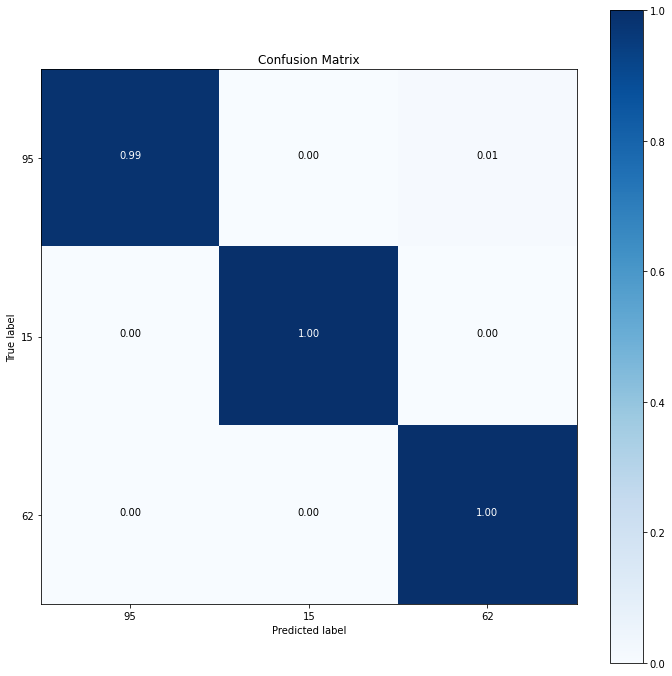


DL evaluation:

Model summary:
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 256)               27136     
_________________________________________________________________
dense_64 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_65 (Dense)             (None, 3)                 195       
_________________________________________________________________
activation_21 (Activation)   (None, 3)                 0         
Total params: 43,779
Trainable params: 43,779
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
  1/150 [..............................] - ETA: 0s - loss: 1.3491 - accuracy: 0.4375

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2], y=[1 0 1 ... 2 2 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


150/150 [==============================] - 0s 1ms/step - loss: 0.0896 - accuracy: 0.9844 - val_loss: 0.0322 - val_accuracy: 0.9933
Epoch 2/500
150/150 [==============================] - 0s 852us/step - loss: 0.0156 - accuracy: 0.9954 - val_loss: 0.0209 - val_accuracy: 0.9942
Epoch 3/500
150/150 [==============================] - 0s 812us/step - loss: 0.0126 - accuracy: 0.9979 - val_loss: 0.0183 - val_accuracy: 0.9950
Epoch 4/500
150/150 [==============================] - 0s 847us/step - loss: 0.0118 - accuracy: 0.9979 - val_loss: 0.0179 - val_accuracy: 0.9950
Epoch 5/500
150/150 [==============================] - 0s 913us/step - loss: 0.0130 - accuracy: 0.9977 - val_loss: 0.0163 - val_accuracy: 0.9950
Epoch 6/500
150/150 [==============================] - 0s 924us/step - loss: 0.0104 - accuracy: 0.9983 - val_loss: 0.0201 - val_accuracy: 0.9950
Epoch 7/500
150/150 [==============================] - 0s 911us/step - loss: 0.0105 - accuracy: 0.9983 - val_loss: 0.0166 - val_accuracy: 0.9950

150/150 [==============================] - 0s 1ms/step - loss: 0.0088 - accuracy: 0.9983 - val_loss: 0.0072 - val_accuracy: 0.9992
Epoch 114/500
150/150 [==============================] - 0s 940us/step - loss: 0.0082 - accuracy: 0.9990 - val_loss: 0.0066 - val_accuracy: 0.9992
Epoch 115/500
150/150 [==============================] - 0s 958us/step - loss: 0.0077 - accuracy: 0.9983 - val_loss: 0.0069 - val_accuracy: 0.9992
Epoch 116/500
150/150 [==============================] - 0s 899us/step - loss: 0.0069 - accuracy: 0.9987 - val_loss: 0.0075 - val_accuracy: 0.9992
Epoch 117/500
150/150 [==============================] - 0s 940us/step - loss: 0.0071 - accuracy: 0.9985 - val_loss: 0.0112 - val_accuracy: 0.9967
Epoch 118/500
150/150 [==============================] - 0s 1ms/step - loss: 0.0074 - accuracy: 0.9985 - val_loss: 0.0123 - val_accuracy: 0.9975
Epoch 119/500
150/150 [==============================] - 0s 942us/step - loss: 0.0070 - accuracy: 0.9985 - val_loss: 0.0160 - val_accura

Epoch 169/500
150/150 [==============================] - 0s 863us/step - loss: 0.0076 - accuracy: 0.9985 - val_loss: 0.0106 - val_accuracy: 0.9983
Epoch 170/500
150/150 [==============================] - 0s 873us/step - loss: 0.0083 - accuracy: 0.9985 - val_loss: 0.0160 - val_accuracy: 0.9975
Epoch 171/500
150/150 [==============================] - 0s 920us/step - loss: 0.0083 - accuracy: 0.9979 - val_loss: 0.0139 - val_accuracy: 0.9975
Epoch 172/500
150/150 [==============================] - 0s 905us/step - loss: 0.0070 - accuracy: 0.9981 - val_loss: 0.0075 - val_accuracy: 0.9992
Epoch 173/500
150/150 [==============================] - 0s 874us/step - loss: 0.0075 - accuracy: 0.9987 - val_loss: 0.0072 - val_accuracy: 0.9992
Epoch 174/500
150/150 [==============================] - 0s 911us/step - loss: 0.0068 - accuracy: 0.9985 - val_loss: 0.0072 - val_accuracy: 0.9992
Epoch 175/500
150/150 [==============================] - 0s 881us/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 0

Epoch 225/500
150/150 [==============================] - 0s 954us/step - loss: 0.0051 - accuracy: 0.9990 - val_loss: 0.0067 - val_accuracy: 0.9992
Epoch 226/500
150/150 [==============================] - 0s 863us/step - loss: 0.0056 - accuracy: 0.9992 - val_loss: 0.0070 - val_accuracy: 0.9992
Epoch 227/500
150/150 [==============================] - 0s 846us/step - loss: 0.0067 - accuracy: 0.9987 - val_loss: 0.0063 - val_accuracy: 0.9992
Epoch 228/500
150/150 [==============================] - 0s 878us/step - loss: 0.0062 - accuracy: 0.9987 - val_loss: 0.0087 - val_accuracy: 0.9983
Epoch 229/500
150/150 [==============================] - 0s 859us/step - loss: 0.0069 - accuracy: 0.9987 - val_loss: 0.0064 - val_accuracy: 0.9992
Epoch 230/500
150/150 [==============================] - 0s 867us/step - loss: 0.0056 - accuracy: 0.9987 - val_loss: 0.0073 - val_accuracy: 0.9992
Epoch 231/500
150/150 [==============================] - 0s 820us/step - loss: 0.0067 - accuracy: 0.9987 - val_loss: 0

Epoch 281/500
150/150 [==============================] - 0s 880us/step - loss: 0.0059 - accuracy: 0.9987 - val_loss: 0.0068 - val_accuracy: 0.9992
Epoch 282/500
150/150 [==============================] - 0s 906us/step - loss: 0.0067 - accuracy: 0.9990 - val_loss: 0.0062 - val_accuracy: 0.9992
Epoch 283/500
150/150 [==============================] - 0s 868us/step - loss: 0.0060 - accuracy: 0.9987 - val_loss: 0.0092 - val_accuracy: 0.9992
Epoch 284/500
150/150 [==============================] - 0s 828us/step - loss: 0.0066 - accuracy: 0.9990 - val_loss: 0.0064 - val_accuracy: 0.9992
Epoch 285/500
150/150 [==============================] - 0s 878us/step - loss: 0.0058 - accuracy: 0.9990 - val_loss: 0.0066 - val_accuracy: 0.9992
Epoch 286/500
150/150 [==============================] - 0s 853us/step - loss: 0.0064 - accuracy: 0.9985 - val_loss: 0.0074 - val_accuracy: 0.9992
Epoch 287/500
150/150 [==============================] - 0s 875us/step - loss: 0.0063 - accuracy: 0.9990 - val_loss: 0

Epoch 337/500
150/150 [==============================] - 0s 834us/step - loss: 0.0065 - accuracy: 0.9985 - val_loss: 0.0066 - val_accuracy: 0.9992
Epoch 338/500
150/150 [==============================] - 0s 910us/step - loss: 0.0061 - accuracy: 0.9990 - val_loss: 0.0068 - val_accuracy: 0.9992
Epoch 339/500
150/150 [==============================] - 0s 842us/step - loss: 0.0063 - accuracy: 0.9987 - val_loss: 0.0069 - val_accuracy: 0.9992
Epoch 340/500
150/150 [==============================] - 0s 839us/step - loss: 0.0081 - accuracy: 0.9983 - val_loss: 0.0092 - val_accuracy: 0.9983
Epoch 341/500
150/150 [==============================] - 0s 873us/step - loss: 0.0066 - accuracy: 0.9985 - val_loss: 0.0080 - val_accuracy: 0.9983
Epoch 342/500
150/150 [==============================] - 0s 895us/step - loss: 0.0065 - accuracy: 0.9990 - val_loss: 0.0088 - val_accuracy: 0.9983
Epoch 343/500
150/150 [==============================] - 0s 860us/step - loss: 0.0063 - accuracy: 0.9985 - val_loss: 0

Epoch 393/500
150/150 [==============================] - 0s 872us/step - loss: 0.0064 - accuracy: 0.9990 - val_loss: 0.0097 - val_accuracy: 0.9983
Epoch 394/500
150/150 [==============================] - 0s 876us/step - loss: 0.0066 - accuracy: 0.9992 - val_loss: 0.0061 - val_accuracy: 0.9992
Epoch 395/500
150/150 [==============================] - 0s 849us/step - loss: 0.0065 - accuracy: 0.9990 - val_loss: 0.0186 - val_accuracy: 0.9942
Epoch 396/500
150/150 [==============================] - 0s 880us/step - loss: 0.0085 - accuracy: 0.9985 - val_loss: 0.0061 - val_accuracy: 0.9992
Epoch 397/500
150/150 [==============================] - 0s 879us/step - loss: 0.0063 - accuracy: 0.9990 - val_loss: 0.0062 - val_accuracy: 0.9992
Epoch 398/500
150/150 [==============================] - 0s 888us/step - loss: 0.0061 - accuracy: 0.9985 - val_loss: 0.0068 - val_accuracy: 0.9992
Epoch 399/500
150/150 [==============================] - 0s 857us/step - loss: 0.0059 - accuracy: 0.9990 - val_loss: 0

Epoch 449/500
150/150 [==============================] - 0s 877us/step - loss: 0.0053 - accuracy: 0.9990 - val_loss: 0.0098 - val_accuracy: 0.9983
Epoch 450/500
150/150 [==============================] - 0s 938us/step - loss: 0.0064 - accuracy: 0.9987 - val_loss: 0.0120 - val_accuracy: 0.9983
Epoch 451/500
150/150 [==============================] - 0s 899us/step - loss: 0.0062 - accuracy: 0.9987 - val_loss: 0.0089 - val_accuracy: 0.9983
Epoch 452/500
150/150 [==============================] - 0s 937us/step - loss: 0.0057 - accuracy: 0.9990 - val_loss: 0.0084 - val_accuracy: 0.9983
Epoch 453/500
150/150 [==============================] - 0s 865us/step - loss: 0.0131 - accuracy: 0.9969 - val_loss: 0.0261 - val_accuracy: 0.9975
Epoch 454/500
150/150 [==============================] - 0s 880us/step - loss: 0.0088 - accuracy: 0.9985 - val_loss: 0.0069 - val_accuracy: 0.9983
Epoch 455/500
150/150 [==============================] - 0s 842us/step - loss: 0.0067 - accuracy: 0.9985 - val_loss: 0

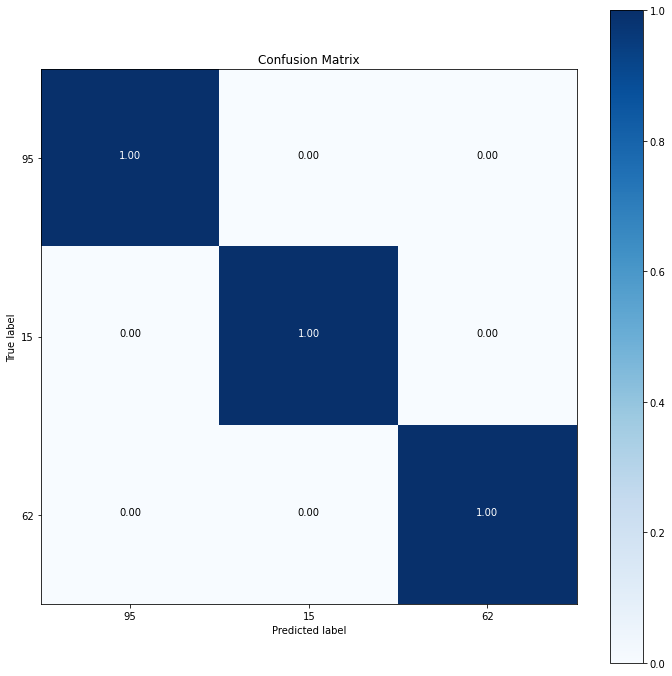


For number of classes: 4

X_train:  (6400, 105) , y_train:  (6400,) , X_test:  (1600, 105) , y_test:  (1600,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 359.82 seconds

Evaluation GP Model results:
Precision:  0.93
Recall:  0.94
F1-Score:  0.93
Accuracy:  0.94

Per Class Results:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       401
           1       1.00      1.00      1.00       425
           2       0.92      0.99      0.96       380
           3       0.88      0.86      0.87       394

    accuracy                           0.94      1600
   macro avg       0.93      0.93      0.93      1600
weighted avg       0.93      0.94      0.93      1600



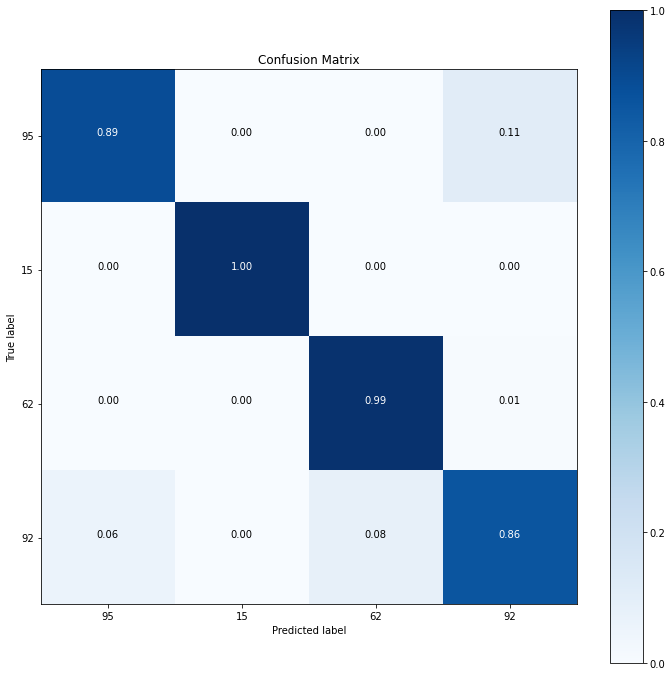


DL evaluation:

Model summary:
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 256)               27136     
_________________________________________________________________
dense_67 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_68 (Dense)             (None, 4)                 260       
_________________________________________________________________
activation_22 (Activation)   (None, 4)                 0         
Total params: 43,844
Trainable params: 43,844
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
  1/200 [..............................] - ETA: 0s - loss: 1.5068 - accuracy: 0.2812

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3], y=[1 2 0 ... 2 1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


200/200 [==============================] - 0s 1ms/step - loss: 0.3240 - accuracy: 0.8808 - val_loss: 0.2531 - val_accuracy: 0.8881
Epoch 2/500
200/200 [==============================] - 0s 793us/step - loss: 0.2919 - accuracy: 0.8927 - val_loss: 0.2618 - val_accuracy: 0.8925
Epoch 3/500
200/200 [==============================] - 0s 739us/step - loss: 0.2479 - accuracy: 0.9022 - val_loss: 0.2577 - val_accuracy: 0.8919
Epoch 4/500
200/200 [==============================] - 0s 739us/step - loss: 0.2448 - accuracy: 0.9034 - val_loss: 0.2502 - val_accuracy: 0.8969
Epoch 5/500
200/200 [==============================] - 0s 746us/step - loss: 0.2400 - accuracy: 0.9045 - val_loss: 0.2649 - val_accuracy: 0.8969
Epoch 6/500
200/200 [==============================] - 0s 759us/step - loss: 0.2403 - accuracy: 0.8992 - val_loss: 0.2446 - val_accuracy: 0.8956
Epoch 7/500
200/200 [==============================] - 0s 759us/step - loss: 0.2377 - accuracy: 0.9050 - val_loss: 0.2728 - val_accuracy: 0.8994

200/200 [==============================] - 0s 789us/step - loss: 0.1877 - accuracy: 0.9267 - val_loss: 0.2400 - val_accuracy: 0.9194
Epoch 114/500
200/200 [==============================] - 0s 747us/step - loss: 0.1893 - accuracy: 0.9259 - val_loss: 0.2204 - val_accuracy: 0.9187
Epoch 115/500
200/200 [==============================] - 0s 743us/step - loss: 0.1910 - accuracy: 0.9272 - val_loss: 0.2197 - val_accuracy: 0.9194
Epoch 116/500
200/200 [==============================] - 0s 736us/step - loss: 0.1882 - accuracy: 0.9234 - val_loss: 0.2409 - val_accuracy: 0.9194
Epoch 117/500
200/200 [==============================] - 0s 774us/step - loss: 0.1913 - accuracy: 0.9237 - val_loss: 0.2266 - val_accuracy: 0.9169
Epoch 118/500
200/200 [==============================] - 0s 784us/step - loss: 0.1925 - accuracy: 0.9248 - val_loss: 0.2256 - val_accuracy: 0.9150
Epoch 119/500
200/200 [==============================] - 0s 788us/step - loss: 0.1878 - accuracy: 0.9253 - val_loss: 0.2166 - val_ac

Epoch 169/500
200/200 [==============================] - 0s 749us/step - loss: 0.1863 - accuracy: 0.9277 - val_loss: 0.2230 - val_accuracy: 0.9162
Epoch 170/500
200/200 [==============================] - 0s 793us/step - loss: 0.1883 - accuracy: 0.9225 - val_loss: 0.2133 - val_accuracy: 0.9225
Epoch 171/500
200/200 [==============================] - 0s 832us/step - loss: 0.1813 - accuracy: 0.9269 - val_loss: 0.2232 - val_accuracy: 0.9206
Epoch 172/500
200/200 [==============================] - 0s 746us/step - loss: 0.1860 - accuracy: 0.9252 - val_loss: 0.2175 - val_accuracy: 0.9169
Epoch 173/500
200/200 [==============================] - 0s 748us/step - loss: 0.1856 - accuracy: 0.9259 - val_loss: 0.2211 - val_accuracy: 0.9206
Epoch 174/500
200/200 [==============================] - 0s 764us/step - loss: 0.1843 - accuracy: 0.9264 - val_loss: 0.2118 - val_accuracy: 0.9200
Epoch 175/500
200/200 [==============================] - 0s 789us/step - loss: 0.1837 - accuracy: 0.9258 - val_loss: 0

Epoch 225/500
200/200 [==============================] - 0s 711us/step - loss: 0.1827 - accuracy: 0.9287 - val_loss: 0.2119 - val_accuracy: 0.9256
Epoch 226/500
200/200 [==============================] - 0s 783us/step - loss: 0.1835 - accuracy: 0.9286 - val_loss: 0.2263 - val_accuracy: 0.9212
Epoch 227/500
200/200 [==============================] - 0s 792us/step - loss: 0.1827 - accuracy: 0.9298 - val_loss: 0.2139 - val_accuracy: 0.9256
Epoch 228/500
200/200 [==============================] - 0s 785us/step - loss: 0.1804 - accuracy: 0.9297 - val_loss: 0.2116 - val_accuracy: 0.9219
Epoch 229/500
200/200 [==============================] - 0s 761us/step - loss: 0.1797 - accuracy: 0.9309 - val_loss: 0.2216 - val_accuracy: 0.9181
Epoch 230/500
200/200 [==============================] - 0s 788us/step - loss: 0.1801 - accuracy: 0.9286 - val_loss: 0.2066 - val_accuracy: 0.9212
Epoch 231/500
200/200 [==============================] - 0s 765us/step - loss: 0.1837 - accuracy: 0.9287 - val_loss: 0

Epoch 281/500
200/200 [==============================] - 0s 747us/step - loss: 0.1785 - accuracy: 0.9311 - val_loss: 0.2466 - val_accuracy: 0.9275
Epoch 282/500
200/200 [==============================] - 0s 809us/step - loss: 0.1794 - accuracy: 0.9297 - val_loss: 0.2643 - val_accuracy: 0.9187
Epoch 283/500
200/200 [==============================] - 0s 798us/step - loss: 0.1808 - accuracy: 0.9284 - val_loss: 0.2426 - val_accuracy: 0.9225
Epoch 284/500
200/200 [==============================] - 0s 747us/step - loss: 0.1789 - accuracy: 0.9303 - val_loss: 0.2704 - val_accuracy: 0.9181
Epoch 285/500
200/200 [==============================] - 0s 762us/step - loss: 0.2896 - accuracy: 0.9234 - val_loss: 0.2627 - val_accuracy: 0.9156
Epoch 286/500
200/200 [==============================] - 0s 744us/step - loss: 0.1815 - accuracy: 0.9272 - val_loss: 0.2394 - val_accuracy: 0.9212
Epoch 287/500
200/200 [==============================] - 0s 759us/step - loss: 0.1819 - accuracy: 0.9278 - val_loss: 0

Epoch 337/500
200/200 [==============================] - 0s 751us/step - loss: 0.1782 - accuracy: 0.9319 - val_loss: 0.2595 - val_accuracy: 0.9244
Epoch 338/500
200/200 [==============================] - 0s 748us/step - loss: 0.1791 - accuracy: 0.9272 - val_loss: 0.2339 - val_accuracy: 0.9244
Epoch 339/500
200/200 [==============================] - 0s 741us/step - loss: 0.1780 - accuracy: 0.9292 - val_loss: 0.2837 - val_accuracy: 0.9219
Epoch 340/500
200/200 [==============================] - 0s 771us/step - loss: 0.1775 - accuracy: 0.9336 - val_loss: 0.2673 - val_accuracy: 0.9300
Epoch 341/500
200/200 [==============================] - 0s 810us/step - loss: 0.1758 - accuracy: 0.9319 - val_loss: 0.2681 - val_accuracy: 0.9244
Epoch 342/500
200/200 [==============================] - 0s 749us/step - loss: 0.1783 - accuracy: 0.9303 - val_loss: 0.2515 - val_accuracy: 0.9212
Epoch 343/500
200/200 [==============================] - 0s 817us/step - loss: 0.1793 - accuracy: 0.9297 - val_loss: 0

Epoch 393/500
200/200 [==============================] - 0s 793us/step - loss: 0.1755 - accuracy: 0.9325 - val_loss: 0.2295 - val_accuracy: 0.9231
Epoch 394/500
200/200 [==============================] - 0s 783us/step - loss: 0.1766 - accuracy: 0.9317 - val_loss: 0.2309 - val_accuracy: 0.9269
Epoch 395/500
200/200 [==============================] - 0s 744us/step - loss: 0.1747 - accuracy: 0.9309 - val_loss: 0.2317 - val_accuracy: 0.9237
Epoch 396/500
200/200 [==============================] - 0s 804us/step - loss: 0.1746 - accuracy: 0.9312 - val_loss: 0.2550 - val_accuracy: 0.9094
Epoch 397/500
200/200 [==============================] - 0s 763us/step - loss: 0.1770 - accuracy: 0.9300 - val_loss: 0.2617 - val_accuracy: 0.9187
Epoch 398/500
200/200 [==============================] - 0s 780us/step - loss: 0.1805 - accuracy: 0.9303 - val_loss: 0.2124 - val_accuracy: 0.9250
Epoch 399/500
200/200 [==============================] - 0s 741us/step - loss: 0.1762 - accuracy: 0.9306 - val_loss: 0

Epoch 449/500
200/200 [==============================] - 0s 847us/step - loss: 0.1802 - accuracy: 0.9294 - val_loss: 0.2223 - val_accuracy: 0.9219
Epoch 450/500
200/200 [==============================] - 0s 827us/step - loss: 0.2982 - accuracy: 0.9252 - val_loss: 0.2167 - val_accuracy: 0.9187
Epoch 451/500
200/200 [==============================] - 0s 854us/step - loss: 0.1818 - accuracy: 0.9267 - val_loss: 0.2035 - val_accuracy: 0.9287
Epoch 452/500
200/200 [==============================] - 0s 842us/step - loss: 0.1872 - accuracy: 0.9267 - val_loss: 0.2204 - val_accuracy: 0.9219
Epoch 453/500
200/200 [==============================] - 0s 818us/step - loss: 0.1833 - accuracy: 0.9287 - val_loss: 0.2033 - val_accuracy: 0.9244
Epoch 454/500
200/200 [==============================] - 0s 860us/step - loss: 0.1774 - accuracy: 0.9311 - val_loss: 0.2046 - val_accuracy: 0.9231
Epoch 455/500
200/200 [==============================] - 0s 869us/step - loss: 0.1738 - accuracy: 0.9336 - val_loss: 0

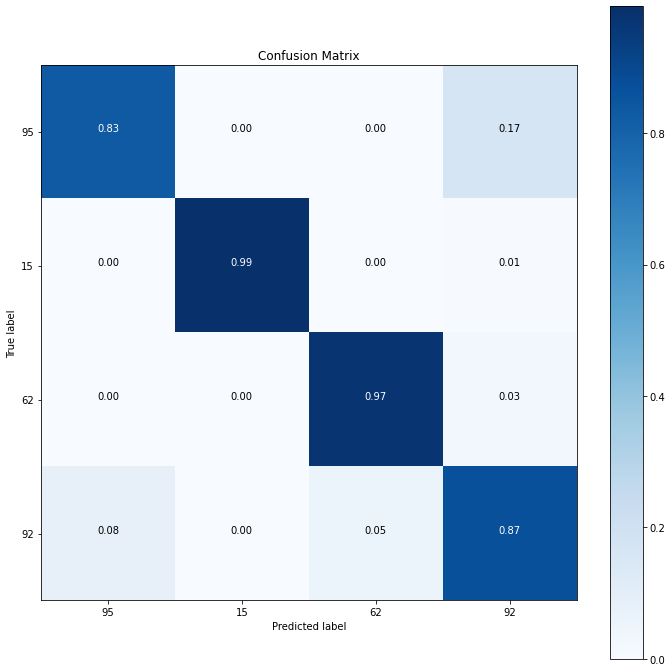


For number of classes: 5

X_train:  (8000, 105) , y_train:  (8000,) , X_test:  (2000, 105) , y_test:  (2000,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 619.93 seconds

Evaluation GP Model results:
Precision:  0.87
Recall:  0.87
F1-Score:  0.87
Accuracy:  0.87

Per Class Results:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       429
           1       1.00      1.00      1.00       394
           2       0.89      0.90      0.89       391
           3       0.80      0.72      0.76       395
           4       0.74      0.85      0.79       391

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



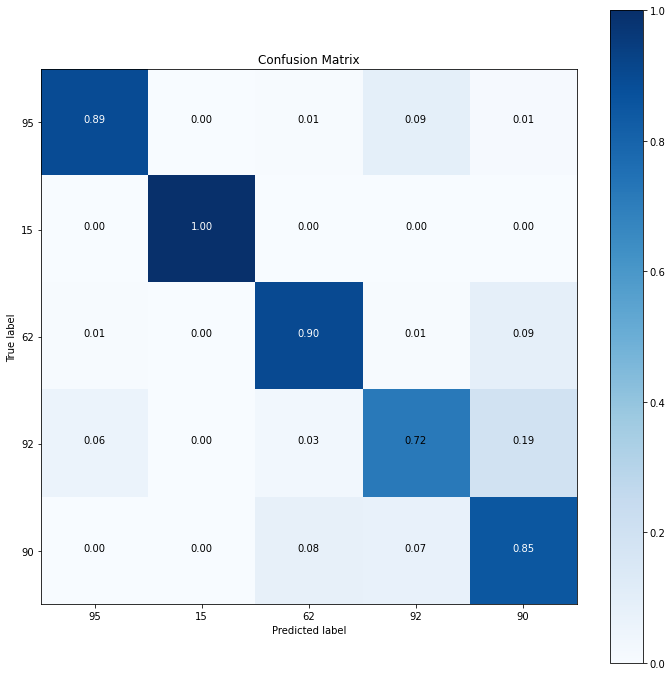


DL evaluation:

Model summary:
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 256)               27136     
_________________________________________________________________
dense_70 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_71 (Dense)             (None, 5)                 325       
_________________________________________________________________
activation_23 (Activation)   (None, 5)                 0         
Total params: 43,909
Trainable params: 43,909
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
  1/250 [..............................] - ETA: 0s - loss: 2.0169 - accuracy: 0.2500

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4], y=[2 2 2 ... 2 4 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


250/250 [==============================] - 0s 1ms/step - loss: 0.5313 - accuracy: 0.7919 - val_loss: 0.4365 - val_accuracy: 0.8155
Epoch 2/500
250/250 [==============================] - 0s 937us/step - loss: 0.4268 - accuracy: 0.8131 - val_loss: 0.4463 - val_accuracy: 0.7990
Epoch 3/500
250/250 [==============================] - 0s 942us/step - loss: 0.4213 - accuracy: 0.8136 - val_loss: 0.4302 - val_accuracy: 0.8205
Epoch 4/500
250/250 [==============================] - 0s 960us/step - loss: 0.4196 - accuracy: 0.8161 - val_loss: 0.4146 - val_accuracy: 0.8295
Epoch 5/500
250/250 [==============================] - 0s 963us/step - loss: 0.4105 - accuracy: 0.8188 - val_loss: 0.4450 - val_accuracy: 0.8125
Epoch 6/500
250/250 [==============================] - 0s 878us/step - loss: 0.4100 - accuracy: 0.8209 - val_loss: 0.4156 - val_accuracy: 0.8300
Epoch 7/500
250/250 [==============================] - 0s 858us/step - loss: 0.4111 - accuracy: 0.8213 - val_loss: 0.4180 - val_accuracy: 0.8215

250/250 [==============================] - 0s 920us/step - loss: 0.3617 - accuracy: 0.8434 - val_loss: 0.3744 - val_accuracy: 0.8505
Epoch 114/500
250/250 [==============================] - 0s 892us/step - loss: 0.3578 - accuracy: 0.8480 - val_loss: 0.3830 - val_accuracy: 0.8535
Epoch 115/500
250/250 [==============================] - 0s 895us/step - loss: 0.3796 - accuracy: 0.8443 - val_loss: 0.3918 - val_accuracy: 0.8415
Epoch 116/500
250/250 [==============================] - 0s 1ms/step - loss: 0.3630 - accuracy: 0.8441 - val_loss: 0.3809 - val_accuracy: 0.8425
Epoch 117/500
250/250 [==============================] - 0s 868us/step - loss: 0.3596 - accuracy: 0.8482 - val_loss: 0.3740 - val_accuracy: 0.8470
Epoch 118/500
250/250 [==============================] - 0s 860us/step - loss: 0.3547 - accuracy: 0.8465 - val_loss: 0.3690 - val_accuracy: 0.8405
Epoch 119/500
250/250 [==============================] - 0s 853us/step - loss: 0.3570 - accuracy: 0.8493 - val_loss: 0.3728 - val_accu

Epoch 169/500
250/250 [==============================] - 0s 805us/step - loss: 0.3517 - accuracy: 0.8478 - val_loss: 0.3794 - val_accuracy: 0.8530
Epoch 170/500
250/250 [==============================] - 0s 787us/step - loss: 0.3551 - accuracy: 0.8504 - val_loss: 0.3776 - val_accuracy: 0.8475
Epoch 171/500
250/250 [==============================] - 0s 802us/step - loss: 0.3540 - accuracy: 0.8511 - val_loss: 0.3757 - val_accuracy: 0.8585
Epoch 172/500
250/250 [==============================] - 0s 807us/step - loss: 0.3490 - accuracy: 0.8491 - val_loss: 0.3803 - val_accuracy: 0.8465
Epoch 173/500
250/250 [==============================] - 0s 839us/step - loss: 0.3573 - accuracy: 0.8464 - val_loss: 0.4056 - val_accuracy: 0.8570
Epoch 174/500
250/250 [==============================] - 0s 837us/step - loss: 0.3560 - accuracy: 0.8476 - val_loss: 0.3901 - val_accuracy: 0.8495
Epoch 175/500
250/250 [==============================] - 0s 830us/step - loss: 0.3513 - accuracy: 0.8524 - val_loss: 0

Epoch 225/500
250/250 [==============================] - 0s 901us/step - loss: 0.3527 - accuracy: 0.8499 - val_loss: 0.3846 - val_accuracy: 0.8540
Epoch 226/500
250/250 [==============================] - 0s 863us/step - loss: 0.3484 - accuracy: 0.8508 - val_loss: 0.4038 - val_accuracy: 0.8475
Epoch 227/500
250/250 [==============================] - 0s 883us/step - loss: 0.3463 - accuracy: 0.8536 - val_loss: 0.3912 - val_accuracy: 0.8540
Epoch 228/500
250/250 [==============================] - 0s 933us/step - loss: 0.3484 - accuracy: 0.8499 - val_loss: 0.3838 - val_accuracy: 0.8540
Epoch 229/500
250/250 [==============================] - ETA: 0s - loss: 0.3432 - accuracy: 0.85 - 0s 1ms/step - loss: 0.3463 - accuracy: 0.8525 - val_loss: 0.3891 - val_accuracy: 0.8525
Epoch 230/500
250/250 [==============================] - 0s 916us/step - loss: 0.3463 - accuracy: 0.8537 - val_loss: 0.3877 - val_accuracy: 0.8545
Epoch 231/500
250/250 [==============================] - 0s 958us/step - loss:

Epoch 336/500
250/250 [==============================] - 0s 859us/step - loss: 0.3454 - accuracy: 0.8561 - val_loss: 0.4253 - val_accuracy: 0.8420
Epoch 337/500
250/250 [==============================] - 0s 811us/step - loss: 0.3439 - accuracy: 0.8534 - val_loss: 0.4065 - val_accuracy: 0.8535
Epoch 338/500
250/250 [==============================] - 0s 794us/step - loss: 0.3411 - accuracy: 0.8558 - val_loss: 0.4089 - val_accuracy: 0.8580
Epoch 339/500
250/250 [==============================] - 0s 807us/step - loss: 0.3421 - accuracy: 0.8553 - val_loss: 0.4074 - val_accuracy: 0.8545
Epoch 340/500
250/250 [==============================] - 0s 860us/step - loss: 0.3452 - accuracy: 0.8535 - val_loss: 0.4085 - val_accuracy: 0.8580
Epoch 341/500
250/250 [==============================] - 0s 888us/step - loss: 0.3417 - accuracy: 0.8590 - val_loss: 0.4122 - val_accuracy: 0.8510
Epoch 342/500
250/250 [==============================] - 0s 822us/step - loss: 0.3431 - accuracy: 0.8524 - val_loss: 0

Epoch 392/500
250/250 [==============================] - 0s 948us/step - loss: 0.3397 - accuracy: 0.8579 - val_loss: 0.4004 - val_accuracy: 0.8585
Epoch 393/500
250/250 [==============================] - 0s 935us/step - loss: 0.3435 - accuracy: 0.8575 - val_loss: 0.4054 - val_accuracy: 0.8550
Epoch 394/500
250/250 [==============================] - 0s 952us/step - loss: 0.3406 - accuracy: 0.8549 - val_loss: 0.4082 - val_accuracy: 0.8570
Epoch 395/500
250/250 [==============================] - 0s 967us/step - loss: 0.3421 - accuracy: 0.8540 - val_loss: 0.4074 - val_accuracy: 0.8525
Epoch 396/500
250/250 [==============================] - 0s 971us/step - loss: 0.3453 - accuracy: 0.8555 - val_loss: 0.4030 - val_accuracy: 0.8515
Epoch 397/500
250/250 [==============================] - 0s 940us/step - loss: 0.3411 - accuracy: 0.8579 - val_loss: 0.4072 - val_accuracy: 0.8555
Epoch 398/500
250/250 [==============================] - 0s 937us/step - loss: 0.3417 - accuracy: 0.8533 - val_loss: 0

Epoch 448/500
250/250 [==============================] - 0s 918us/step - loss: 0.3384 - accuracy: 0.8583 - val_loss: 0.4140 - val_accuracy: 0.8555
Epoch 449/500
250/250 [==============================] - 0s 940us/step - loss: 0.3423 - accuracy: 0.8585 - val_loss: 0.4502 - val_accuracy: 0.8425
Epoch 450/500
250/250 [==============================] - 0s 828us/step - loss: 0.3441 - accuracy: 0.8572 - val_loss: 0.4168 - val_accuracy: 0.8585
Epoch 451/500
250/250 [==============================] - 0s 854us/step - loss: 0.3396 - accuracy: 0.8565 - val_loss: 0.4151 - val_accuracy: 0.8570
Epoch 452/500
250/250 [==============================] - 0s 836us/step - loss: 0.3394 - accuracy: 0.8550 - val_loss: 0.4245 - val_accuracy: 0.8575
Epoch 453/500
250/250 [==============================] - 0s 849us/step - loss: 0.3720 - accuracy: 0.8511 - val_loss: 0.4599 - val_accuracy: 0.8440
Epoch 454/500
250/250 [==============================] - 0s 907us/step - loss: 0.3521 - accuracy: 0.8537 - val_loss: 0

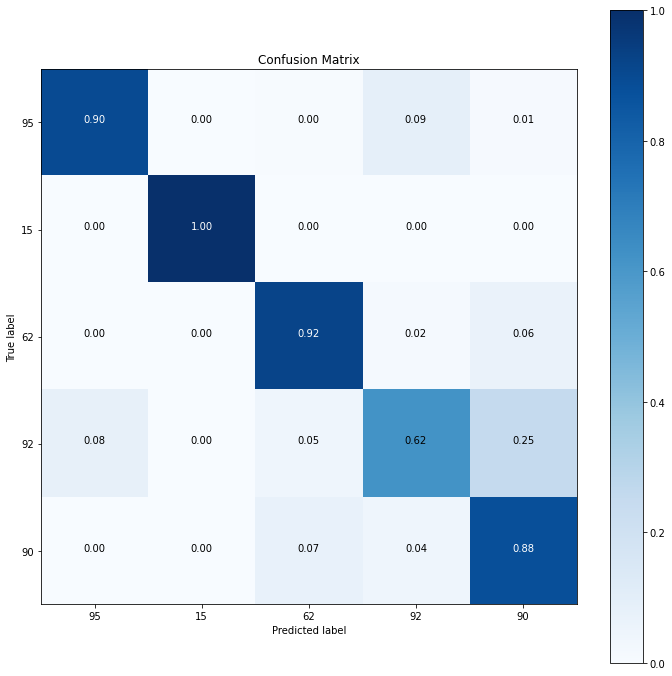


For number of classes: 6

X_train:  (9600, 105) , y_train:  (9600,) , X_test:  (2400, 105) , y_test:  (2400,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 1003.04 seconds

Evaluation GP Model results:
Precision:  0.89
Recall:  0.89
F1-Score:  0.89
Accuracy:  0.89

Per Class Results:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       387
           1       0.99      0.99      0.99       419
           2       0.89      0.94      0.91       405
           3       0.78      0.68      0.73       378
           4       0.75      0.84      0.79       415
           5       0.98      0.99      0.99       396

    accuracy                           0.89      2400
   macro avg       0.89      0.89      0.89      2400
weighted avg       0.89      0.89      0.89      2400



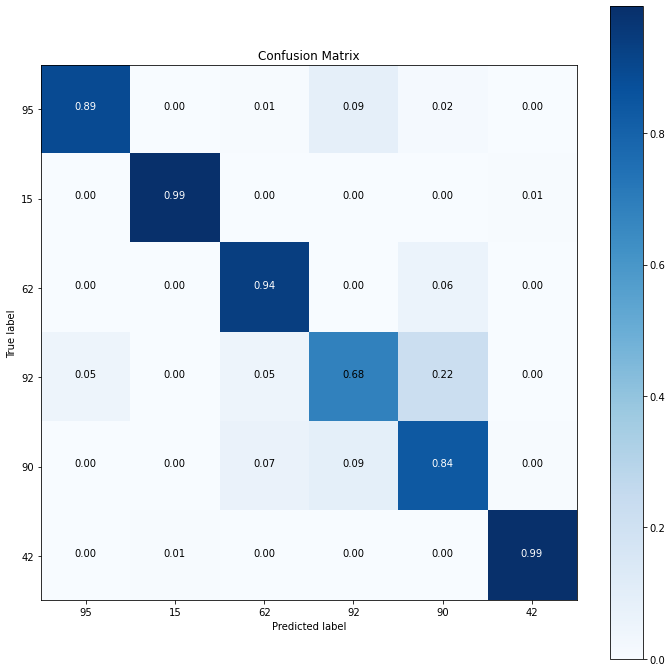


DL evaluation:

Model summary:
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 256)               27136     
_________________________________________________________________
dense_73 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_74 (Dense)             (None, 6)                 390       
_________________________________________________________________
activation_24 (Activation)   (None, 6)                 0         
Total params: 43,974
Trainable params: 43,974
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
  1/300 [..............................] - ETA: 0s - loss: 2.0028 - accuracy: 0.1562

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4 5], y=[5 4 2 ... 4 5 5] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


300/300 [==============================] - 0s 972us/step - loss: 0.5063 - accuracy: 0.8045 - val_loss: 0.3949 - val_accuracy: 0.8304
Epoch 2/500
300/300 [==============================] - 0s 778us/step - loss: 0.3936 - accuracy: 0.8320 - val_loss: 0.3821 - val_accuracy: 0.8308
Epoch 3/500
300/300 [==============================] - 0s 757us/step - loss: 0.3886 - accuracy: 0.8332 - val_loss: 0.3824 - val_accuracy: 0.8413
Epoch 4/500
300/300 [==============================] - 0s 722us/step - loss: 0.3805 - accuracy: 0.8358 - val_loss: 0.3984 - val_accuracy: 0.8550
Epoch 5/500
300/300 [==============================] - 0s 750us/step - loss: 0.3616 - accuracy: 0.8401 - val_loss: 0.3774 - val_accuracy: 0.8483
Epoch 6/500
300/300 [==============================] - 0s 747us/step - loss: 0.3602 - accuracy: 0.8432 - val_loss: 0.3686 - val_accuracy: 0.8450
Epoch 7/500
300/300 [==============================] - 0s 737us/step - loss: 0.3624 - accuracy: 0.8439 - val_loss: 0.3921 - val_accuracy: 0.84

300/300 [==============================] - 0s 728us/step - loss: 0.3074 - accuracy: 0.8673 - val_loss: 0.3866 - val_accuracy: 0.8608
Epoch 114/500
300/300 [==============================] - 0s 733us/step - loss: 0.3033 - accuracy: 0.8693 - val_loss: 0.3479 - val_accuracy: 0.8592
Epoch 115/500
300/300 [==============================] - 0s 771us/step - loss: 0.3034 - accuracy: 0.8689 - val_loss: 0.3747 - val_accuracy: 0.8562
Epoch 116/500
300/300 [==============================] - 0s 770us/step - loss: 0.2998 - accuracy: 0.8710 - val_loss: 0.3479 - val_accuracy: 0.8562
Epoch 117/500
300/300 [==============================] - 0s 763us/step - loss: 0.3008 - accuracy: 0.8711 - val_loss: 0.3611 - val_accuracy: 0.8612
Epoch 118/500
300/300 [==============================] - 0s 758us/step - loss: 0.3034 - accuracy: 0.8695 - val_loss: 0.3378 - val_accuracy: 0.8575
Epoch 119/500
300/300 [==============================] - 0s 723us/step - loss: 0.3039 - accuracy: 0.8687 - val_loss: 0.3347 - val_ac

Epoch 169/500
300/300 [==============================] - 0s 844us/step - loss: 0.3141 - accuracy: 0.8679 - val_loss: 0.3379 - val_accuracy: 0.8671
Epoch 170/500
300/300 [==============================] - 0s 929us/step - loss: 0.3165 - accuracy: 0.8716 - val_loss: 0.3338 - val_accuracy: 0.8617
Epoch 171/500
300/300 [==============================] - 0s 884us/step - loss: 0.3016 - accuracy: 0.8706 - val_loss: 0.3413 - val_accuracy: 0.8687
Epoch 172/500
300/300 [==============================] - 0s 880us/step - loss: 0.3004 - accuracy: 0.8718 - val_loss: 0.3465 - val_accuracy: 0.8683
Epoch 173/500
300/300 [==============================] - 0s 917us/step - loss: 0.2965 - accuracy: 0.8744 - val_loss: 0.3507 - val_accuracy: 0.8642
Epoch 174/500
300/300 [==============================] - 0s 865us/step - loss: 0.2940 - accuracy: 0.8764 - val_loss: 0.3424 - val_accuracy: 0.8625
Epoch 175/500
300/300 [==============================] - 0s 891us/step - loss: 0.2956 - accuracy: 0.8710 - val_loss: 0

Epoch 225/500
300/300 [==============================] - 0s 786us/step - loss: 0.3067 - accuracy: 0.8715 - val_loss: 0.3477 - val_accuracy: 0.8700
Epoch 226/500
300/300 [==============================] - 0s 768us/step - loss: 0.2945 - accuracy: 0.8756 - val_loss: 0.3357 - val_accuracy: 0.8596
Epoch 227/500
300/300 [==============================] - 0s 790us/step - loss: 0.2930 - accuracy: 0.8758 - val_loss: 0.3399 - val_accuracy: 0.8633
Epoch 228/500
300/300 [==============================] - 0s 861us/step - loss: 0.2923 - accuracy: 0.8747 - val_loss: 0.3453 - val_accuracy: 0.8692
Epoch 229/500
300/300 [==============================] - 0s 773us/step - loss: 0.2979 - accuracy: 0.8732 - val_loss: 0.3447 - val_accuracy: 0.8654
Epoch 230/500
300/300 [==============================] - 0s 731us/step - loss: 0.2918 - accuracy: 0.8744 - val_loss: 0.3333 - val_accuracy: 0.8692
Epoch 231/500
300/300 [==============================] - 0s 775us/step - loss: 0.2931 - accuracy: 0.8779 - val_loss: 0

Epoch 281/500
300/300 [==============================] - 0s 811us/step - loss: 0.2916 - accuracy: 0.8749 - val_loss: 0.4084 - val_accuracy: 0.8537
Epoch 282/500
300/300 [==============================] - 0s 784us/step - loss: 0.2908 - accuracy: 0.8782 - val_loss: 0.3338 - val_accuracy: 0.8671
Epoch 283/500
300/300 [==============================] - 0s 823us/step - loss: 0.2927 - accuracy: 0.8754 - val_loss: 0.3493 - val_accuracy: 0.8650
Epoch 284/500
300/300 [==============================] - 0s 838us/step - loss: 0.2920 - accuracy: 0.8774 - val_loss: 0.3388 - val_accuracy: 0.8579
Epoch 285/500
300/300 [==============================] - 0s 811us/step - loss: 0.2883 - accuracy: 0.8763 - val_loss: 0.3301 - val_accuracy: 0.8729
Epoch 286/500
300/300 [==============================] - 0s 842us/step - loss: 0.2879 - accuracy: 0.8759 - val_loss: 0.3327 - val_accuracy: 0.8687
Epoch 287/500
300/300 [==============================] - 0s 802us/step - loss: 0.2897 - accuracy: 0.8771 - val_loss: 0

Epoch 337/500
300/300 [==============================] - 0s 799us/step - loss: 0.2874 - accuracy: 0.8768 - val_loss: 0.3337 - val_accuracy: 0.8671
Epoch 338/500
300/300 [==============================] - 0s 819us/step - loss: 0.2868 - accuracy: 0.8779 - val_loss: 0.3440 - val_accuracy: 0.8712
Epoch 339/500
300/300 [==============================] - 0s 794us/step - loss: 0.2889 - accuracy: 0.8779 - val_loss: 0.3328 - val_accuracy: 0.8662
Epoch 340/500
300/300 [==============================] - 0s 795us/step - loss: 0.2894 - accuracy: 0.8764 - val_loss: 0.3382 - val_accuracy: 0.8675
Epoch 341/500
300/300 [==============================] - 0s 807us/step - loss: 0.3312 - accuracy: 0.8707 - val_loss: 0.3837 - val_accuracy: 0.8658
Epoch 342/500
300/300 [==============================] - 0s 823us/step - loss: 0.3310 - accuracy: 0.8743 - val_loss: 0.3638 - val_accuracy: 0.8662
Epoch 343/500
300/300 [==============================] - 0s 784us/step - loss: 0.2936 - accuracy: 0.8779 - val_loss: 0

Epoch 393/500
300/300 [==============================] - 0s 761us/step - loss: 0.2830 - accuracy: 0.8808 - val_loss: 0.3355 - val_accuracy: 0.8671
Epoch 394/500
300/300 [==============================] - 0s 740us/step - loss: 0.2845 - accuracy: 0.8784 - val_loss: 0.3429 - val_accuracy: 0.8758
Epoch 395/500
300/300 [==============================] - 0s 750us/step - loss: 0.2867 - accuracy: 0.8776 - val_loss: 0.3505 - val_accuracy: 0.8642
Epoch 396/500
300/300 [==============================] - 0s 772us/step - loss: 0.2859 - accuracy: 0.8779 - val_loss: 0.4172 - val_accuracy: 0.8654
Epoch 397/500
300/300 [==============================] - 0s 748us/step - loss: 0.2906 - accuracy: 0.8781 - val_loss: 0.3446 - val_accuracy: 0.8637
Epoch 398/500
300/300 [==============================] - 0s 800us/step - loss: 0.2930 - accuracy: 0.8771 - val_loss: 0.3443 - val_accuracy: 0.8704
Epoch 399/500
300/300 [==============================] - 0s 745us/step - loss: 0.3070 - accuracy: 0.8780 - val_loss: 0

Epoch 449/500
300/300 [==============================] - 0s 802us/step - loss: 0.2854 - accuracy: 0.8801 - val_loss: 0.3416 - val_accuracy: 0.8683
Epoch 450/500
300/300 [==============================] - 0s 779us/step - loss: 0.2847 - accuracy: 0.8795 - val_loss: 0.3435 - val_accuracy: 0.8737
Epoch 451/500
300/300 [==============================] - 0s 813us/step - loss: 0.2852 - accuracy: 0.8799 - val_loss: 0.3432 - val_accuracy: 0.8717
Epoch 452/500
300/300 [==============================] - 0s 821us/step - loss: 0.2828 - accuracy: 0.8816 - val_loss: 0.3416 - val_accuracy: 0.8712
Epoch 453/500
300/300 [==============================] - 0s 835us/step - loss: 0.2838 - accuracy: 0.8784 - val_loss: 0.3494 - val_accuracy: 0.8704
Epoch 454/500
300/300 [==============================] - 0s 836us/step - loss: 0.2834 - accuracy: 0.8767 - val_loss: 0.3411 - val_accuracy: 0.8750
Epoch 455/500
300/300 [==============================] - 0s 903us/step - loss: 0.2836 - accuracy: 0.8794 - val_loss: 0

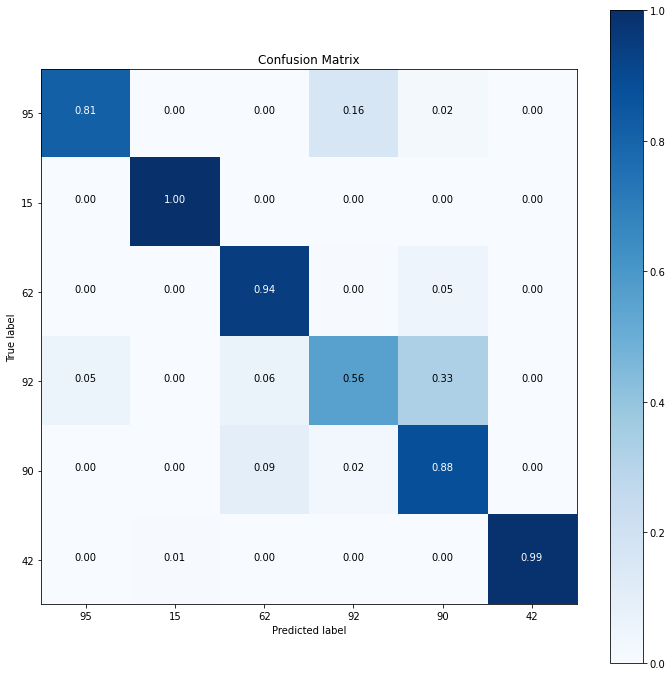


For number of classes: 7

X_train:  (11200, 105) , y_train:  (11200,) , X_test:  (2800, 105) , y_test:  (2800,)

GP evaluation:

Initial parameters:



Parameters after optimization:


Optimization took 1579.08 seconds

Evaluation GP Model results:
Precision:  0.85
Recall:  0.86
F1-Score:  0.85
Accuracy:  0.86

Per Class Results:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       409
           1       0.99      1.00      1.00       417
           2       0.88      0.94      0.91       397
           3       0.68      0.55      0.61       378
           4       0.72      0.82      0.77       407
           5       0.99      0.99      0.99       404
           6       0.75      0.79      0.77       388

    accuracy                           0.85      2800
   macro avg       0.85      0.85      0.85      2800
weighted avg       0.85      0.85      0.85      2800



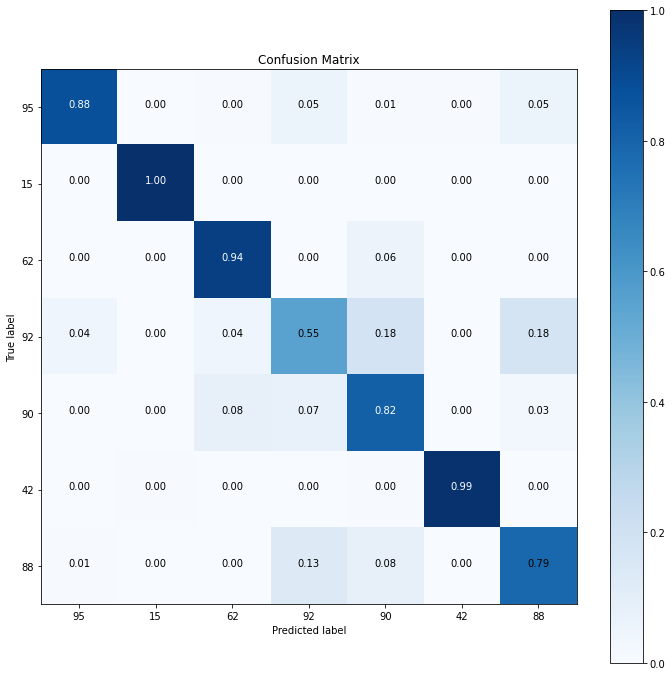


DL evaluation:

Model summary:
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 256)               27136     
_________________________________________________________________
dense_76 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_77 (Dense)             (None, 7)                 455       
_________________________________________________________________
activation_25 (Activation)   (None, 7)                 0         
Total params: 44,039
Trainable params: 44,039
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
  1/350 [..............................] - ETA: 0s - loss: 2.2583 - accuracy: 0.0625

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4 5 6], y=[6 0 2 ... 1 3 5] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


350/350 [==============================] - 0s 1ms/step - loss: 0.6434 - accuracy: 0.7490 - val_loss: 0.5691 - val_accuracy: 0.7839
Epoch 2/500
350/350 [==============================] - 0s 863us/step - loss: 0.6214 - accuracy: 0.7755 - val_loss: 0.5502 - val_accuracy: 0.7782
Epoch 3/500
350/350 [==============================] - 0s 845us/step - loss: 0.5513 - accuracy: 0.7763 - val_loss: 0.5091 - val_accuracy: 0.7979
Epoch 4/500
350/350 [==============================] - 0s 814us/step - loss: 0.5517 - accuracy: 0.7821 - val_loss: 0.5095 - val_accuracy: 0.7907
Epoch 5/500
350/350 [==============================] - 0s 860us/step - loss: 0.5342 - accuracy: 0.7869 - val_loss: 0.5445 - val_accuracy: 0.7939
Epoch 6/500
350/350 [==============================] - 0s 850us/step - loss: 0.5264 - accuracy: 0.7849 - val_loss: 0.5360 - val_accuracy: 0.7932
Epoch 7/500
350/350 [==============================] - 0s 856us/step - loss: 0.5151 - accuracy: 0.7919 - val_loss: 0.5224 - val_accuracy: 0.7929

350/350 [==============================] - 0s 848us/step - loss: 0.4552 - accuracy: 0.8120 - val_loss: 0.4642 - val_accuracy: 0.8111
Epoch 114/500
350/350 [==============================] - 0s 836us/step - loss: 0.4497 - accuracy: 0.8163 - val_loss: 0.4617 - val_accuracy: 0.8129
Epoch 115/500
350/350 [==============================] - 0s 843us/step - loss: 0.4477 - accuracy: 0.8138 - val_loss: 0.4581 - val_accuracy: 0.8161
Epoch 116/500
350/350 [==============================] - 0s 831us/step - loss: 0.4507 - accuracy: 0.8162 - val_loss: 0.4601 - val_accuracy: 0.8154
Epoch 117/500
350/350 [==============================] - 0s 856us/step - loss: 0.4458 - accuracy: 0.8169 - val_loss: 0.4655 - val_accuracy: 0.8175
Epoch 118/500
350/350 [==============================] - 0s 841us/step - loss: 0.4498 - accuracy: 0.8145 - val_loss: 0.4526 - val_accuracy: 0.8214
Epoch 119/500
350/350 [==============================] - 0s 862us/step - loss: 0.4862 - accuracy: 0.8126 - val_loss: 0.4747 - val_ac

Epoch 169/500
350/350 [==============================] - 0s 871us/step - loss: 0.4752 - accuracy: 0.8146 - val_loss: 0.4584 - val_accuracy: 0.8164
Epoch 170/500
350/350 [==============================] - 0s 852us/step - loss: 0.4510 - accuracy: 0.8145 - val_loss: 0.4509 - val_accuracy: 0.8232
Epoch 171/500
350/350 [==============================] - 0s 845us/step - loss: 0.4411 - accuracy: 0.8196 - val_loss: 0.4561 - val_accuracy: 0.8211
Epoch 172/500
350/350 [==============================] - 0s 856us/step - loss: 0.4415 - accuracy: 0.8196 - val_loss: 0.4616 - val_accuracy: 0.8164
Epoch 173/500
350/350 [==============================] - 0s 816us/step - loss: 0.4450 - accuracy: 0.8188 - val_loss: 0.4649 - val_accuracy: 0.8168
Epoch 174/500
350/350 [==============================] - 0s 821us/step - loss: 0.4460 - accuracy: 0.8146 - val_loss: 0.4607 - val_accuracy: 0.8164
Epoch 175/500
350/350 [==============================] - 0s 847us/step - loss: 0.4543 - accuracy: 0.8155 - val_loss: 0

Epoch 225/500
350/350 [==============================] - 0s 855us/step - loss: 0.4454 - accuracy: 0.8183 - val_loss: 0.4544 - val_accuracy: 0.8164
Epoch 226/500
350/350 [==============================] - 0s 838us/step - loss: 0.4411 - accuracy: 0.8154 - val_loss: 0.4497 - val_accuracy: 0.8225
Epoch 227/500
350/350 [==============================] - 0s 883us/step - loss: 0.4455 - accuracy: 0.8183 - val_loss: 0.4526 - val_accuracy: 0.8218
Epoch 228/500
350/350 [==============================] - 0s 841us/step - loss: 0.4413 - accuracy: 0.8191 - val_loss: 0.4492 - val_accuracy: 0.8200
Epoch 229/500
350/350 [==============================] - ETA: 0s - loss: 0.4460 - accuracy: 0.81 - 0s 859us/step - loss: 0.4435 - accuracy: 0.8186 - val_loss: 0.4671 - val_accuracy: 0.8225
Epoch 230/500
350/350 [==============================] - 0s 840us/step - loss: 0.4387 - accuracy: 0.8231 - val_loss: 0.4502 - val_accuracy: 0.8254
Epoch 231/500
350/350 [==============================] - 0s 850us/step - los

Epoch 336/500
350/350 [==============================] - 0s 977us/step - loss: 0.4341 - accuracy: 0.8230 - val_loss: 0.4423 - val_accuracy: 0.8239
Epoch 337/500
350/350 [==============================] - 0s 932us/step - loss: 0.4323 - accuracy: 0.8226 - val_loss: 0.4404 - val_accuracy: 0.8246
Epoch 338/500
350/350 [==============================] - 0s 828us/step - loss: 0.4338 - accuracy: 0.8225 - val_loss: 0.4474 - val_accuracy: 0.8189
Epoch 339/500
350/350 [==============================] - 0s 887us/step - loss: 0.4349 - accuracy: 0.8248 - val_loss: 0.4418 - val_accuracy: 0.8289
Epoch 340/500
350/350 [==============================] - 0s 902us/step - loss: 0.4347 - accuracy: 0.8226 - val_loss: 0.4464 - val_accuracy: 0.8225
Epoch 341/500
350/350 [==============================] - 0s 992us/step - loss: 0.4328 - accuracy: 0.8251 - val_loss: 0.4435 - val_accuracy: 0.8225
Epoch 342/500
350/350 [==============================] - 0s 872us/step - loss: 0.4367 - accuracy: 0.8227 - val_loss: 0

Epoch 392/500
350/350 [==============================] - 0s 847us/step - loss: 0.4583 - accuracy: 0.8179 - val_loss: 0.4866 - val_accuracy: 0.8157
Epoch 393/500
350/350 [==============================] - 0s 853us/step - loss: 0.4444 - accuracy: 0.8217 - val_loss: 0.4468 - val_accuracy: 0.8211
Epoch 394/500
350/350 [==============================] - 0s 836us/step - loss: 0.4348 - accuracy: 0.8250 - val_loss: 0.4520 - val_accuracy: 0.8229
Epoch 395/500
350/350 [==============================] - 0s 865us/step - loss: 0.4322 - accuracy: 0.8232 - val_loss: 0.4549 - val_accuracy: 0.8168
Epoch 396/500
350/350 [==============================] - 0s 857us/step - loss: 0.4322 - accuracy: 0.8238 - val_loss: 0.4612 - val_accuracy: 0.8275
Epoch 397/500
350/350 [==============================] - 0s 827us/step - loss: 0.4330 - accuracy: 0.8234 - val_loss: 0.4497 - val_accuracy: 0.8296
Epoch 398/500
350/350 [==============================] - 0s 889us/step - loss: 0.4330 - accuracy: 0.8216 - val_loss: 0

Epoch 448/500
350/350 [==============================] - 0s 839us/step - loss: 0.4357 - accuracy: 0.8220 - val_loss: 0.4447 - val_accuracy: 0.8257
Epoch 449/500
350/350 [==============================] - 0s 849us/step - loss: 0.4302 - accuracy: 0.8249 - val_loss: 0.4435 - val_accuracy: 0.8225
Epoch 450/500
350/350 [==============================] - 0s 888us/step - loss: 0.4288 - accuracy: 0.8262 - val_loss: 0.4457 - val_accuracy: 0.8232
Epoch 451/500
350/350 [==============================] - 0s 859us/step - loss: 0.4296 - accuracy: 0.8257 - val_loss: 0.4553 - val_accuracy: 0.8079
Epoch 452/500
350/350 [==============================] - 0s 830us/step - loss: 0.4311 - accuracy: 0.8231 - val_loss: 0.4443 - val_accuracy: 0.8211
Epoch 453/500
350/350 [==============================] - 0s 868us/step - loss: 0.4308 - accuracy: 0.8246 - val_loss: 0.4406 - val_accuracy: 0.8282
Epoch 454/500
350/350 [==============================] - 0s 855us/step - loss: 0.4303 - accuracy: 0.8233 - val_loss: 0

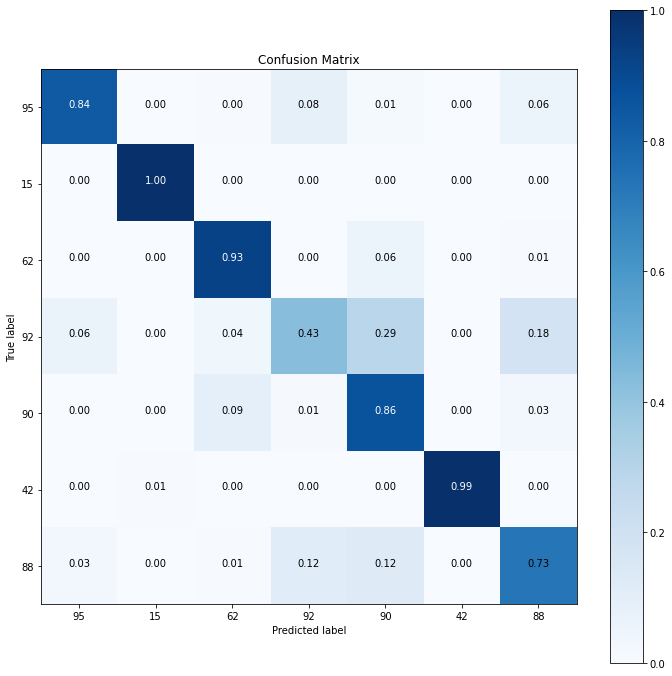

([1.0, 0.94, 0.87, 0.89, 0.86],
 [91.97, 359.82, 619.93, 1003.04, 1579.08],
 [1.0, 0.93, 0.87, 0.89, 0.85],
 [1.0, 0.94, 0.87, 0.89, 0.86],
 [1.0, 0.93, 0.87, 0.89, 0.85],
 [1.0, 0.92, 0.86, 0.87, 0.83],
 [67.65, 78.84, 110.89, 121.42, 150.47],
 [1.0, 0.92, 0.87, 0.87, 0.83],
 [1.0, 0.92, 0.86, 0.87, 0.83],
 [1.0, 0.92, 0.86, 0.86, 0.82])

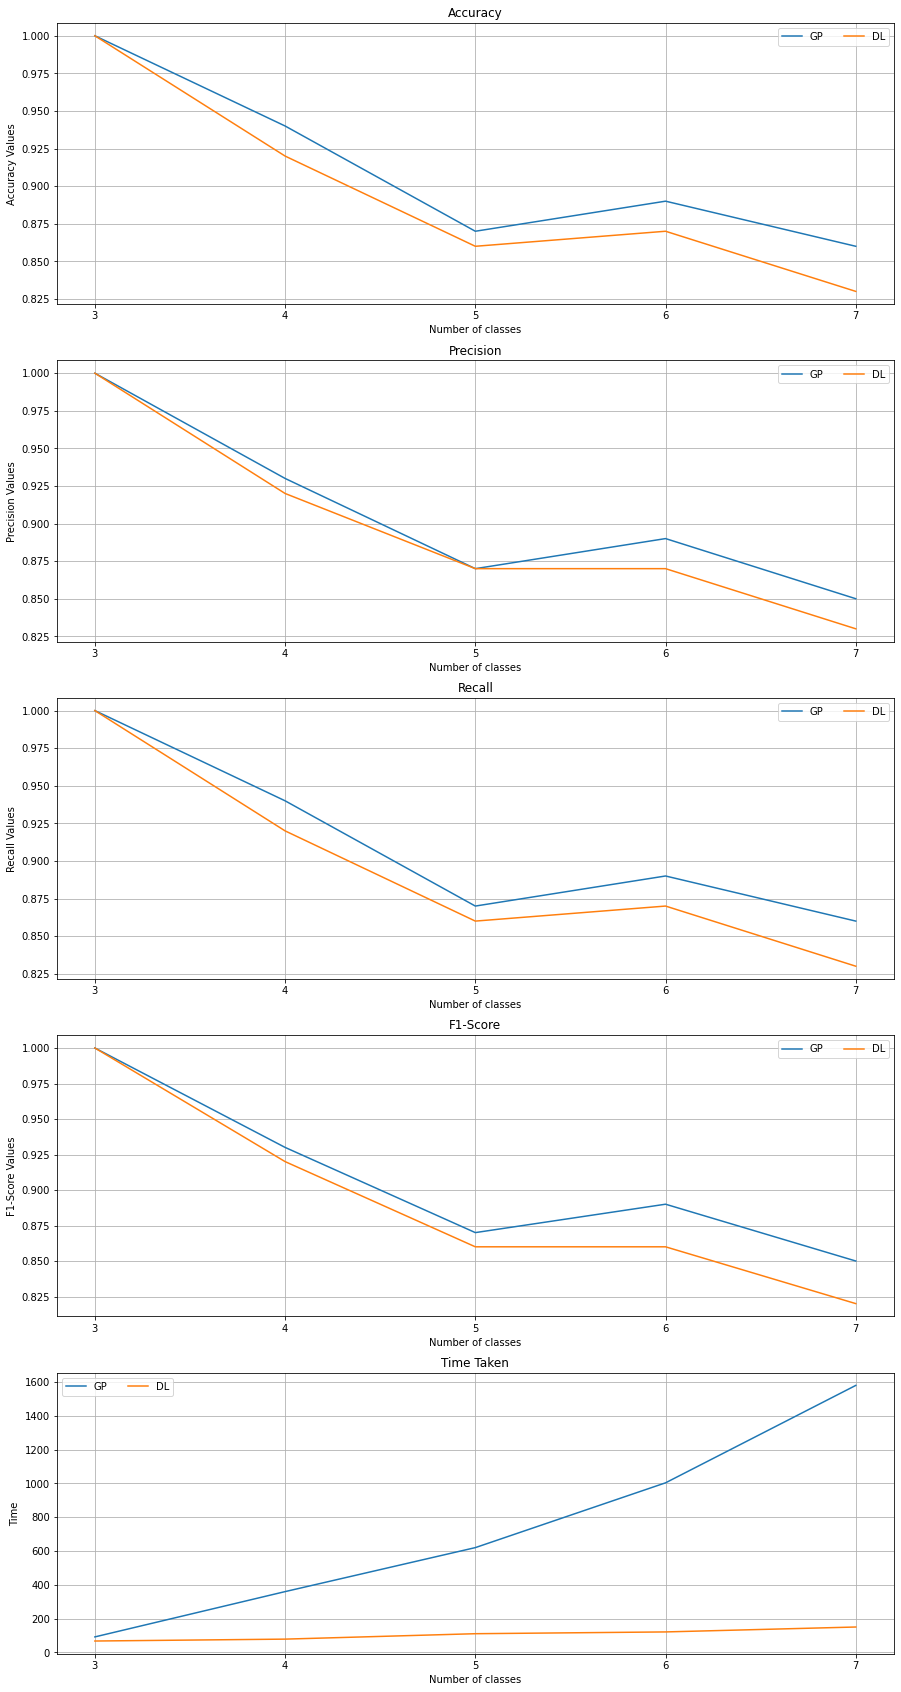

In [15]:
run_models(dl_model_2, 2000)